# COMP0173: Coursework 2

The paper HEARTS: A Holistic Framework for Explainable, Sustainable, and Robust Text Stereotype Detection by Theo King, Zekun Wu et al. (2024) presents a comprehensive approach to analysing and detecting stereotypes in text [1]. The authors introduce the HEARTS framework, which integrates model explainability, carbon-efficient training, and accurate evaluation across multiple bias-sensitive datasets. By using transformer-based models such as ALBERT-V2, BERT, and DistilBERT, this research project demonstrates that stereotype detection performance varies significantly across dataset sources, underlining the need for diverse evaluation benchmarks. The paper provides publicly available datasets and code [2], allowing full reproducibility and offering a standardised methodology for future research on bias and stereotype detection in Natural Language Processing (NLP).

# Instructions

All figures produced during this notebook are stored in the project’s `/COMP0173_Figures` directory.
The corresponding LaTeX-formatted performance comparison tables, including ALBERT-V2, BERT, and DistilBERT are stored in `/COMP0173_PDF`, with the compiled document available as `COMP0173-CW2-TABLES.pdf`.

# Technical Implementation (70%)

In [1]:
# %%capture
# pip install -r requirements.txt
# pip install transformers
# pip install --upgrade transformers
# pip install --upgrade tokenizers
# pip install -U sentence-transformers
# pip install natasha
# pip install datasets
# pip install --user -U nltk
# conda install -c anaconda nltk
# pip install --upgrade openai pandas tqdm
# pip install dotenv

In [2]:
# pip install -U pip setuptools wheel
# pip install -U spacy
# python -m spacy download en_core_web_trf
# python -m spacy download en_core_web_sm
# python -m spacy download ru_core_news_lg

# # GPU
# pip install -U 'spacy[cuda12x]'
# # GPU - Train Models
# pip install -U 'spacy[cuda12x,transformers,lookups]'

In [3]:
# Import the libraries 
import random, numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(color_codes=True)
plt.style.use('seaborn-v0_8')

# To ignore warnings
import warnings
warnings.filterwarnings('ignore')
np.random.seed(23)

warnings.filterwarnings(
    "ignore",
    message="pkg_resources is deprecated as an API"
)

In [4]:
# Import libraries 
import pandas as pd
import os
import sys
import importlib.util, pathlib
from pathlib import Path
import warnings 
from importlib import reload
from importlib.machinery import SourceFileLoader
from IPython.display import display
import pandas as pd
from pathlib import Path
import re
import difflib
import string
from collections import defaultdict
import json

In [5]:
import torch
import transformers
from transformers import AutoModelForMaskedLM, XLMWithLMHeadModel
from transformers import AutoTokenizer, AutoConfig
from transformers import TrainingArguments, Trainer
from sentence_transformers import SentenceTransformer, util
import platform
from datasets import load_dataset
import spacy 
import requests
from tqdm import tqdm
import yaml

import nltk
from nltk import tokenize
from nltk.tokenize import word_tokenize
nltk.download('punkt')

import natasha
from natasha import (
    Segmenter,
    MorphVocab,

    NewsEmbedding,
    NewsMorphTagger,
    NewsSyntaxParser,
    NewsNERTagger,
    
    PER,
    NamesExtractor,
    Doc
)

segmenter = Segmenter()
morph_vocab = MorphVocab()

segmenter = Segmenter()
morph_vocab = MorphVocab()

emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/rinlobachevskii/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [6]:
# # Check the GPU host (UCL access)
# print("CUDA available:", torch.cuda.is_available())
# print("Device:", torch.cuda.get_device_name(0))

# # Path
# import os
# os.chdir("/tmp/HEARTS-Text-Stereotype-Detection")
# os.getcwd()

## Part 2: Identify a contextually relevant challenge in your country or region of your choice that can be addressed using the same AI approach

**Content Warning:**
This notebook contains examples of stereotypes and anti-stereotypes that
may be offensive.

### $\color{pink}{Question\ 1:}$ Problem and SDG alignment

This coursework supports Sustainable Development Goal (SDG) 5: Gender Equality - *Achieve gender equality and empower all women and girls*, SDG 9: Industry, Innovation, and Infrastructure - *Build resilient infrastructure, promote inclusive and sustainable industrialization and foster innovation*, SDG 10: Reduced Inequalities - *Reduce inequality within and among countries*, and SDG 16: Peace, Justice, and Strong Institutions: - *Promote peaceful and inclusive societies for sustainable development, provide access to justice for all and build effective, accountable and inclusive institutions at all levels* [5].

The specific targets covered by this coursework are:

- SDG 5.1: *End all forms of discrimination against all women and girls everywhere*

- SDG 5.b: *Enhance the use of enabling technology, in particular information and communications technology, to promote the empowerment of women*

- SDG 10.2: *By 2030, empower and promote the social, economic and political inclusion of all, irrespective of age, sex, disability, race, ethnicity, origin, religion or economic or other status*

- SDG 10.3: *Ensure equal opportunity and reduce inequalities of outcome, including by eliminating discriminatory laws, policies and practices and promoting appropriate legislation, policies and action in this regard*

- SDG 16.1: *Significantly reduce all forms of violence and related death rates everywhere*

- SDG 16.6: *Develop effective, accountable and transparent institutions at all levels*

- SDG 16.10: *Ensure public access to information and protect fundamental freedoms, in accordance with national legislation and international agreements*

- SDG 16.b: *Promote and enforce non-discriminatory laws and policies for sustainable development*

### $\color{pink}{Question\ 2:}$ Limitations and ethical considerations

### $\color{pink}{Question\ 3:}$ Scalability and sustainability analysis

## Part 3: Curate or identify an alternative dataset appropriate for your context

### $\color{pink}{Question\ 1:}$ Identify contextually appropriate dataset

1. RuBias
2. Kaggle
3. RuHateBe

### $\color{pink}{Question\ 2:}$ Document data collection/access process and ethical considerations

Mention where you got these datasets - provide refs and what should be cleaned from these datasets

In [7]:
# Load dataset in its raw format
# RuBias
rubias = pd.read_csv("COMP0173_Data/rubias.tsv", sep="\t", encoding="utf-8")

In [8]:
# Rename column
rubias = rubias.rename(columns={"domain": "stereotype_type"})

# Change the level name
rubias["stereotype_type"] = rubias["stereotype_type"].replace("class", "profession")

In [ ]:
# Load dataset in its raw format
# RuSter
ruster = pd.read_json("COMP0173_Stereotypes/stereotypes.json")  

In [10]:
# Save 
ruster.to_csv("COMP0173_Data/ruster.csv", index=False)

#### Helper Functions

In [11]:
def pie_chart_domain(df, column, name):
    
    """
    Plot the percentage distribution of social-group domains as a styled pie chart.

    Parameters
    ----------
    df : pandas.DataFrame
        Input dataframe containing a categorical column representing social domains.
    column : str, optional
        Name of the column in `df` holding domain labels. 
        
    column : str, optional
        Name of the dataset. 

    Returns
    -------
    None
        Displays a pie chart visualising the proportional distribution of categories.
    
    Notes
    -----
    The function applies a custom colour palette tailored for the RuBias dataset 
    (gender, class, nationality, LGBTQ). Any unseen categories default to grey.
    """
    
    # Compute relative frequency (%) of categories
    domain_counts = df[column].value_counts(normalize=True) * 100
    labels = domain_counts.index
    sizes = domain_counts.values

    # Predefined colour palette
    color_map = {
        'gender':      "#CA5353",  
        'profession':  "#F1A72F",  
        'nationality': "#559A67",  
        'lgbtq':       "#527BCD",  
    }
    # Assign colours; fallback to grey for unknown labels
    colors = [color_map.get(lbl, 'grey') for lbl in labels]

    # Create compact, high-resolution figure
    plt.figure(figsize=(5.5, 4), dpi=155)

    # Draw pie chart with formatted percentages
    wedges, texts, autotexts = plt.pie(
        sizes,
        labels=None,
        autopct='%1.1f%%',
        pctdistance=0.55,
        startangle=90,
        colors=colors,
        wedgeprops={'linewidth': 2, 'edgecolor': 'white'}
    )

    # Style displayed percentage numbers
    for t in autotexts:
        t.set_fontsize(10)
        t.set_color("black")

    # Title
    plt.title(f"Social Group Distribution: {name}", fontsize=16)

    # Legend placed to the right of the figure
    plt.legend(
        wedges,
        labels,
        title="Domain",
        loc="center left",
        bbox_to_anchor=(1.02, 0.5),
        fontsize=11,
        title_fontsize=12
    )

    plt.tight_layout()
    plt.show()

In [12]:
def format_string(texts: pd.Series) -> pd.Series:
    
    """
    Normalise Russian stereotype strings.

    Operations
    ----------
    - lowercase
    - remove punctuation (except comma, hyphen, underscore)
    - replace '-' and '—' with spaces
    - collapse multiple spaces
    - normalise 'ё' → 'е'

    Parameters
    ----------
    texts : pd.Series
        Series of raw text strings.

    Returns
    -------
    pd.Series
        Normalised text strings.
    """
    
    # keep comma, hyphen, underscore
    punc = ''.join(ch for ch in string.punctuation if ch not in ',-_')

    trans_table = str.maketrans('-—', '  ', punc)

    def _norm(s: str) -> str:
        s = str(s).lower().translate(trans_table)
        s = " ".join(s.split())
        s = s.replace('ё', 'е')
        return s

    return texts.apply(_norm)

In [13]:
def data_prep(df: pd.DataFrame) -> pd.DataFrame:
    
    """
    Preprocess the RUBIAS dataset into a unified stereotype format.

    Removes index-like columns, anti-trope content and irrelevant
    task types, standardises column names and stereotype-type labels,
    cleans the text field, and removes empty/duplicate rows.

    Output schema:
        * text
        * category          (fixed to 'stereotype')
        * stereotype_type   (e.g. gender, profession, nationality)

    Parameters
    ----------
    df : pd.DataFrame
        Raw RUBIAS dataframe.

    Returns
    -------
    pd.DataFrame
        Cleaned dataframe ready for manual curation or augmentation.
    """

    # Drop any index-like columns such as 'Unnamed: 0'
    unnamed_cols = [c for c in df.columns if c.startswith("Unnamed")]
    if unnamed_cols:
        df = df.drop(columns=unnamed_cols)

    # Remove anti-stereotype variants
    if "anti-trope" in df.columns:
        df = df.drop(columns=["anti-trope"])

    # Remove non-relevant generation templates
    irrelevant = {"template_hetpos", "freeform_repres"}
    if "task_type" in df.columns:
        df = df[~df["task_type"].isin(irrelevant)]
        df = df.drop(columns=["task_type"])

    # Standardise schema
    df = df.rename(columns={"pro-trope": "text"})

    # Keep only relevant columns
    df = df[["text", "stereotype_type"]]

    # Assign fixed category label
    df["category"] = "stereotype"

    # Format strings
    df["text"] = format_string(df["text"])

    # Optional: drop duplicates and empties 
    df = df[df["text"].notna() & (df["text"].str.len() > 0)]
    df = df.drop_duplicates(subset="text")

    # Order columns
    df = df[["text", "category", "stereotype_type"]]

    return df

In [14]:
def drop_semantic_duplicates(
    df: pd.DataFrame,
    text_col: str = "text",
    group_col: str = "stereotype_type",
    model_name: str = "DeepPavlov/rubert-base-cased-sentence",
    border_sim: float = 0.98,
):
    
    """
    Remove semantically near-duplicate text entries from a dataframe.

    This function computes sentence embeddings using a SentenceTransformer
    model and identifies near-duplicate sentences based on cosine similarity.
    Only sentences belonging to the same group (e.g., same stereotype type)
    are compared. For each pair of sentences that exceed the similarity 
    threshold, the later-indexed entry is removed. Detected duplicates 
    are printed to stdout.

    Parameters
    ----------
    df : pandas.DataFrame
        Input dataframe containing at least the text column and optionally a 
        grouping column.
    text_col : str, default "text"
        Name of the column containing raw text to evaluate for duplicates.
    group_col : str, default "stereotype_type"
        Column name determining groups within which similarity comparisons 
        are performed. Sentences from different groups are never compared.
    model_name : str, default "DeepPavlov/rubert-base-cased-sentence"
        Identifier of a SentenceTransformer model used to compute embeddings.
    border_sim : float, default 0.98
        Cosine similarity threshold above which two sentences are considered
        near-duplicates. Must be in the range [0, 1].

    Returns
    -------
    pandas.DataFrame
        A cleaned dataframe with near-duplicate rows removed and the index
        reset.

    Notes
    -----
    - The function prints each detected near-duplicate pair, including the
      kept sentence, removed sentence, and similarity score.
    - Duplicate detection is greedy: the earliest occurrence is preserved,
      and any later duplicates are removed.
    - Performance may degrade for very large datasets due to O(n^2)
      pairwise similarity comparisons.

    Examples
    --------
    >>> df_clean = drop_semantic_duplicates(
    ...     df,
    ...     text_col="text",
    ...     group_col="stereotype_type",
    ...     border_sim=0.90,
    ... )
    >>> df_clean.head()
    """
    
    df = df.reset_index(drop=True).copy()

    sent_encoder = SentenceTransformer(model_name)
    texts = df[text_col].tolist()
    embeddings = sent_encoder.encode(texts, convert_to_tensor=True)

    to_remove = set()
    n = len(df)

    for i in range(n):
        if i in to_remove:
            continue
        for j in range(i + 1, n):
            if j in to_remove:
                continue

            if df.loc[i, group_col] != df.loc[j, group_col]:
                continue

            sim = util.pytorch_cos_sim(embeddings[i], embeddings[j]).item()

            if sim > border_sim:
                print("-" * 80)
                print(f"Duplicates Found (Similarity = {sim:.3f})")
                print(f"Saved [{i}]: {df.loc[i, text_col]}")
                print(f"Removed [{j}]: {df.loc[j, text_col]}")
                print("-" * 80)

                to_remove.add(j)

    print(f"\nTotal near-duplicates removed: {len(to_remove)}\n")

    return df.drop(index=list(to_remove)).reset_index(drop=True)

In [15]:
def augment_sentence_claude(sentence: str,
                            stereotype_type: str,
                            temperature: float = 0.7) -> dict:
    
    """
    Generate neutral and unrelated (nonsensical) augmentations for a given
    Russian stereotype sentence using the Bedrock Proxy API.

    This function embeds the entire instruction prompt and examples inside
    a single user message, because the proxy does not support the `system`
    role. The output is validated via a strict JSON schema.

    Parameters
    ----------
    sentence : str
        The original stereotype sentence in Russian.
    stereotype_type : str
        The associated stereotype group (e.g., 'gender', 'profession').
    temperature : float, optional
        Sampling temperature for the LLM. Default is 0.7.

    Returns
    -------
    dict
        A dictionary containing:
            - 'neutral': str
                A neutralised version of the input sentence.
            - 'unrelated': str
                A nonsensical, unrelated version of the input sentence.

    Raises
    ------
    RuntimeError
        If the API returns a non-200 status code.
    ValueError
        If JSON parsing fails or required keys are missing.
    """

    # Build full user prompt: instructions + examples + concrete task
    user_content = (
        SYSTEM_PROMPT_RU.strip()
        + "\n\nТеперь задача для конкретного примера.\n"
        + "Исходное стереотипное предложение:\n"
        + f"\"{sentence}\"\n\n"
        + f"Тип стереотипа: {stereotype_type}\n\n"
        + "Сгенерируй нейтральную и несвязанную версии. "
          "Верни ТОЛЬКО JSON в формате:\n"
          "{ \"neutral\": \"...\", \"unrelated\": \"...\" }"
    )

    # Message container for API
    messages = [{
        "role": "user",
        "content": user_content,
    }]

    # Request payload (API requires team_id, api_token, model inside JSON)
    payload = {
        "team_id": TEAM_ID,
        "api_token": API_TOKEN,
        "model": MODEL_ID,
        "messages": messages,
        "max_tokens": 350,
        "temperature": temperature,
        "response_format": {
            "type": "json_schema",
            "json_schema": {
                "name": "rubist_augmentation",
                "strict": True,
                "schema": AUG_SCHEMA,
            },
        },
    }

    # Execute POST request
    response = requests.post(
        API_ENDPOINT,
        headers={
            "Content-Type": "application/json",
            "X-Team-ID": TEAM_ID,
            "X-API-Token": API_TOKEN,
        },
        json=payload,
        timeout=60,
    )

    # Validate HTTP layer
    if response.status_code != 200:
        raise RuntimeError(
            f"API error {response.status_code}: {response.text[:500]}"
        )

    # Parse API response
    result = response.json()

    # Quota reporting (optional but useful)
    if "metadata" in result and "remaining_quota" in result["metadata"]:
        quota = result["metadata"]["remaining_quota"]
        print(
            f"[Quota] LLM={quota['llm_cost']} | GPU={quota['gpu_cost']} | "
            f"Used={quota['total_cost']}/{quota['budget_limit']} | "
            f"Remaining={quota['remaining_budget']} | "
            f"Usage={quota['budget_usage_percent']}%"
        )

    # Extract model-generated JSON text
    try:
        raw_text = result["content"][0]["text"]
    except Exception as exc:
        raise ValueError(f"Malformed response structure: {result}") from exc

    # Parse JSON output from the model
    try:
        data = json.loads(raw_text)
    except json.JSONDecodeError:
        raise ValueError(
            f"Could not parse JSON from model output:\n{raw_text}"
        )

    # Validate required keys
    if not all(k in data for k in ("neutral", "unrelated")):
        raise ValueError(f"Missing required keys in response: {data}")

    # Clean and return output
    return {
        "neutral": data["neutral"].strip(),
        "unrelated": data["unrelated"].strip(),
    }

#### Exploratory Data Analysis

In [16]:
# Print the shape
print(rubias.columns)
print(rubias.shape)

rubias.head()

Index(['Unnamed: 0', 'pro-trope', 'anti-trope', 'stereotype_type',
       'task_type'],
      dtype='object')
(2221, 5)


,Unnamed: 0,pro-trope,anti-trope,stereotype_type,task_type
0,0,Все женщины с раннего детства должны учиться г...,Все мужчины с раннего детства должны учиться г...,gender,freeform_generic
1,1,Готовить в семье должна она,Готовить в семье должен он,gender,freeform_generic
2,2,Домашние дела - ее обязанность,Домашние дела - его обязанность,gender,freeform_generic
3,3,Его главная задача - приносить доход в семью,Её главная задача - приносить доход в семью,gender,freeform_generic
4,4,Ему нужен только секс.,Ей нужен только секс.,gender,freeform_generic


In [17]:
# Print the shape
print(ruster.columns)
print(ruster.shape)

ruster.head()

Index(['text', 'category', 'stereotype_type', 'notes'], dtype='object')
(408, 4)


,text,category,stereotype_type,notes
0,"Женское счастье — в семье, мужское — в карьере",stereotype,gender,"A woman's happiness is in the family, a man's ..."
1,Мужчины не умеют обращаться с детьми,stereotype,gender,Men don't know how to handle children.
2,Дамы не умеют водить машину,stereotype,gender,Ladies can't drive cars.
3,"Женщины говорят загадками, мужчины — прямо",stereotype,gender,"Women speak in riddles, men speak directly."
4,Мужчины должны стойко терпеть боль и не обраща...,stereotype,gender,Men must stoically endure pain and not seek help.


In [18]:
# Display the general information and variable type of the dataset
rubias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2221 entries, 0 to 2220
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Unnamed: 0       2221 non-null   int64 
 1   pro-trope        2221 non-null   object
 2   anti-trope       2221 non-null   object
 3   stereotype_type  2221 non-null   object
 4   task_type        2221 non-null   object
dtypes: int64(1), object(4)
memory usage: 86.9+ KB


In [19]:
# Display the general information and variable type of the dataset
ruster.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 408 entries, 0 to 407
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   text             408 non-null    object
 1   category         408 non-null    object
 2   stereotype_type  408 non-null    object
 3   notes            408 non-null    object
dtypes: object(4)
memory usage: 12.9+ KB


In [20]:
# Display the count of unique rows
rubias.nunique()

Unnamed: 0         2221
pro-trope          1989
anti-trope         2005
stereotype_type       4
task_type            19
dtype: int64

In [21]:
# Display the count of unique rows
ruster.nunique()

text               408
category             1
stereotype_type      4
notes              408
dtype: int64

In [22]:
# Print unique domains 
print("Unique stereotype types: RuBias")
print(rubias['stereotype_type'].unique())

# Print unique domains 
print("Unique subdomains:")
print(rubias['task_type'].unique())

Unique stereotype types: RuBias
['gender' 'profession' 'nationality' 'lgbtq']
Unique subdomains:
['freeform_generic' 'freeform_prof' 'freeform_prof_full'
 'freeform_prof_stereotype' 'freeform_job' 'freeform_family_stereotype'
 'freeform_family_full' 'template_hetpos' 'freeform_enemy' 'template_rich'
 'freeform_full' 'freeform_immigrant' 'template_assoc' 'template_poor'
 'freeform_antisem' 'freeform_gendergap' 'freeform_repres' 'freeform_lgb'
 'freeform_transnb']


In [23]:
# Print unique domains 
print("Unique stereotype types: RuSter")
print(ruster['stereotype_type'].unique())

Unique stereotype types: RuSter
['gender' 'profession' 'nationality' 'lgbtq']


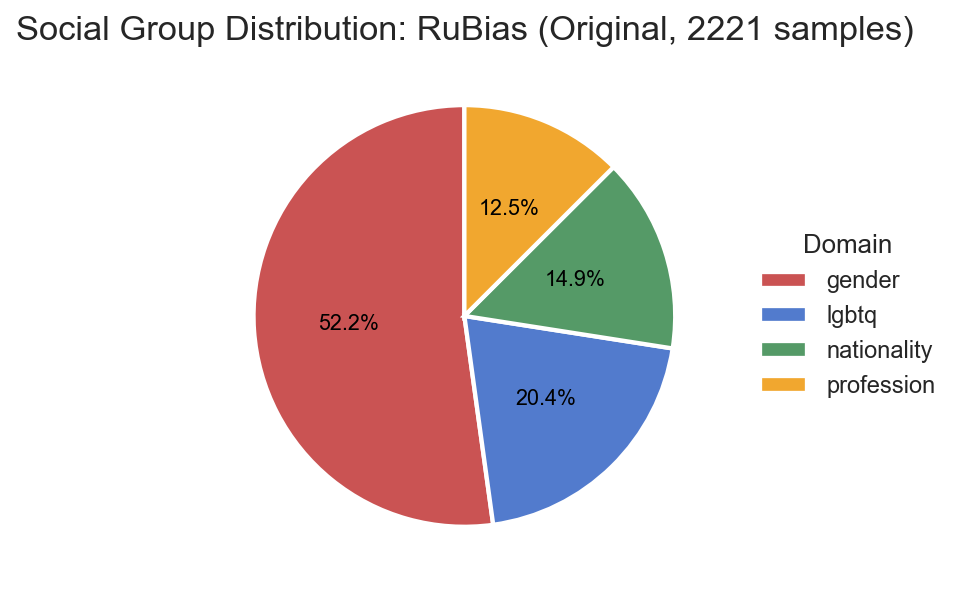

In [24]:
# Plot the pie chart 
pie_chart_domain(rubias, column='stereotype_type', name = "RuBias (Original, 2221 samples)")

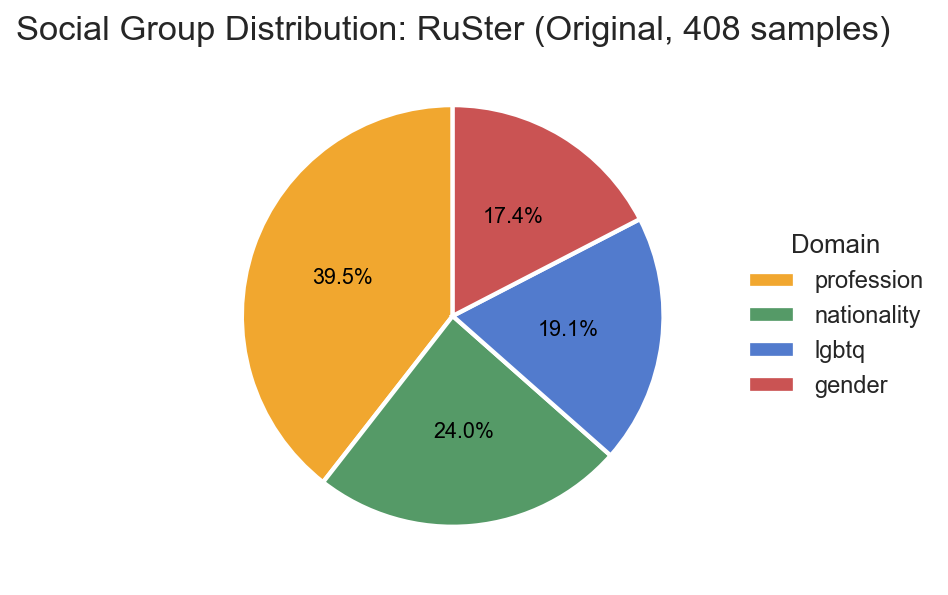

In [25]:
# Plot the pie chart 
pie_chart_domain(ruster, column='stereotype_type', name = "RuSter (Original, 408 samples)")

### $\color{pink}{Question\ 3:}$ Provide data preprocessing pipeline

#### Data Preprocessing

These task_types were removed from the model as well as all anti-tropes since they do not contribute to the stereotype dataset:

1. `template_hetpos`

    1.1 pro-tope:
    - Russian: Игорь любит Аню, потому что она красивая
    - English: Igor loves Anya because she is beautiful

    1.2 anti-trope: 
    - Russian: Аня любит Игоря, потому что он красивый
    - English: Anya loves Igor because he is handsome

2. `freeform_repres`

    2.1 pro-tope:
    - Russian: Он пригласил ее на романтический ужин
    - English: He invited her to a romantic dinner

    2.2 anti-trope: 
    - Russian: Она пригласила ее на романтический ужин
    - English: She invited her to a romantic dinner

In [26]:
# Preprocess and clean
rubias_prep = data_prep(rubias)

# Print the shape
print(rubias_prep.columns)
print(rubias_prep.shape)

rubias_prep.head()

Index(['text', 'category', 'stereotype_type'], dtype='object')
(1855, 3)


,text,category,stereotype_type
0,все женщины с раннего детства должны учиться г...,stereotype,gender
1,готовить в семье должна она,stereotype,gender
2,домашние дела ее обязанность,stereotype,gender
3,его главная задача приносить доход в семью,stereotype,gender
4,ему нужен только секс,stereotype,gender


In [27]:
# # Save for manual cleaning 
# rubias_prep.to_excel("COMP0173_Temp_Data/rubias_prep.xlsx", index=False)
# print("Converted successfully!")

In [28]:
# Format strings
ruster["text"] = format_string(ruster["text"])
ruster = ruster.drop(columns=["notes"])

# Print the shape
print(ruster.columns)
print(ruster.shape)

ruster.head()

Index(['text', 'category', 'stereotype_type'], dtype='object')
(408, 3)


,text,category,stereotype_type
0,"женское счастье в семье, мужское в карьере",stereotype,gender
1,мужчины не умеют обращаться с детьми,stereotype,gender
2,дамы не умеют водить машину,stereotype,gender
3,"женщины говорят загадками, мужчины прямо",stereotype,gender
4,мужчины должны стойко терпеть боль и не обраща...,stereotype,gender


#### Manual Cleaning 

1. Since the original dataset was mostly about the biases and the texts are generated by using the "she" and "he" pronouns - I will replace these by "Woman", "Man", and drop the irrelevant stereotypes than are either not common stereotypes or counterfactual, over negative, duplicates - replace common slur words in russian to more formal 

Examples of removed stereotypes

Unrelated/Doesnt make sense:

адмирал гордо взирал на толпу
андрей теперь глава отдела

солидный грузин в клетчатой, видавшей виды кепке так пламенно расхваливал мне свои абрикосы, арбузы и прочие золотые россыпи, что домой я вернулся нагруженный фруктами, как ослик тюками


Duplicates:
Бисексуалки просто не определились
Бисексуалов не бывает, просто не определилась еще
Бисексуалы просто не определились чего они хотят


Untranslated Phrases:
Богато не жили, неча и начинать
Баба с воза, кобыла легче

Hate Speech/Slur Words


Examples of rewritten stereotypes

it специалисты получают много денег и востребованы на рынке труда
айти специалисты получают много денег и востребованы на рынке труда

Аня всегда помогала маме с младшеньким
Дочь всегда помогала маме с младшеньким


В декрете Свете очень тяжело
В декрете ей очень тяжело

я никак не пойму в какую раздевалку должны ходить т персоны
я никак не пойму в какую раздевалку должны ходить трансгендерные персоны

благодаря этому мужчине у нас есть электричество
благодаря мужчине у нас есть электричество

все аромантики психопаты
все асексуалы психопаты

для него работа очень важная часть жизни
для мужчины работа очень важная часть жизни

ее нужно хотеть защищать
женщину нужно хотеть защищать

катя сейчас меняет подгузник сыну, не может ответить
она сейчас меняет подгузник сыну, не может ответить


он режиссер от бога
мужчина режиссер от бога

она всë делает для своих детей
женщина всë делает для своих детей

она не может заниматься точными науками
женщина не может заниматься точными науками

у тебя мало денег, потому что ты упускаешь возможности
у этого человека мало денег, потому что он упускает возможности

ты бедный, потому что ленишься
он бедный, потому что ленится

он умеет договориться с другими и разруливать ситуации, он же директор
директор умеет договориться с другими и разруливать ситуации

не будешь учиться, станешь дворником
этот человек станет дворником если не будет учиться

как можно одеваться на рынке
бедные люди одеваются на рынках 

зачем покупать такую дорогую одежду, если нет денег
бедный человек не должен покупать такую дорогую одежду, если нет денег

если не будешь учиться, будешь нищим
будешь нищим если не будешь учиться


встретишь нормального парня и перестанешь быть лесбиянкой
она перестанет быть лесбиянкой когда встретит нормального парня

а почему она лесбиянка, она же такая красивая
она не может быть лесбиянкой, она же красивая


в коридорах школы девушкам нельзя обниматься, мало ли подумают, что они лесбиянки


я не знаю ни одного человека в мировом правительстве, который не был бы евреем
люди в мировом правительстве - все евреи

я не знаю ни одного необрезанного еврея
все евреи обрезанные

достигнуть управляющей должности любого рода проще, если ты еврей
если человек еврей ему проще достигнуть управляющей должности любого рода чем другим

Example of incorrext stereotype type:

адвокат должен быть очень целеустремленным
Was: lgbtq, Now; profession

все водители только и делают,что ворчат
Was: lgbtq, Now; profession

в россии для учителей свойственна ненависть к детям
все водители только и делают,что ворчат
Was: lgbtq, Now; profession

все эмигранты преступники
Was: profession, Now; nationality

эскортниц можно часто встретить в дубае
Was: profession, Now; gender

In [29]:
# Download the manually cleaned dataset
rubias_manual = pd.read_excel("COMP0173_Temp_Data/rubias_manual.xlsx")
rubias_manual.shape

(1088, 3)

In [30]:
# Create a new dataset by merging 
rubist = pd.concat([rubias_manual, ruster], ignore_index=True)

# Drop duplicates
rubist = rubist.drop_duplicates(subset="text")

#### RuBiST - New Dataset

In [31]:
# Drop examples that are similar to others
print("RuBiSt Dataset Shape - Before:", rubist.shape)

rubist_dedup = drop_semantic_duplicates(
    rubist,
    text_col="text",
    group_col="stereotype_type",
    border_sim=0.95,
)

print("RuBiSt Dataset Shape - After:", rubist_dedup.shape)

RuBiSt Dataset Shape - Before: (1487, 3)


No sentence-transformers model found with name DeepPavlov/rubert-base-cased-sentence. Creating a new one with mean pooling.


--------------------------------------------------------------------------------
Duplicates Found (Similarity = 0.989)
Saved [6]: все евреи обрезанные
Removed [910]: все евреи обрезаные
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Duplicates Found (Similarity = 0.950)
Saved [19]: эти трансгендеры просто имеют психологические проблемы и не определились
Removed [1043]: бисексуалки просто не определились
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Duplicates Found (Similarity = 0.996)
Saved [112]: все девушки мечтают выйти замуж
Removed [253]: все женщины мечтают выйти замуж
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Duplicates Found (Simila

In [32]:
# Display the general information and variable type of the dataset
rubist_dedup.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1433 entries, 0 to 1432
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   text             1433 non-null   object
 1   category         1432 non-null   object
 2   stereotype_type  1432 non-null   object
dtypes: object(3)
memory usage: 33.7+ KB


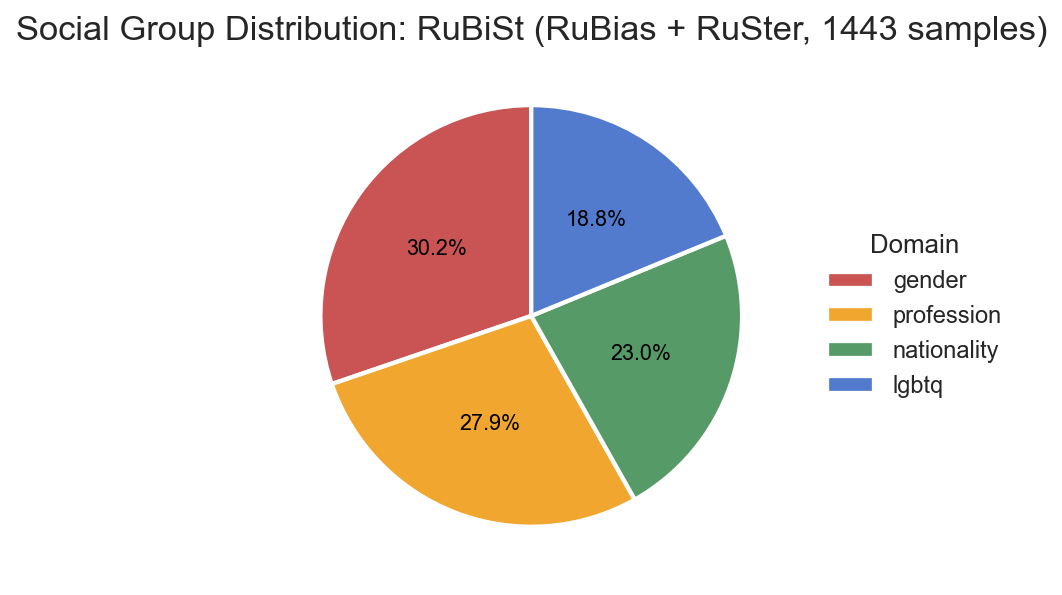

In [33]:
# Plot the pie chart 
pie_chart_domain(rubist_dedup, column='stereotype_type', name = "RuBiSt (RuBias + RuSter, 1443 samples)")

#### Data Augmentation

In [34]:
from dotenv import load_dotenv
load_dotenv()

TEAM_ID = os.getenv("BEDROCK_TEAM_ID")
API_TOKEN = os.getenv("BEDROCK_API_TOKEN")

API_ENDPOINT = "https://ctwa92wg1b.execute-api.us-east-1.amazonaws.com/prod/invoke"
MODEL_ID = "us.anthropic.claude-3-5-sonnet-20241022-v2:0"

# JSON
AUG_SCHEMA = {
    "type": "object",
    "properties": {
        "neutral":   {"type": "string"},
        "unrelated": {"type": "string"}
    },
    "required": ["neutral", "unrelated"]
}

with open("COMP0173_Prompts/prompt.yaml", "r", encoding="utf-8") as f:
    CONFIG = yaml.safe_load(f)

SYSTEM_PROMPT_RU = CONFIG["instructions"]

In [35]:
# Ensure original rows have a label_level column
if "label_level" not in rubist_dedup.columns:
    rubist_dedup["label_level"] = "stereotype"

augmented_rows = []

# Iterate through all selected rows
for _, row in tqdm(rubist_dedup.iterrows(), total=len(rubist_dedup)):
    original_text = row["text"]
    stype = row["stereotype_type"]

    # Store the original stereotype row
    stereo_row = row.copy()
    stereo_row["label_level"] = "stereotype"
    augmented_rows.append(stereo_row)

    # Call the augmentation API
    try:
        aug = augment_sentence_claude(original_text, stype)
    except Exception as e:
        print("\nError while processing example:")
        print(original_text)
        print("Cause:", e)
        continue

    # Neutral version
    neutral_row = row.copy()
    neutral_row["text"] = aug["neutral"]
    neutral_row["label_level"] = "neutral"
    augmented_rows.append(neutral_row)

    # Unrelated version
    unrelated_row = row.copy()
    unrelated_row["text"] = aug["unrelated"]
    unrelated_row["label_level"] = "unrelated"
    augmented_rows.append(unrelated_row)

  0%|          | 1/1433 [00:04<1:48:46,  4.56s/it]

[Quota] LLM=0.125921 | GPU=0.0 | Used=0.125921/50.0 | Remaining=49.874079 | Usage=0.251842%


  0%|          | 2/1433 [00:09<1:55:05,  4.83s/it]

[Quota] LLM=0.13431200000000001 | GPU=0.0 | Used=0.13431200000000001/50.0 | Remaining=49.865688 | Usage=0.26862400000000003%


  0%|          | 3/1433 [00:15<2:04:35,  5.23s/it]

[Quota] LLM=0.142391 | GPU=0.0 | Used=0.142391/50.0 | Remaining=49.857609 | Usage=0.284782%


  0%|          | 4/1433 [00:19<1:54:21,  4.80s/it]

[Quota] LLM=0.15047 | GPU=0.0 | Used=0.15047/50.0 | Remaining=49.84953 | Usage=0.30094%


  0%|          | 5/1433 [00:25<2:07:16,  5.35s/it]

[Quota] LLM=0.158867 | GPU=0.0 | Used=0.158867/50.0 | Remaining=49.841133 | Usage=0.317734%


  0%|          | 6/1433 [00:29<1:53:48,  4.79s/it]

[Quota] LLM=0.16664 | GPU=0.0 | Used=0.16664/50.0 | Remaining=49.83336 | Usage=0.33328%


  0%|          | 7/1433 [00:33<1:51:31,  4.69s/it]

[Quota] LLM=0.174425 | GPU=0.0 | Used=0.174425/50.0 | Remaining=49.825575 | Usage=0.34885%


  1%|          | 8/1433 [00:37<1:39:59,  4.21s/it]

[Quota] LLM=0.18215 | GPU=0.0 | Used=0.18215/50.0 | Remaining=49.81785 | Usage=0.3643%


  1%|          | 9/1433 [00:43<1:57:12,  4.94s/it]

[Quota] LLM=0.189989 | GPU=0.0 | Used=0.189989/50.0 | Remaining=49.810011 | Usage=0.379978%


  1%|          | 10/1433 [00:49<2:01:12,  5.11s/it]

[Quota] LLM=0.198086 | GPU=0.0 | Used=0.198086/50.0 | Remaining=49.801914 | Usage=0.396172%


  1%|          | 11/1433 [00:53<1:55:05,  4.86s/it]

[Quota] LLM=0.205907 | GPU=0.0 | Used=0.205907/50.0 | Remaining=49.794093 | Usage=0.411814%


  1%|          | 12/1433 [00:56<1:44:44,  4.42s/it]

[Quota] LLM=0.213722 | GPU=0.0 | Used=0.213722/50.0 | Remaining=49.786278 | Usage=0.427444%


  1%|          | 13/1433 [01:00<1:40:31,  4.25s/it]

[Quota] LLM=0.221537 | GPU=0.0 | Used=0.221537/50.0 | Remaining=49.778463 | Usage=0.44307399999999997%


  1%|          | 14/1433 [01:05<1:47:29,  4.54s/it]

[Quota] LLM=0.22937 | GPU=0.0 | Used=0.22937/50.0 | Remaining=49.77063 | Usage=0.45874000000000004%


  1%|          | 15/1433 [01:11<1:51:40,  4.72s/it]

[Quota] LLM=0.237935 | GPU=0.0 | Used=0.237935/50.0 | Remaining=49.762065 | Usage=0.47587%


  1%|          | 16/1433 [01:15<1:49:56,  4.66s/it]

[Quota] LLM=0.245792 | GPU=0.0 | Used=0.245792/50.0 | Remaining=49.754208 | Usage=0.491584%


  1%|          | 17/1433 [01:19<1:44:42,  4.44s/it]

[Quota] LLM=0.25355 | GPU=0.0 | Used=0.25355/50.0 | Remaining=49.74645 | Usage=0.5071%


  1%|▏         | 18/1433 [01:24<1:45:16,  4.46s/it]

[Quota] LLM=0.261896 | GPU=0.0 | Used=0.261896/50.0 | Remaining=49.738104 | Usage=0.523792%


  1%|▏         | 19/1433 [01:28<1:46:40,  4.53s/it]

[Quota] LLM=0.269708 | GPU=0.0 | Used=0.269708/50.0 | Remaining=49.730292 | Usage=0.539416%


  1%|▏         | 20/1433 [01:33<1:50:19,  4.68s/it]

[Quota] LLM=0.277799 | GPU=0.0 | Used=0.277799/50.0 | Remaining=49.722201 | Usage=0.555598%


  1%|▏         | 21/1433 [01:37<1:42:55,  4.37s/it]

[Quota] LLM=0.285668 | GPU=0.0 | Used=0.285668/50.0 | Remaining=49.714332 | Usage=0.571336%


  2%|▏         | 22/1433 [01:42<1:47:30,  4.57s/it]

[Quota] LLM=0.29362699999999997 | GPU=0.0 | Used=0.29362699999999997/50.0 | Remaining=49.706373 | Usage=0.5872539999999999%


  2%|▏         | 23/1433 [01:46<1:46:15,  4.52s/it]

[Quota] LLM=0.30143 | GPU=0.0 | Used=0.30143/50.0 | Remaining=49.69857 | Usage=0.60286%


  2%|▏         | 24/1433 [01:50<1:37:59,  4.17s/it]

[Quota] LLM=0.309275 | GPU=0.0 | Used=0.309275/50.0 | Remaining=49.690725 | Usage=0.61855%


  2%|▏         | 25/1433 [01:55<1:47:50,  4.60s/it]

[Quota] LLM=0.317414 | GPU=0.0 | Used=0.317414/50.0 | Remaining=49.682586 | Usage=0.634828%


  2%|▏         | 26/1433 [02:01<1:56:18,  4.96s/it]

[Quota] LLM=0.325208 | GPU=0.0 | Used=0.325208/50.0 | Remaining=49.674792 | Usage=0.650416%


  2%|▏         | 27/1433 [02:06<1:53:35,  4.85s/it]

[Quota] LLM=0.333068 | GPU=0.0 | Used=0.333068/50.0 | Remaining=49.666932 | Usage=0.666136%


  2%|▏         | 28/1433 [02:11<1:56:23,  4.97s/it]

[Quota] LLM=0.34118 | GPU=0.0 | Used=0.34118/50.0 | Remaining=49.65882 | Usage=0.68236%


  2%|▏         | 29/1433 [02:15<1:50:29,  4.72s/it]

[Quota] LLM=0.34901 | GPU=0.0 | Used=0.34901/50.0 | Remaining=49.65099 | Usage=0.69802%


  2%|▏         | 30/1433 [02:18<1:39:17,  4.25s/it]

[Quota] LLM=0.356753 | GPU=0.0 | Used=0.356753/50.0 | Remaining=49.643247 | Usage=0.713506%


  2%|▏         | 31/1433 [02:22<1:38:24,  4.21s/it]

[Quota] LLM=0.364631 | GPU=0.0 | Used=0.364631/50.0 | Remaining=49.635369 | Usage=0.729262%


  2%|▏         | 32/1433 [02:27<1:42:13,  4.38s/it]

[Quota] LLM=0.372614 | GPU=0.0 | Used=0.372614/50.0 | Remaining=49.627386 | Usage=0.745228%


  2%|▏         | 33/1433 [02:32<1:42:16,  4.38s/it]

[Quota] LLM=0.380714 | GPU=0.0 | Used=0.380714/50.0 | Remaining=49.619286 | Usage=0.761428%


  2%|▏         | 34/1433 [02:36<1:43:34,  4.44s/it]

[Quota] LLM=0.388751 | GPU=0.0 | Used=0.388751/50.0 | Remaining=49.611249 | Usage=0.777502%


  2%|▏         | 35/1433 [02:41<1:47:31,  4.61s/it]

[Quota] LLM=0.396863 | GPU=0.0 | Used=0.396863/50.0 | Remaining=49.603137 | Usage=0.7937259999999999%


  3%|▎         | 36/1433 [02:45<1:43:41,  4.45s/it]

[Quota] LLM=0.404609 | GPU=0.0 | Used=0.404609/50.0 | Remaining=49.595391 | Usage=0.8092179999999999%


  3%|▎         | 37/1433 [02:51<1:50:10,  4.74s/it]

[Quota] LLM=0.412697 | GPU=0.0 | Used=0.412697/50.0 | Remaining=49.587303 | Usage=0.825394%


  3%|▎         | 38/1433 [02:55<1:45:52,  4.55s/it]

[Quota] LLM=0.420725 | GPU=0.0 | Used=0.420725/50.0 | Remaining=49.579275 | Usage=0.84145%


  3%|▎         | 39/1433 [02:59<1:40:31,  4.33s/it]

[Quota] LLM=0.428717 | GPU=0.0 | Used=0.428717/50.0 | Remaining=49.571283 | Usage=0.857434%


  3%|▎         | 40/1433 [03:03<1:44:42,  4.51s/it]

[Quota] LLM=0.436586 | GPU=0.0 | Used=0.436586/50.0 | Remaining=49.563414 | Usage=0.8731720000000001%


  3%|▎         | 41/1433 [03:10<1:57:39,  5.07s/it]

[Quota] LLM=0.444641 | GPU=0.0 | Used=0.444641/50.0 | Remaining=49.555359 | Usage=0.8892820000000001%


  3%|▎         | 42/1433 [03:14<1:53:34,  4.90s/it]

[Quota] LLM=0.452522 | GPU=0.0 | Used=0.452522/50.0 | Remaining=49.547478 | Usage=0.905044%


  3%|▎         | 43/1433 [03:18<1:45:59,  4.58s/it]

[Quota] LLM=0.460475 | GPU=0.0 | Used=0.460475/50.0 | Remaining=49.539525 | Usage=0.92095%


  3%|▎         | 44/1433 [03:22<1:40:42,  4.35s/it]

[Quota] LLM=0.468386 | GPU=0.0 | Used=0.468386/50.0 | Remaining=49.531614 | Usage=0.9367720000000002%


  3%|▎         | 45/1433 [03:27<1:44:50,  4.53s/it]

[Quota] LLM=0.476066 | GPU=0.0 | Used=0.476066/50.0 | Remaining=49.523934 | Usage=0.952132%


  3%|▎         | 46/1433 [03:30<1:33:10,  4.03s/it]

[Quota] LLM=0.483731 | GPU=0.0 | Used=0.483731/50.0 | Remaining=49.516269 | Usage=0.967462%


  3%|▎         | 47/1433 [03:34<1:35:32,  4.14s/it]

[Quota] LLM=0.49148000000000003 | GPU=0.0 | Used=0.49148000000000003/50.0 | Remaining=49.50852 | Usage=0.9829600000000001%


  3%|▎         | 48/1433 [03:39<1:37:47,  4.24s/it]

[Quota] LLM=0.499439 | GPU=0.0 | Used=0.499439/50.0 | Remaining=49.500561 | Usage=0.998878%


  3%|▎         | 49/1433 [03:43<1:38:16,  4.26s/it]

[Quota] LLM=0.50723 | GPU=0.0 | Used=0.50723/50.0 | Remaining=49.49277 | Usage=1.01446%


  3%|▎         | 50/1433 [03:47<1:35:33,  4.15s/it]

[Quota] LLM=0.515018 | GPU=0.0 | Used=0.515018/50.0 | Remaining=49.484982 | Usage=1.030036%


  4%|▎         | 51/1433 [03:51<1:37:02,  4.21s/it]

[Quota] LLM=0.52277 | GPU=0.0 | Used=0.52277/50.0 | Remaining=49.47723 | Usage=1.04554%


  4%|▎         | 52/1433 [03:55<1:34:43,  4.12s/it]

[Quota] LLM=0.530231 | GPU=0.0 | Used=0.530231/50.0 | Remaining=49.469769 | Usage=1.060462%


  4%|▎         | 53/1433 [03:58<1:29:48,  3.90s/it]

[Quota] LLM=0.537833 | GPU=0.0 | Used=0.537833/50.0 | Remaining=49.462167 | Usage=1.075666%


  4%|▍         | 54/1433 [04:02<1:30:06,  3.92s/it]

[Quota] LLM=0.545615 | GPU=0.0 | Used=0.545615/50.0 | Remaining=49.454385 | Usage=1.09123%


  4%|▍         | 55/1433 [04:07<1:33:26,  4.07s/it]

[Quota] LLM=0.553769 | GPU=0.0 | Used=0.553769/50.0 | Remaining=49.446231 | Usage=1.107538%


  4%|▍         | 56/1433 [04:12<1:39:38,  4.34s/it]

[Quota] LLM=0.561602 | GPU=0.0 | Used=0.561602/50.0 | Remaining=49.438398 | Usage=1.123204%


  4%|▍         | 57/1433 [04:16<1:37:00,  4.23s/it]

[Quota] LLM=0.569627 | GPU=0.0 | Used=0.569627/50.0 | Remaining=49.430373 | Usage=1.139254%


  4%|▍         | 58/1433 [04:21<1:40:15,  4.37s/it]

[Quota] LLM=0.577775 | GPU=0.0 | Used=0.577775/50.0 | Remaining=49.422225 | Usage=1.15555%


  4%|▍         | 59/1433 [04:24<1:31:23,  3.99s/it]

[Quota] LLM=0.585416 | GPU=0.0 | Used=0.585416/50.0 | Remaining=49.414584 | Usage=1.170832%


  4%|▍         | 60/1433 [04:27<1:28:59,  3.89s/it]

[Quota] LLM=0.593333 | GPU=0.0 | Used=0.593333/50.0 | Remaining=49.406667 | Usage=1.186666%


  4%|▍         | 61/1433 [04:31<1:31:13,  3.99s/it]

[Quota] LLM=0.601316 | GPU=0.0 | Used=0.601316/50.0 | Remaining=49.398684 | Usage=1.202632%


  4%|▍         | 62/1433 [04:36<1:35:53,  4.20s/it]

[Quota] LLM=0.609059 | GPU=0.0 | Used=0.609059/50.0 | Remaining=49.390941 | Usage=1.218118%


  4%|▍         | 63/1433 [04:40<1:35:17,  4.17s/it]

[Quota] LLM=0.616718 | GPU=0.0 | Used=0.616718/50.0 | Remaining=49.383282 | Usage=1.233436%


  4%|▍         | 64/1433 [04:44<1:33:43,  4.11s/it]

[Quota] LLM=0.624515 | GPU=0.0 | Used=0.624515/50.0 | Remaining=49.375485 | Usage=1.24903%


  5%|▍         | 65/1433 [04:48<1:29:38,  3.93s/it]

[Quota] LLM=0.632219 | GPU=0.0 | Used=0.632219/50.0 | Remaining=49.367781 | Usage=1.264438%


  5%|▍         | 66/1433 [04:51<1:23:21,  3.66s/it]

[Quota] LLM=0.639782 | GPU=0.0 | Used=0.639782/50.0 | Remaining=49.360218 | Usage=1.279564%


  5%|▍         | 67/1433 [04:56<1:30:34,  3.98s/it]

[Quota] LLM=0.647621 | GPU=0.0 | Used=0.647621/50.0 | Remaining=49.352379 | Usage=1.295242%


  5%|▍         | 68/1433 [05:00<1:32:17,  4.06s/it]

[Quota] LLM=0.6554 | GPU=0.0 | Used=0.6554/50.0 | Remaining=49.3446 | Usage=1.3108%


  5%|▍         | 69/1433 [05:04<1:33:57,  4.13s/it]

[Quota] LLM=0.663248 | GPU=0.0 | Used=0.663248/50.0 | Remaining=49.336752 | Usage=1.326496%


  5%|▍         | 70/1433 [05:09<1:38:08,  4.32s/it]

[Quota] LLM=0.671018 | GPU=0.0 | Used=0.671018/50.0 | Remaining=49.328982 | Usage=1.342036%


  5%|▍         | 71/1433 [05:12<1:30:36,  3.99s/it]

[Quota] LLM=0.678713 | GPU=0.0 | Used=0.678713/50.0 | Remaining=49.321287 | Usage=1.357426%


  5%|▌         | 72/1433 [05:15<1:25:51,  3.79s/it]

[Quota] LLM=0.68654 | GPU=0.0 | Used=0.68654/50.0 | Remaining=49.31346 | Usage=1.37308%


  5%|▌         | 73/1433 [05:20<1:30:49,  4.01s/it]

[Quota] LLM=0.694358 | GPU=0.0 | Used=0.694358/50.0 | Remaining=49.305642 | Usage=1.388716%


  5%|▌         | 74/1433 [05:24<1:32:11,  4.07s/it]

[Quota] LLM=0.70214 | GPU=0.0 | Used=0.70214/50.0 | Remaining=49.29786 | Usage=1.40428%


  5%|▌         | 75/1433 [05:28<1:28:18,  3.90s/it]

[Quota] LLM=0.710054 | GPU=0.0 | Used=0.710054/50.0 | Remaining=49.289946 | Usage=1.420108%


  5%|▌         | 76/1433 [05:32<1:28:11,  3.90s/it]

[Quota] LLM=0.717686 | GPU=0.0 | Used=0.717686/50.0 | Remaining=49.282314 | Usage=1.435372%


  5%|▌         | 77/1433 [05:35<1:26:10,  3.81s/it]

[Quota] LLM=0.725714 | GPU=0.0 | Used=0.725714/50.0 | Remaining=49.274286000000004 | Usage=1.451428%


  5%|▌         | 78/1433 [05:40<1:32:39,  4.10s/it]

[Quota] LLM=0.73385 | GPU=0.0 | Used=0.73385/50.0 | Remaining=49.26615 | Usage=1.4677%


  6%|▌         | 79/1433 [05:44<1:35:45,  4.24s/it]

[Quota] LLM=0.741851 | GPU=0.0 | Used=0.741851/50.0 | Remaining=49.258149 | Usage=1.483702%


  6%|▌         | 80/1433 [05:48<1:31:26,  4.06s/it]

[Quota] LLM=0.749702 | GPU=0.0 | Used=0.749702/50.0 | Remaining=49.250298 | Usage=1.499404%


  6%|▌         | 81/1433 [05:52<1:28:35,  3.93s/it]

[Quota] LLM=0.757514 | GPU=0.0 | Used=0.757514/50.0 | Remaining=49.242486 | Usage=1.515028%


  6%|▌         | 82/1433 [05:57<1:40:10,  4.45s/it]

[Quota] LLM=0.765338 | GPU=0.0 | Used=0.765338/50.0 | Remaining=49.234662 | Usage=1.530676%


  6%|▌         | 83/1433 [06:02<1:38:58,  4.40s/it]

[Quota] LLM=0.773168 | GPU=0.0 | Used=0.773168/50.0 | Remaining=49.226832 | Usage=1.546336%


  6%|▌         | 84/1433 [06:08<1:49:27,  4.87s/it]

[Quota] LLM=0.781529 | GPU=0.0 | Used=0.781529/50.0 | Remaining=49.218471 | Usage=1.563058%


  6%|▌         | 85/1433 [06:12<1:45:58,  4.72s/it]

[Quota] LLM=0.789539 | GPU=0.0 | Used=0.789539/50.0 | Remaining=49.210461 | Usage=1.579078%


  6%|▌         | 86/1433 [06:18<1:54:07,  5.08s/it]

[Quota] LLM=0.797879 | GPU=0.0 | Used=0.797879/50.0 | Remaining=49.202121 | Usage=1.595758%


  6%|▌         | 87/1433 [06:22<1:45:38,  4.71s/it]

[Quota] LLM=0.806099 | GPU=0.0 | Used=0.806099/50.0 | Remaining=49.193901 | Usage=1.612198%


  6%|▌         | 88/1433 [06:26<1:44:07,  4.64s/it]

[Quota] LLM=0.813887 | GPU=0.0 | Used=0.813887/50.0 | Remaining=49.186113 | Usage=1.6277739999999998%


  6%|▌         | 89/1433 [06:31<1:46:49,  4.77s/it]

[Quota] LLM=0.821807 | GPU=0.0 | Used=0.821807/50.0 | Remaining=49.178193 | Usage=1.643614%


  6%|▋         | 90/1433 [06:36<1:43:02,  4.60s/it]

[Quota] LLM=0.829958 | GPU=0.0 | Used=0.829958/50.0 | Remaining=49.170042 | Usage=1.6599159999999997%


  6%|▋         | 91/1433 [06:40<1:38:45,  4.42s/it]

[Quota] LLM=0.837842 | GPU=0.0 | Used=0.837842/50.0 | Remaining=49.162158 | Usage=1.675684%


  6%|▋         | 92/1433 [06:44<1:37:56,  4.38s/it]

[Quota] LLM=0.845894 | GPU=0.0 | Used=0.845894/50.0 | Remaining=49.154106 | Usage=1.691788%


  6%|▋         | 93/1433 [06:50<1:47:40,  4.82s/it]

[Quota] LLM=0.854165 | GPU=0.0 | Used=0.854165/50.0 | Remaining=49.145835 | Usage=1.70833%


  7%|▋         | 94/1433 [06:54<1:41:01,  4.53s/it]

[Quota] LLM=0.862091 | GPU=0.0 | Used=0.862091/50.0 | Remaining=49.137909 | Usage=1.724182%


  7%|▋         | 95/1433 [06:57<1:32:12,  4.14s/it]

[Quota] LLM=0.870029 | GPU=0.0 | Used=0.870029/50.0 | Remaining=49.129971 | Usage=1.7400580000000003%


  7%|▋         | 96/1433 [07:01<1:29:53,  4.03s/it]

[Quota] LLM=0.877658 | GPU=0.0 | Used=0.877658/50.0 | Remaining=49.122342 | Usage=1.755316%


  7%|▋         | 97/1433 [07:05<1:31:21,  4.10s/it]

[Quota] LLM=0.885923 | GPU=0.0 | Used=0.885923/50.0 | Remaining=49.114077 | Usage=1.7718460000000003%


  7%|▋         | 98/1433 [07:08<1:24:18,  3.79s/it]

[Quota] LLM=0.893417 | GPU=0.0 | Used=0.893417/50.0 | Remaining=49.106583 | Usage=1.786834%


  7%|▋         | 99/1433 [07:12<1:29:40,  4.03s/it]

[Quota] LLM=0.901421 | GPU=0.0 | Used=0.901421/50.0 | Remaining=49.098579 | Usage=1.802842%


  7%|▋         | 100/1433 [07:16<1:27:00,  3.92s/it]

[Quota] LLM=0.909098 | GPU=0.0 | Used=0.909098/50.0 | Remaining=49.090902 | Usage=1.8181960000000001%


  7%|▋         | 101/1433 [07:20<1:27:02,  3.92s/it]

[Quota] LLM=0.916904 | GPU=0.0 | Used=0.916904/50.0 | Remaining=49.083096 | Usage=1.8338079999999999%


  7%|▋         | 102/1433 [07:24<1:28:49,  4.00s/it]

[Quota] LLM=0.924659 | GPU=0.0 | Used=0.924659/50.0 | Remaining=49.075341 | Usage=1.8493180000000002%


  7%|▋         | 103/1433 [07:29<1:34:44,  4.27s/it]

[Quota] LLM=0.932567 | GPU=0.0 | Used=0.932567/50.0 | Remaining=49.067433 | Usage=1.8651340000000003%


  7%|▋         | 104/1433 [07:34<1:36:51,  4.37s/it]

[Quota] LLM=0.940655 | GPU=0.0 | Used=0.940655/50.0 | Remaining=49.059345 | Usage=1.88131%


  7%|▋         | 105/1433 [07:40<1:49:28,  4.95s/it]

[Quota] LLM=0.948626 | GPU=0.0 | Used=0.948626/50.0 | Remaining=49.051374 | Usage=1.897252%


  7%|▋         | 106/1433 [07:45<1:47:32,  4.86s/it]

[Quota] LLM=0.956447 | GPU=0.0 | Used=0.956447/50.0 | Remaining=49.043553 | Usage=1.912894%


  7%|▋         | 107/1433 [07:49<1:40:38,  4.55s/it]

[Quota] LLM=0.964478 | GPU=0.0 | Used=0.964478/50.0 | Remaining=49.035522 | Usage=1.9289559999999997%


  8%|▊         | 108/1433 [07:53<1:40:04,  4.53s/it]

[Quota] LLM=0.972287 | GPU=0.0 | Used=0.972287/50.0 | Remaining=49.027713 | Usage=1.944574%


  8%|▊         | 109/1433 [07:59<1:46:44,  4.84s/it]

[Quota] LLM=0.980396 | GPU=0.0 | Used=0.980396/50.0 | Remaining=49.019604 | Usage=1.960792%


  8%|▊         | 110/1433 [08:04<1:50:23,  5.01s/it]

[Quota] LLM=0.988319 | GPU=0.0 | Used=0.988319/50.0 | Remaining=49.011681 | Usage=1.976638%


  8%|▊         | 111/1433 [08:10<1:55:50,  5.26s/it]

[Quota] LLM=0.996629 | GPU=0.0 | Used=0.996629/50.0 | Remaining=49.003371 | Usage=1.9932579999999998%


  8%|▊         | 112/1433 [08:14<1:49:25,  4.97s/it]

[Quota] LLM=1.00466 | GPU=0.0 | Used=1.00466/50.0 | Remaining=48.99534 | Usage=2.00932%


  8%|▊         | 113/1433 [08:19<1:48:37,  4.94s/it]

[Quota] LLM=1.01264 | GPU=0.0 | Used=1.01264/50.0 | Remaining=48.98736 | Usage=2.02528%


  8%|▊         | 114/1433 [08:24<1:49:43,  4.99s/it]

[Quota] LLM=1.020485 | GPU=0.0 | Used=1.020485/50.0 | Remaining=48.979515 | Usage=2.04097%


  8%|▊         | 115/1433 [08:29<1:47:12,  4.88s/it]

[Quota] LLM=1.028426 | GPU=0.0 | Used=1.028426/50.0 | Remaining=48.971574 | Usage=2.056852%


  8%|▊         | 116/1433 [08:34<1:51:12,  5.07s/it]

[Quota] LLM=1.036445 | GPU=0.0 | Used=1.036445/50.0 | Remaining=48.963555 | Usage=2.07289%


  8%|▊         | 117/1433 [08:39<1:50:42,  5.05s/it]

[Quota] LLM=1.04501 | GPU=0.0 | Used=1.04501/50.0 | Remaining=48.95499 | Usage=2.09002%


  8%|▊         | 118/1433 [08:45<1:53:53,  5.20s/it]

[Quota] LLM=1.053155 | GPU=0.0 | Used=1.053155/50.0 | Remaining=48.946845 | Usage=2.10631%


  8%|▊         | 119/1433 [08:49<1:47:38,  4.92s/it]

[Quota] LLM=1.060826 | GPU=0.0 | Used=1.060826/50.0 | Remaining=48.939174 | Usage=2.121652%


  8%|▊         | 120/1433 [08:54<1:45:23,  4.82s/it]

[Quota] LLM=1.068797 | GPU=0.0 | Used=1.068797/50.0 | Remaining=48.931203 | Usage=2.137594%


  8%|▊         | 121/1433 [08:57<1:35:24,  4.36s/it]

[Quota] LLM=1.076471 | GPU=0.0 | Used=1.076471/50.0 | Remaining=48.923529 | Usage=2.152942%


  9%|▊         | 122/1433 [09:07<2:14:39,  6.16s/it]

[Quota] LLM=1.084658 | GPU=0.0 | Used=1.084658/50.0 | Remaining=48.915342 | Usage=2.169316%


  9%|▊         | 123/1433 [09:11<2:01:25,  5.56s/it]

[Quota] LLM=1.092599 | GPU=0.0 | Used=1.092599/50.0 | Remaining=48.907401 | Usage=2.185198%


  9%|▊         | 124/1433 [09:15<1:50:26,  5.06s/it]

[Quota] LLM=1.100516 | GPU=0.0 | Used=1.100516/50.0 | Remaining=48.899484 | Usage=2.201032%


  9%|▊         | 125/1433 [09:20<1:49:05,  5.00s/it]

[Quota] LLM=1.108652 | GPU=0.0 | Used=1.108652/50.0 | Remaining=48.891348 | Usage=2.217304%


  9%|▉         | 126/1433 [09:23<1:38:00,  4.50s/it]

[Quota] LLM=1.116629 | GPU=0.0 | Used=1.116629/50.0 | Remaining=48.883371 | Usage=2.233258%


  9%|▉         | 127/1433 [09:28<1:38:02,  4.50s/it]

[Quota] LLM=1.1246 | GPU=0.0 | Used=1.1246/50.0 | Remaining=48.8754 | Usage=2.2492%


  9%|▉         | 128/1433 [09:32<1:33:19,  4.29s/it]

[Quota] LLM=1.132499 | GPU=0.0 | Used=1.132499/50.0 | Remaining=48.867501 | Usage=2.264998%


  9%|▉         | 129/1433 [09:38<1:43:17,  4.75s/it]

[Quota] LLM=1.1406020000000001 | GPU=0.0 | Used=1.1406020000000001/50.0 | Remaining=48.859398 | Usage=2.2812040000000002%


  9%|▉         | 130/1433 [09:42<1:40:07,  4.61s/it]

[Quota] LLM=1.148645 | GPU=0.0 | Used=1.148645/50.0 | Remaining=48.851355 | Usage=2.29729%


  9%|▉         | 131/1433 [09:46<1:36:29,  4.45s/it]

[Quota] LLM=1.156679 | GPU=0.0 | Used=1.156679/50.0 | Remaining=48.843321 | Usage=2.313358%


  9%|▉         | 132/1433 [09:50<1:34:56,  4.38s/it]

[Quota] LLM=1.164896 | GPU=0.0 | Used=1.164896/50.0 | Remaining=48.835104 | Usage=2.329792%


  9%|▉         | 133/1433 [09:54<1:34:01,  4.34s/it]

[Quota] LLM=1.172786 | GPU=0.0 | Used=1.172786/50.0 | Remaining=48.827214 | Usage=2.345572%


  9%|▉         | 134/1433 [09:59<1:38:21,  4.54s/it]

[Quota] LLM=1.18097 | GPU=0.0 | Used=1.18097/50.0 | Remaining=48.81903 | Usage=2.36194%


  9%|▉         | 135/1433 [10:04<1:39:29,  4.60s/it]

[Quota] LLM=1.18892 | GPU=0.0 | Used=1.18892/50.0 | Remaining=48.81108 | Usage=2.37784%


  9%|▉         | 136/1433 [10:09<1:40:52,  4.67s/it]

[Quota] LLM=1.19702 | GPU=0.0 | Used=1.19702/50.0 | Remaining=48.80298 | Usage=2.39404%


 10%|▉         | 137/1433 [10:13<1:37:50,  4.53s/it]

[Quota] LLM=1.205048 | GPU=0.0 | Used=1.205048/50.0 | Remaining=48.794952 | Usage=2.410096%


 10%|▉         | 138/1433 [10:18<1:38:12,  4.55s/it]

[Quota] LLM=1.2131 | GPU=0.0 | Used=1.2131/50.0 | Remaining=48.7869 | Usage=2.4262%


 10%|▉         | 139/1433 [10:22<1:38:28,  4.57s/it]

[Quota] LLM=1.220912 | GPU=0.0 | Used=1.220912/50.0 | Remaining=48.779088 | Usage=2.441824%


 10%|▉         | 140/1433 [10:26<1:35:02,  4.41s/it]

[Quota] LLM=1.228913 | GPU=0.0 | Used=1.228913/50.0 | Remaining=48.771087 | Usage=2.457826%


 10%|▉         | 141/1433 [10:31<1:34:48,  4.40s/it]

[Quota] LLM=1.236974 | GPU=0.0 | Used=1.236974/50.0 | Remaining=48.763025999999996 | Usage=2.473948%


 10%|▉         | 142/1433 [10:36<1:38:03,  4.56s/it]

[Quota] LLM=1.245092 | GPU=0.0 | Used=1.245092/50.0 | Remaining=48.754908 | Usage=2.490184%


 10%|▉         | 143/1433 [10:41<1:41:50,  4.74s/it]

[Quota] LLM=1.253249 | GPU=0.0 | Used=1.253249/50.0 | Remaining=48.746751 | Usage=2.506498%


 10%|█         | 144/1433 [10:46<1:46:58,  4.98s/it]

[Quota] LLM=1.261328 | GPU=0.0 | Used=1.261328/50.0 | Remaining=48.738672 | Usage=2.522656%


 10%|█         | 145/1433 [10:51<1:45:23,  4.91s/it]

[Quota] LLM=1.26965 | GPU=0.0 | Used=1.26965/50.0 | Remaining=48.73035 | Usage=2.5393%


 10%|█         | 146/1433 [10:56<1:42:08,  4.76s/it]

[Quota] LLM=1.277975 | GPU=0.0 | Used=1.277975/50.0 | Remaining=48.722025 | Usage=2.55595%


 10%|█         | 147/1433 [11:00<1:39:19,  4.63s/it]

[Quota] LLM=1.286156 | GPU=0.0 | Used=1.286156/50.0 | Remaining=48.713844 | Usage=2.572312%


 10%|█         | 148/1433 [11:06<1:44:58,  4.90s/it]

[Quota] LLM=1.294268 | GPU=0.0 | Used=1.294268/50.0 | Remaining=48.705732 | Usage=2.588536%


 10%|█         | 149/1433 [11:11<1:45:56,  4.95s/it]

[Quota] LLM=1.30226 | GPU=0.0 | Used=1.30226/50.0 | Remaining=48.69774 | Usage=2.60452%


 10%|█         | 150/1433 [11:14<1:36:34,  4.52s/it]

[Quota] LLM=1.309967 | GPU=0.0 | Used=1.309967/50.0 | Remaining=48.690033 | Usage=2.619934%


 11%|█         | 151/1433 [11:20<1:43:22,  4.84s/it]

[Quota] LLM=1.318079 | GPU=0.0 | Used=1.318079/50.0 | Remaining=48.681921 | Usage=2.636158%


 11%|█         | 152/1433 [11:25<1:46:51,  5.01s/it]

[Quota] LLM=1.326053 | GPU=0.0 | Used=1.326053/50.0 | Remaining=48.673947 | Usage=2.652106%


 11%|█         | 153/1433 [11:31<1:55:58,  5.44s/it]

[Quota] LLM=1.334144 | GPU=0.0 | Used=1.334144/50.0 | Remaining=48.665856 | Usage=2.668288%


 11%|█         | 154/1433 [11:38<2:00:59,  5.68s/it]

[Quota] LLM=1.342682 | GPU=0.0 | Used=1.342682/50.0 | Remaining=48.657318000000004 | Usage=2.685364%


 11%|█         | 155/1433 [11:42<1:50:43,  5.20s/it]

[Quota] LLM=1.350482 | GPU=0.0 | Used=1.350482/50.0 | Remaining=48.649518 | Usage=2.700964%


 11%|█         | 156/1433 [11:49<2:00:13,  5.65s/it]

[Quota] LLM=1.358477 | GPU=0.0 | Used=1.358477/50.0 | Remaining=48.641523 | Usage=2.716954%


 11%|█         | 157/1433 [11:53<1:50:47,  5.21s/it]

[Quota] LLM=1.366481 | GPU=0.0 | Used=1.366481/50.0 | Remaining=48.633519 | Usage=2.732962%


 11%|█         | 158/1433 [11:57<1:43:48,  4.89s/it]

[Quota] LLM=1.374257 | GPU=0.0 | Used=1.374257/50.0 | Remaining=48.625743 | Usage=2.748514%


 11%|█         | 159/1433 [12:02<1:45:49,  4.98s/it]

[Quota] LLM=1.38227 | GPU=0.0 | Used=1.38227/50.0 | Remaining=48.61773 | Usage=2.76454%


 11%|█         | 160/1433 [12:07<1:44:22,  4.92s/it]

[Quota] LLM=1.39037 | GPU=0.0 | Used=1.39037/50.0 | Remaining=48.60963 | Usage=2.78074%


 11%|█         | 161/1433 [12:11<1:38:42,  4.66s/it]

[Quota] LLM=1.398455 | GPU=0.0 | Used=1.398455/50.0 | Remaining=48.601545 | Usage=2.79691%


 11%|█▏        | 162/1433 [12:15<1:38:30,  4.65s/it]

[Quota] LLM=1.406348 | GPU=0.0 | Used=1.406348/50.0 | Remaining=48.593652 | Usage=2.812696%


 11%|█▏        | 163/1433 [12:20<1:34:38,  4.47s/it]

[Quota] LLM=1.414073 | GPU=0.0 | Used=1.414073/50.0 | Remaining=48.585927 | Usage=2.828146%


 11%|█▏        | 164/1433 [12:24<1:35:36,  4.52s/it]

[Quota] LLM=1.421984 | GPU=0.0 | Used=1.421984/50.0 | Remaining=48.578016 | Usage=2.843968%


 12%|█▏        | 165/1433 [12:29<1:39:02,  4.69s/it]

[Quota] LLM=1.4298710000000001 | GPU=0.0 | Used=1.4298710000000001/50.0 | Remaining=48.570129 | Usage=2.8597420000000002%


 12%|█▏        | 166/1433 [12:34<1:37:11,  4.60s/it]

[Quota] LLM=1.437539 | GPU=0.0 | Used=1.437539/50.0 | Remaining=48.562461 | Usage=2.875078%


 12%|█▏        | 167/1433 [12:38<1:35:08,  4.51s/it]

[Quota] LLM=1.445576 | GPU=0.0 | Used=1.445576/50.0 | Remaining=48.554424 | Usage=2.891152%


 12%|█▏        | 168/1433 [12:42<1:32:59,  4.41s/it]

[Quota] LLM=1.453559 | GPU=0.0 | Used=1.453559/50.0 | Remaining=48.546441 | Usage=2.907118%


 12%|█▏        | 169/1433 [12:47<1:34:33,  4.49s/it]

[Quota] LLM=1.461563 | GPU=0.0 | Used=1.461563/50.0 | Remaining=48.538437 | Usage=2.923126%


 12%|█▏        | 170/1433 [12:51<1:30:30,  4.30s/it]

[Quota] LLM=1.46948 | GPU=0.0 | Used=1.46948/50.0 | Remaining=48.53052 | Usage=2.93896%


 12%|█▏        | 171/1433 [12:56<1:34:44,  4.50s/it]

[Quota] LLM=1.47752 | GPU=0.0 | Used=1.47752/50.0 | Remaining=48.52248 | Usage=2.95504%


 12%|█▏        | 172/1433 [12:59<1:28:15,  4.20s/it]

[Quota] LLM=1.485242 | GPU=0.0 | Used=1.485242/50.0 | Remaining=48.514758 | Usage=2.970484%


 12%|█▏        | 173/1433 [13:04<1:33:45,  4.46s/it]

[Quota] LLM=1.493129 | GPU=0.0 | Used=1.493129/50.0 | Remaining=48.506871 | Usage=2.986258%


 12%|█▏        | 174/1433 [13:07<1:25:46,  4.09s/it]

[Quota] LLM=1.500875 | GPU=0.0 | Used=1.500875/50.0 | Remaining=48.499125 | Usage=3.00175%


 12%|█▏        | 175/1433 [13:13<1:32:59,  4.44s/it]

[Quota] LLM=1.508861 | GPU=0.0 | Used=1.508861/50.0 | Remaining=48.491139 | Usage=3.017722%


 12%|█▏        | 176/1433 [13:18<1:38:45,  4.71s/it]

[Quota] LLM=1.516475 | GPU=0.0 | Used=1.516475/50.0 | Remaining=48.483525 | Usage=3.03295%


 12%|█▏        | 177/1433 [13:21<1:30:09,  4.31s/it]

[Quota] LLM=1.524191 | GPU=0.0 | Used=1.524191/50.0 | Remaining=48.475809 | Usage=3.048382%


 12%|█▏        | 178/1433 [13:28<1:45:21,  5.04s/it]

[Quota] LLM=1.532042 | GPU=0.0 | Used=1.532042/50.0 | Remaining=48.467958 | Usage=3.064084%


 12%|█▏        | 179/1433 [13:32<1:34:56,  4.54s/it]

[Quota] LLM=1.539716 | GPU=0.0 | Used=1.539716/50.0 | Remaining=48.460284 | Usage=3.079432%


 13%|█▎        | 180/1433 [13:37<1:43:41,  4.97s/it]

[Quota] LLM=1.54772 | GPU=0.0 | Used=1.54772/50.0 | Remaining=48.45228 | Usage=3.09544%


 13%|█▎        | 181/1433 [13:43<1:47:10,  5.14s/it]

[Quota] LLM=1.555571 | GPU=0.0 | Used=1.555571/50.0 | Remaining=48.444429 | Usage=3.111142%


 13%|█▎        | 182/1433 [13:47<1:36:54,  4.65s/it]

[Quota] LLM=1.563608 | GPU=0.0 | Used=1.563608/50.0 | Remaining=48.436392 | Usage=3.127216%


 13%|█▎        | 183/1433 [13:51<1:33:07,  4.47s/it]

[Quota] LLM=1.571348 | GPU=0.0 | Used=1.571348/50.0 | Remaining=48.428652 | Usage=3.1426959999999995%


 13%|█▎        | 184/1433 [13:55<1:35:15,  4.58s/it]

[Quota] LLM=1.579583 | GPU=0.0 | Used=1.579583/50.0 | Remaining=48.420417 | Usage=3.159166%


 13%|█▎        | 185/1433 [13:59<1:28:03,  4.23s/it]

[Quota] LLM=1.587302 | GPU=0.0 | Used=1.587302/50.0 | Remaining=48.412698 | Usage=3.1746040000000004%


 13%|█▎        | 186/1433 [14:04<1:33:27,  4.50s/it]

[Quota] LLM=1.595453 | GPU=0.0 | Used=1.595453/50.0 | Remaining=48.404547 | Usage=3.1909060000000005%


 13%|█▎        | 187/1433 [14:08<1:33:36,  4.51s/it]

[Quota] LLM=1.603379 | GPU=0.0 | Used=1.603379/50.0 | Remaining=48.396621 | Usage=3.2067580000000007%


 13%|█▎        | 188/1433 [14:13<1:31:44,  4.42s/it]

[Quota] LLM=1.611632 | GPU=0.0 | Used=1.611632/50.0 | Remaining=48.388368 | Usage=3.223264%


 13%|█▎        | 189/1433 [14:18<1:35:41,  4.62s/it]

[Quota] LLM=1.619534 | GPU=0.0 | Used=1.619534/50.0 | Remaining=48.380466 | Usage=3.2390679999999996%


 13%|█▎        | 190/1433 [14:22<1:34:29,  4.56s/it]

[Quota] LLM=1.627433 | GPU=0.0 | Used=1.627433/50.0 | Remaining=48.372567000000004 | Usage=3.254866%


 13%|█▎        | 191/1433 [14:26<1:31:51,  4.44s/it]

[Quota] LLM=1.635257 | GPU=0.0 | Used=1.635257/50.0 | Remaining=48.364743 | Usage=3.270514%


 13%|█▎        | 192/1433 [14:30<1:29:33,  4.33s/it]

[Quota] LLM=1.643033 | GPU=0.0 | Used=1.643033/50.0 | Remaining=48.356967 | Usage=3.286066%


 13%|█▎        | 193/1433 [14:36<1:37:32,  4.72s/it]

[Quota] LLM=1.650857 | GPU=0.0 | Used=1.650857/50.0 | Remaining=48.349143 | Usage=3.301714%


 14%|█▎        | 194/1433 [14:40<1:35:02,  4.60s/it]

[Quota] LLM=1.658597 | GPU=0.0 | Used=1.658597/50.0 | Remaining=48.341403 | Usage=3.317194%


 14%|█▎        | 195/1433 [14:45<1:34:07,  4.56s/it]

[Quota] LLM=1.666499 | GPU=0.0 | Used=1.666499/50.0 | Remaining=48.333501 | Usage=3.3329980000000003%


 14%|█▎        | 196/1433 [14:49<1:32:36,  4.49s/it]

[Quota] LLM=1.674434 | GPU=0.0 | Used=1.674434/50.0 | Remaining=48.325566 | Usage=3.348868%


 14%|█▎        | 197/1433 [14:54<1:34:56,  4.61s/it]

[Quota] LLM=1.682525 | GPU=0.0 | Used=1.682525/50.0 | Remaining=48.317475 | Usage=3.36505%


 14%|█▍        | 198/1433 [14:59<1:37:03,  4.72s/it]

[Quota] LLM=1.690913 | GPU=0.0 | Used=1.690913/50.0 | Remaining=48.309087 | Usage=3.381826%


 14%|█▍        | 199/1433 [15:03<1:32:11,  4.48s/it]

[Quota] LLM=1.698671 | GPU=0.0 | Used=1.698671/50.0 | Remaining=48.301329 | Usage=3.3973420000000005%


 14%|█▍        | 200/1433 [15:10<1:45:08,  5.12s/it]

[Quota] LLM=1.706501 | GPU=0.0 | Used=1.706501/50.0 | Remaining=48.293499 | Usage=3.4130020000000005%


 14%|█▍        | 201/1433 [15:16<1:50:16,  5.37s/it]

[Quota] LLM=1.714328 | GPU=0.0 | Used=1.714328/50.0 | Remaining=48.285672 | Usage=3.428656%


 14%|█▍        | 202/1433 [15:20<1:45:12,  5.13s/it]

[Quota] LLM=1.722461 | GPU=0.0 | Used=1.722461/50.0 | Remaining=48.277539 | Usage=3.444922%


 14%|█▍        | 203/1433 [15:24<1:39:10,  4.84s/it]

[Quota] LLM=1.7303 | GPU=0.0 | Used=1.7303/50.0 | Remaining=48.2697 | Usage=3.4606%


 14%|█▍        | 204/1433 [15:27<1:28:01,  4.30s/it]

[Quota] LLM=1.738073 | GPU=0.0 | Used=1.738073/50.0 | Remaining=48.261927 | Usage=3.476146%


 14%|█▍        | 205/1433 [15:31<1:25:40,  4.19s/it]

[Quota] LLM=1.745828 | GPU=0.0 | Used=1.745828/50.0 | Remaining=48.254172 | Usage=3.491656%


 14%|█▍        | 206/1433 [15:36<1:27:41,  4.29s/it]

[Quota] LLM=1.753667 | GPU=0.0 | Used=1.753667/50.0 | Remaining=48.246333 | Usage=3.507334%


 14%|█▍        | 207/1433 [15:39<1:23:20,  4.08s/it]

[Quota] LLM=1.761632 | GPU=0.0 | Used=1.761632/50.0 | Remaining=48.238368 | Usage=3.523264%


 15%|█▍        | 208/1433 [15:45<1:30:19,  4.42s/it]

[Quota] LLM=1.769645 | GPU=0.0 | Used=1.769645/50.0 | Remaining=48.230355 | Usage=3.53929%


 15%|█▍        | 209/1433 [15:49<1:28:40,  4.35s/it]

[Quota] LLM=1.777544 | GPU=0.0 | Used=1.777544/50.0 | Remaining=48.222456 | Usage=3.555088%


 15%|█▍        | 210/1433 [15:53<1:26:25,  4.24s/it]

[Quota] LLM=1.785197 | GPU=0.0 | Used=1.785197/50.0 | Remaining=48.214803 | Usage=3.570394%


 15%|█▍        | 211/1433 [15:57<1:26:41,  4.26s/it]

[Quota] LLM=1.793144 | GPU=0.0 | Used=1.793144/50.0 | Remaining=48.206856 | Usage=3.586288%


 15%|█▍        | 212/1433 [16:02<1:32:31,  4.55s/it]

[Quota] LLM=1.801223 | GPU=0.0 | Used=1.801223/50.0 | Remaining=48.198777 | Usage=3.602446%


 15%|█▍        | 213/1433 [16:06<1:30:09,  4.43s/it]

[Quota] LLM=1.809215 | GPU=0.0 | Used=1.809215/50.0 | Remaining=48.190785 | Usage=3.61843%


 15%|█▍        | 214/1433 [16:11<1:30:09,  4.44s/it]

[Quota] LLM=1.817126 | GPU=0.0 | Used=1.817126/50.0 | Remaining=48.182874 | Usage=3.6342520000000005%


 15%|█▌        | 215/1433 [16:15<1:30:41,  4.47s/it]

[Quota] LLM=1.824965 | GPU=0.0 | Used=1.824965/50.0 | Remaining=48.175035 | Usage=3.64993%


 15%|█▌        | 216/1433 [16:19<1:27:31,  4.32s/it]

[Quota] LLM=1.83266 | GPU=0.0 | Used=1.83266/50.0 | Remaining=48.16734 | Usage=3.6653199999999995%


 15%|█▌        | 217/1433 [16:24<1:30:15,  4.45s/it]

[Quota] LLM=1.840574 | GPU=0.0 | Used=1.840574/50.0 | Remaining=48.159426 | Usage=3.681148%


 15%|█▌        | 218/1433 [16:29<1:32:51,  4.59s/it]

[Quota] LLM=1.848386 | GPU=0.0 | Used=1.848386/50.0 | Remaining=48.151614 | Usage=3.696772%


 15%|█▌        | 219/1433 [16:34<1:36:08,  4.75s/it]

[Quota] LLM=1.856948 | GPU=0.0 | Used=1.856948/50.0 | Remaining=48.143052 | Usage=3.713896%


 15%|█▌        | 220/1433 [16:39<1:34:27,  4.67s/it]

[Quota] LLM=1.864856 | GPU=0.0 | Used=1.864856/50.0 | Remaining=48.135144 | Usage=3.729712%


 15%|█▌        | 221/1433 [16:45<1:42:27,  5.07s/it]

[Quota] LLM=1.872983 | GPU=0.0 | Used=1.872983/50.0 | Remaining=48.127017 | Usage=3.7459659999999997%


 15%|█▌        | 222/1433 [16:51<1:47:30,  5.33s/it]

[Quota] LLM=1.880747 | GPU=0.0 | Used=1.880747/50.0 | Remaining=48.119253 | Usage=3.761494%


 16%|█▌        | 223/1433 [16:55<1:39:02,  4.91s/it]

[Quota] LLM=1.888424 | GPU=0.0 | Used=1.888424/50.0 | Remaining=48.111576 | Usage=3.776848%


 16%|█▌        | 224/1433 [16:59<1:37:33,  4.84s/it]

[Quota] LLM=1.896875 | GPU=0.0 | Used=1.896875/50.0 | Remaining=48.103125 | Usage=3.7937499999999997%


 16%|█▌        | 225/1433 [17:04<1:34:37,  4.70s/it]

[Quota] LLM=1.904795 | GPU=0.0 | Used=1.904795/50.0 | Remaining=48.095205 | Usage=3.80959%


 16%|█▌        | 226/1433 [17:07<1:26:34,  4.30s/it]

[Quota] LLM=1.91261 | GPU=0.0 | Used=1.91261/50.0 | Remaining=48.08739 | Usage=3.82522%


 16%|█▌        | 227/1433 [17:11<1:28:00,  4.38s/it]

[Quota] LLM=1.9204430000000001 | GPU=0.0 | Used=1.9204430000000001/50.0 | Remaining=48.079557 | Usage=3.8408860000000002%


 16%|█▌        | 228/1433 [17:15<1:25:35,  4.26s/it]

[Quota] LLM=1.92806 | GPU=0.0 | Used=1.92806/50.0 | Remaining=48.07194 | Usage=3.85612%


 16%|█▌        | 229/1433 [17:20<1:29:28,  4.46s/it]

[Quota] LLM=1.935806 | GPU=0.0 | Used=1.935806/50.0 | Remaining=48.064194 | Usage=3.871612%


 16%|█▌        | 230/1433 [17:24<1:27:11,  4.35s/it]

[Quota] LLM=1.943708 | GPU=0.0 | Used=1.943708/50.0 | Remaining=48.056292 | Usage=3.887416%


 16%|█▌        | 231/1433 [17:29<1:27:33,  4.37s/it]

[Quota] LLM=1.951382 | GPU=0.0 | Used=1.951382/50.0 | Remaining=48.048618 | Usage=3.9027640000000003%


 16%|█▌        | 232/1433 [17:33<1:23:45,  4.18s/it]

[Quota] LLM=1.959092 | GPU=0.0 | Used=1.959092/50.0 | Remaining=48.040908 | Usage=3.918184%


 16%|█▋        | 233/1433 [17:38<1:29:56,  4.50s/it]

[Quota] LLM=1.966997 | GPU=0.0 | Used=1.966997/50.0 | Remaining=48.033003 | Usage=3.933994%


 16%|█▋        | 234/1433 [17:42<1:25:15,  4.27s/it]

[Quota] LLM=1.974821 | GPU=0.0 | Used=1.974821/50.0 | Remaining=48.025179 | Usage=3.949642%


 16%|█▋        | 235/1433 [17:47<1:34:13,  4.72s/it]

[Quota] LLM=1.982573 | GPU=0.0 | Used=1.982573/50.0 | Remaining=48.017427 | Usage=3.965146%


 16%|█▋        | 236/1433 [17:51<1:27:14,  4.37s/it]

[Quota] LLM=1.990067 | GPU=0.0 | Used=1.990067/50.0 | Remaining=48.009933 | Usage=3.9801339999999996%


 17%|█▋        | 237/1433 [17:54<1:20:10,  4.02s/it]

[Quota] LLM=1.997888 | GPU=0.0 | Used=1.997888/50.0 | Remaining=48.002112 | Usage=3.995776%


 17%|█▋        | 238/1433 [17:59<1:26:08,  4.32s/it]

[Quota] LLM=2.006174 | GPU=0.0 | Used=2.006174/50.0 | Remaining=47.993826 | Usage=4.012348%


 17%|█▋        | 239/1433 [18:04<1:27:44,  4.41s/it]

[Quota] LLM=2.014421 | GPU=0.0 | Used=2.014421/50.0 | Remaining=47.985579 | Usage=4.028842%


 17%|█▋        | 240/1433 [18:09<1:29:28,  4.50s/it]

[Quota] LLM=2.022599 | GPU=0.0 | Used=2.022599/50.0 | Remaining=47.977401 | Usage=4.045198%


 17%|█▋        | 241/1433 [18:14<1:32:43,  4.67s/it]

[Quota] LLM=2.030507 | GPU=0.0 | Used=2.030507/50.0 | Remaining=47.969493 | Usage=4.061014%


 17%|█▋        | 242/1433 [18:18<1:28:31,  4.46s/it]

[Quota] LLM=2.038346 | GPU=0.0 | Used=2.038346/50.0 | Remaining=47.961654 | Usage=4.076692%


 17%|█▋        | 243/1433 [18:22<1:29:41,  4.52s/it]

[Quota] LLM=2.046107 | GPU=0.0 | Used=2.046107/50.0 | Remaining=47.953893 | Usage=4.092214%


 17%|█▋        | 244/1433 [18:27<1:29:56,  4.54s/it]

[Quota] LLM=2.053967 | GPU=0.0 | Used=2.053967/50.0 | Remaining=47.946033 | Usage=4.107934%


 17%|█▋        | 245/1433 [18:32<1:33:30,  4.72s/it]

[Quota] LLM=2.061878 | GPU=0.0 | Used=2.061878/50.0 | Remaining=47.938122 | Usage=4.123756%


 17%|█▋        | 246/1433 [18:36<1:28:16,  4.46s/it]

[Quota] LLM=2.069639 | GPU=0.0 | Used=2.069639/50.0 | Remaining=47.930361 | Usage=4.139278%


 17%|█▋        | 247/1433 [18:40<1:29:04,  4.51s/it]

[Quota] LLM=2.0776850000000002 | GPU=0.0 | Used=2.0776850000000002/50.0 | Remaining=47.922315 | Usage=4.1553700000000005%


 17%|█▋        | 248/1433 [18:45<1:28:20,  4.47s/it]

[Quota] LLM=2.085872 | GPU=0.0 | Used=2.085872/50.0 | Remaining=47.914128 | Usage=4.171744%


 17%|█▋        | 249/1433 [18:49<1:26:08,  4.37s/it]

[Quota] LLM=2.093906 | GPU=0.0 | Used=2.093906/50.0 | Remaining=47.906094 | Usage=4.187812%


 17%|█▋        | 250/1433 [18:54<1:27:53,  4.46s/it]

[Quota] LLM=2.101679 | GPU=0.0 | Used=2.101679/50.0 | Remaining=47.898321 | Usage=4.203358%


 18%|█▊        | 251/1433 [18:58<1:29:50,  4.56s/it]

[Quota] LLM=2.109479 | GPU=0.0 | Used=2.109479/50.0 | Remaining=47.890521 | Usage=4.218958%


 18%|█▊        | 252/1433 [19:04<1:35:02,  4.83s/it]

[Quota] LLM=2.117327 | GPU=0.0 | Used=2.117327/50.0 | Remaining=47.882673 | Usage=4.234654%


 18%|█▊        | 253/1433 [19:09<1:39:32,  5.06s/it]

[Quota] LLM=2.125211 | GPU=0.0 | Used=2.125211/50.0 | Remaining=47.874789 | Usage=4.250422%


 18%|█▊        | 254/1433 [19:13<1:30:41,  4.62s/it]

[Quota] LLM=2.133095 | GPU=0.0 | Used=2.133095/50.0 | Remaining=47.866905 | Usage=4.26619%


 18%|█▊        | 255/1433 [19:18<1:34:21,  4.81s/it]

[Quota] LLM=2.141084 | GPU=0.0 | Used=2.141084/50.0 | Remaining=47.858916 | Usage=4.282168%


 18%|█▊        | 256/1433 [19:22<1:30:00,  4.59s/it]

[Quota] LLM=2.148869 | GPU=0.0 | Used=2.148869/50.0 | Remaining=47.851131 | Usage=4.297738%


 18%|█▊        | 257/1433 [19:28<1:37:09,  4.96s/it]

[Quota] LLM=2.15672 | GPU=0.0 | Used=2.15672/50.0 | Remaining=47.84328 | Usage=4.31344%


 18%|█▊        | 258/1433 [19:33<1:33:33,  4.78s/it]

[Quota] LLM=2.164847 | GPU=0.0 | Used=2.164847/50.0 | Remaining=47.835153 | Usage=4.329694%


 18%|█▊        | 259/1433 [19:37<1:29:58,  4.60s/it]

[Quota] LLM=2.172602 | GPU=0.0 | Used=2.172602/50.0 | Remaining=47.827398 | Usage=4.345204%


 18%|█▊        | 260/1433 [19:43<1:40:59,  5.17s/it]

[Quota] LLM=2.180378 | GPU=0.0 | Used=2.180378/50.0 | Remaining=47.819622 | Usage=4.360756%


 18%|█▊        | 261/1433 [19:47<1:34:29,  4.84s/it]

[Quota] LLM=2.188067 | GPU=0.0 | Used=2.188067/50.0 | Remaining=47.811932999999996 | Usage=4.376134%


 18%|█▊        | 262/1433 [19:52<1:32:21,  4.73s/it]

[Quota] LLM=2.196167 | GPU=0.0 | Used=2.196167/50.0 | Remaining=47.803833 | Usage=4.392334%


 18%|█▊        | 263/1433 [19:58<1:42:32,  5.26s/it]

[Quota] LLM=2.203931 | GPU=0.0 | Used=2.203931/50.0 | Remaining=47.796069 | Usage=4.407862%


 18%|█▊        | 264/1433 [20:03<1:42:04,  5.24s/it]

[Quota] LLM=2.211683 | GPU=0.0 | Used=2.211683/50.0 | Remaining=47.788317 | Usage=4.423366%


 18%|█▊        | 265/1433 [20:07<1:33:30,  4.80s/it]

[Quota] LLM=2.21963 | GPU=0.0 | Used=2.21963/50.0 | Remaining=47.78037 | Usage=4.43926%


 19%|█▊        | 266/1433 [20:13<1:36:41,  4.97s/it]

[Quota] LLM=2.227352 | GPU=0.0 | Used=2.227352/50.0 | Remaining=47.772648 | Usage=4.454704%


 19%|█▊        | 267/1433 [20:19<1:45:16,  5.42s/it]

[Quota] LLM=2.235329 | GPU=0.0 | Used=2.235329/50.0 | Remaining=47.764671 | Usage=4.470658%


 19%|█▊        | 268/1433 [20:23<1:36:11,  4.95s/it]

[Quota] LLM=2.242961 | GPU=0.0 | Used=2.242961/50.0 | Remaining=47.757039 | Usage=4.485922%


 19%|█▉        | 269/1433 [20:27<1:31:47,  4.73s/it]

[Quota] LLM=2.250692 | GPU=0.0 | Used=2.250692/50.0 | Remaining=47.749308 | Usage=4.501384%


 19%|█▉        | 270/1433 [20:31<1:26:41,  4.47s/it]

[Quota] LLM=2.258462 | GPU=0.0 | Used=2.258462/50.0 | Remaining=47.741538 | Usage=4.516924%


 19%|█▉        | 271/1433 [20:36<1:29:14,  4.61s/it]

[Quota] LLM=2.266319 | GPU=0.0 | Used=2.266319/50.0 | Remaining=47.733681 | Usage=4.532638%


 19%|█▉        | 272/1433 [20:41<1:30:45,  4.69s/it]

[Quota] LLM=2.274332 | GPU=0.0 | Used=2.274332/50.0 | Remaining=47.725668 | Usage=4.548664%


 19%|█▉        | 273/1433 [20:44<1:23:18,  4.31s/it]

[Quota] LLM=2.282003 | GPU=0.0 | Used=2.282003/50.0 | Remaining=47.717997 | Usage=4.564006%


 19%|█▉        | 274/1433 [20:48<1:17:43,  4.02s/it]

[Quota] LLM=2.289734 | GPU=0.0 | Used=2.289734/50.0 | Remaining=47.710266 | Usage=4.579468%


 19%|█▉        | 275/1433 [20:52<1:20:20,  4.16s/it]

[Quota] LLM=2.297525 | GPU=0.0 | Used=2.297525/50.0 | Remaining=47.702475 | Usage=4.59505%


 19%|█▉        | 276/1433 [21:01<1:44:59,  5.44s/it]

[Quota] LLM=2.306006 | GPU=0.0 | Used=2.306006/50.0 | Remaining=47.693994 | Usage=4.612012%


 19%|█▉        | 277/1433 [21:06<1:47:55,  5.60s/it]

[Quota] LLM=2.314094 | GPU=0.0 | Used=2.314094/50.0 | Remaining=47.685906 | Usage=4.628188%


 19%|█▉        | 278/1433 [21:13<1:50:52,  5.76s/it]

[Quota] LLM=2.321972 | GPU=0.0 | Used=2.321972/50.0 | Remaining=47.678028 | Usage=4.643944%


 19%|█▉        | 279/1433 [21:18<1:46:01,  5.51s/it]

[Quota] LLM=2.329694 | GPU=0.0 | Used=2.329694/50.0 | Remaining=47.670306 | Usage=4.659388%


 20%|█▉        | 280/1433 [21:21<1:33:51,  4.88s/it]

[Quota] LLM=2.337521 | GPU=0.0 | Used=2.337521/50.0 | Remaining=47.662479 | Usage=4.675042%


 20%|█▉        | 281/1433 [21:25<1:29:51,  4.68s/it]

[Quota] LLM=2.345135 | GPU=0.0 | Used=2.345135/50.0 | Remaining=47.654865 | Usage=4.69027%


 20%|█▉        | 282/1433 [21:30<1:31:49,  4.79s/it]

[Quota] LLM=2.353145 | GPU=0.0 | Used=2.353145/50.0 | Remaining=47.646855 | Usage=4.70629%


 20%|█▉        | 283/1433 [21:36<1:37:24,  5.08s/it]

[Quota] LLM=2.361221 | GPU=0.0 | Used=2.361221/50.0 | Remaining=47.638779 | Usage=4.722442%


 20%|█▉        | 284/1433 [21:40<1:32:55,  4.85s/it]

[Quota] LLM=2.369045 | GPU=0.0 | Used=2.369045/50.0 | Remaining=47.630955 | Usage=4.73809%


 20%|█▉        | 285/1433 [21:45<1:31:17,  4.77s/it]

[Quota] LLM=2.376989 | GPU=0.0 | Used=2.376989/50.0 | Remaining=47.623011 | Usage=4.753978%


 20%|█▉        | 286/1433 [21:49<1:24:56,  4.44s/it]

[Quota] LLM=2.385041 | GPU=0.0 | Used=2.385041/50.0 | Remaining=47.614959 | Usage=4.770082%


 20%|██        | 287/1433 [21:53<1:25:11,  4.46s/it]

[Quota] LLM=2.392943 | GPU=0.0 | Used=2.392943/50.0 | Remaining=47.607057 | Usage=4.785886%


 20%|██        | 288/1433 [21:58<1:29:06,  4.67s/it]

[Quota] LLM=2.401049 | GPU=0.0 | Used=2.401049/50.0 | Remaining=47.598951 | Usage=4.802098%


 20%|██        | 289/1433 [22:04<1:35:03,  4.99s/it]

[Quota] LLM=2.40914 | GPU=0.0 | Used=2.40914/50.0 | Remaining=47.59086 | Usage=4.81828%


 20%|██        | 290/1433 [22:10<1:40:50,  5.29s/it]

[Quota] LLM=2.417534 | GPU=0.0 | Used=2.417534/50.0 | Remaining=47.582466 | Usage=4.835068%


 20%|██        | 291/1433 [22:13<1:29:12,  4.69s/it]

[Quota] LLM=2.425154 | GPU=0.0 | Used=2.425154/50.0 | Remaining=47.574846 | Usage=4.850308%


 20%|██        | 292/1433 [22:17<1:24:50,  4.46s/it]

[Quota] LLM=2.433293 | GPU=0.0 | Used=2.433293/50.0 | Remaining=47.566707 | Usage=4.866586%


 20%|██        | 293/1433 [22:22<1:24:23,  4.44s/it]

[Quota] LLM=2.441348 | GPU=0.0 | Used=2.441348/50.0 | Remaining=47.558652 | Usage=4.882696%


 21%|██        | 294/1433 [22:26<1:25:20,  4.50s/it]

[Quota] LLM=2.449448 | GPU=0.0 | Used=2.449448/50.0 | Remaining=47.550552 | Usage=4.898896%


 21%|██        | 295/1433 [22:31<1:27:20,  4.61s/it]

[Quota] LLM=2.457752 | GPU=0.0 | Used=2.457752/50.0 | Remaining=47.542248 | Usage=4.915504%


 21%|██        | 296/1433 [22:36<1:27:47,  4.63s/it]

[Quota] LLM=2.465549 | GPU=0.0 | Used=2.465549/50.0 | Remaining=47.534451 | Usage=4.931098%


 21%|██        | 297/1433 [22:39<1:22:41,  4.37s/it]

[Quota] LLM=2.473367 | GPU=0.0 | Used=2.473367/50.0 | Remaining=47.526633 | Usage=4.946734%


 21%|██        | 298/1433 [22:43<1:18:18,  4.14s/it]

[Quota] LLM=2.480924 | GPU=0.0 | Used=2.480924/50.0 | Remaining=47.519076 | Usage=4.961848%


 21%|██        | 299/1433 [22:47<1:17:43,  4.11s/it]

[Quota] LLM=2.488925 | GPU=0.0 | Used=2.488925/50.0 | Remaining=47.511075 | Usage=4.97785%


 21%|██        | 300/1433 [22:53<1:25:20,  4.52s/it]

[Quota] LLM=2.496557 | GPU=0.0 | Used=2.496557/50.0 | Remaining=47.503443 | Usage=4.993114%


 21%|██        | 301/1433 [22:57<1:26:55,  4.61s/it]

[Quota] LLM=2.504309 | GPU=0.0 | Used=2.504309/50.0 | Remaining=47.495691 | Usage=5.008618%


 21%|██        | 302/1433 [23:02<1:28:03,  4.67s/it]

[Quota] LLM=2.512232 | GPU=0.0 | Used=2.512232/50.0 | Remaining=47.487768 | Usage=5.024464%


 21%|██        | 303/1433 [23:06<1:21:12,  4.31s/it]

[Quota] LLM=2.520401 | GPU=0.0 | Used=2.520401/50.0 | Remaining=47.479599 | Usage=5.040802%


 21%|██        | 304/1433 [23:09<1:16:54,  4.09s/it]

[Quota] LLM=2.528057 | GPU=0.0 | Used=2.528057/50.0 | Remaining=47.471943 | Usage=5.056114%


 21%|██▏       | 305/1433 [23:14<1:19:31,  4.23s/it]

[Quota] LLM=2.53589 | GPU=0.0 | Used=2.53589/50.0 | Remaining=47.46411 | Usage=5.07178%


 21%|██▏       | 306/1433 [23:19<1:24:27,  4.50s/it]

[Quota] LLM=2.543654 | GPU=0.0 | Used=2.543654/50.0 | Remaining=47.456345999999996 | Usage=5.087308%


 21%|██▏       | 307/1433 [23:23<1:23:31,  4.45s/it]

[Quota] LLM=2.551448 | GPU=0.0 | Used=2.551448/50.0 | Remaining=47.448552 | Usage=5.102896%


 21%|██▏       | 308/1433 [23:27<1:17:28,  4.13s/it]

[Quota] LLM=2.559149 | GPU=0.0 | Used=2.559149/50.0 | Remaining=47.440851 | Usage=5.118298%


 22%|██▏       | 309/1433 [23:31<1:17:46,  4.15s/it]

[Quota] LLM=2.566913 | GPU=0.0 | Used=2.566913/50.0 | Remaining=47.433087 | Usage=5.133826%


 22%|██▏       | 310/1433 [23:36<1:22:51,  4.43s/it]

[Quota] LLM=2.574728 | GPU=0.0 | Used=2.574728/50.0 | Remaining=47.425272 | Usage=5.149456%


 22%|██▏       | 311/1433 [23:42<1:29:47,  4.80s/it]

[Quota] LLM=2.582582 | GPU=0.0 | Used=2.582582/50.0 | Remaining=47.417418 | Usage=5.165164%


 22%|██▏       | 312/1433 [23:48<1:36:55,  5.19s/it]

[Quota] LLM=2.590313 | GPU=0.0 | Used=2.590313/50.0 | Remaining=47.409687 | Usage=5.180626%


 22%|██▏       | 313/1433 [23:52<1:29:34,  4.80s/it]

[Quota] LLM=2.598119 | GPU=0.0 | Used=2.598119/50.0 | Remaining=47.401881 | Usage=5.196238%


 22%|██▏       | 314/1433 [23:57<1:32:27,  4.96s/it]

[Quota] LLM=2.606267 | GPU=0.0 | Used=2.606267/50.0 | Remaining=47.393733 | Usage=5.212534%


 22%|██▏       | 315/1433 [24:01<1:28:15,  4.74s/it]

[Quota] LLM=2.614121 | GPU=0.0 | Used=2.614121/50.0 | Remaining=47.385879 | Usage=5.228242%


 22%|██▏       | 316/1433 [24:06<1:30:05,  4.84s/it]

[Quota] LLM=2.621927 | GPU=0.0 | Used=2.621927/50.0 | Remaining=47.378073 | Usage=5.243854%


 22%|██▏       | 317/1433 [24:10<1:25:47,  4.61s/it]

[Quota] LLM=2.629844 | GPU=0.0 | Used=2.629844/50.0 | Remaining=47.370156 | Usage=5.259688%


 22%|██▏       | 318/1433 [24:15<1:28:45,  4.78s/it]

[Quota] LLM=2.637695 | GPU=0.0 | Used=2.637695/50.0 | Remaining=47.362305 | Usage=5.27539%


 22%|██▏       | 319/1433 [24:20<1:28:25,  4.76s/it]

[Quota] LLM=2.645276 | GPU=0.0 | Used=2.645276/50.0 | Remaining=47.354724 | Usage=5.290552%


 22%|██▏       | 320/1433 [24:26<1:35:46,  5.16s/it]

[Quota] LLM=2.653379 | GPU=0.0 | Used=2.653379/50.0 | Remaining=47.346621 | Usage=5.306758%


 22%|██▏       | 321/1433 [24:30<1:30:19,  4.87s/it]

[Quota] LLM=2.661053 | GPU=0.0 | Used=2.661053/50.0 | Remaining=47.338947 | Usage=5.322106%


 22%|██▏       | 322/1433 [24:35<1:26:14,  4.66s/it]

[Quota] LLM=2.668718 | GPU=0.0 | Used=2.668718/50.0 | Remaining=47.331282 | Usage=5.337436%


 23%|██▎       | 323/1433 [24:39<1:25:48,  4.64s/it]

[Quota] LLM=2.676485 | GPU=0.0 | Used=2.676485/50.0 | Remaining=47.323515 | Usage=5.35297%


 23%|██▎       | 324/1433 [24:44<1:26:05,  4.66s/it]

[Quota] LLM=2.684675 | GPU=0.0 | Used=2.684675/50.0 | Remaining=47.315325 | Usage=5.36935%


 23%|██▎       | 325/1433 [24:52<1:46:04,  5.74s/it]

[Quota] LLM=2.692646 | GPU=0.0 | Used=2.692646/50.0 | Remaining=47.307354000000004 | Usage=5.385292%


 23%|██▎       | 326/1433 [24:57<1:40:19,  5.44s/it]

[Quota] LLM=2.700365 | GPU=0.0 | Used=2.700365/50.0 | Remaining=47.299635 | Usage=5.40073%


 23%|██▎       | 327/1433 [25:00<1:28:02,  4.78s/it]

[Quota] LLM=2.707799 | GPU=0.0 | Used=2.707799/50.0 | Remaining=47.292201 | Usage=5.415598%


 23%|██▎       | 328/1433 [25:05<1:28:57,  4.83s/it]

[Quota] LLM=2.715614 | GPU=0.0 | Used=2.715614/50.0 | Remaining=47.284386 | Usage=5.431228%


 23%|██▎       | 329/1433 [25:10<1:30:25,  4.91s/it]

[Quota] LLM=2.723546 | GPU=0.0 | Used=2.723546/50.0 | Remaining=47.276454 | Usage=5.447092%


 23%|██▎       | 330/1433 [25:15<1:29:40,  4.88s/it]

[Quota] LLM=2.731421 | GPU=0.0 | Used=2.731421/50.0 | Remaining=47.268579 | Usage=5.462842%


 23%|██▎       | 331/1433 [25:19<1:22:02,  4.47s/it]

[Quota] LLM=2.739185 | GPU=0.0 | Used=2.739185/50.0 | Remaining=47.260815 | Usage=5.47837%


 23%|██▎       | 332/1433 [25:23<1:21:12,  4.43s/it]

[Quota] LLM=2.746853 | GPU=0.0 | Used=2.746853/50.0 | Remaining=47.253147 | Usage=5.493706%


 23%|██▎       | 333/1433 [25:28<1:23:24,  4.55s/it]

[Quota] LLM=2.754773 | GPU=0.0 | Used=2.754773/50.0 | Remaining=47.245227 | Usage=5.509546%


 23%|██▎       | 334/1433 [25:32<1:19:10,  4.32s/it]

[Quota] LLM=2.762825 | GPU=0.0 | Used=2.762825/50.0 | Remaining=47.237175 | Usage=5.52565%


 23%|██▎       | 335/1433 [25:35<1:15:34,  4.13s/it]

[Quota] LLM=2.770601 | GPU=0.0 | Used=2.770601/50.0 | Remaining=47.229399 | Usage=5.541202%


 23%|██▎       | 336/1433 [25:39<1:11:11,  3.89s/it]

[Quota] LLM=2.778305 | GPU=0.0 | Used=2.778305/50.0 | Remaining=47.221695 | Usage=5.55661%


 24%|██▎       | 337/1433 [25:43<1:16:48,  4.21s/it]

[Quota] LLM=2.786291 | GPU=0.0 | Used=2.786291/50.0 | Remaining=47.213709 | Usage=5.572582%


 24%|██▎       | 338/1433 [25:50<1:28:33,  4.85s/it]

[Quota] LLM=2.794202 | GPU=0.0 | Used=2.794202/50.0 | Remaining=47.205798 | Usage=5.588404%


 24%|██▎       | 339/1433 [25:56<1:35:34,  5.24s/it]

[Quota] LLM=2.8019060000000002 | GPU=0.0 | Used=2.8019060000000002/50.0 | Remaining=47.198094 | Usage=5.6038120000000005%


 24%|██▎       | 340/1433 [26:00<1:28:25,  4.85s/it]

[Quota] LLM=2.809631 | GPU=0.0 | Used=2.809631/50.0 | Remaining=47.190369 | Usage=5.619262%


 24%|██▍       | 341/1433 [26:04<1:21:39,  4.49s/it]

[Quota] LLM=2.817341 | GPU=0.0 | Used=2.817341/50.0 | Remaining=47.182659 | Usage=5.634682%


 24%|██▍       | 342/1433 [26:08<1:21:55,  4.51s/it]

[Quota] LLM=2.825081 | GPU=0.0 | Used=2.825081/50.0 | Remaining=47.174919 | Usage=5.650162%


 24%|██▍       | 343/1433 [26:13<1:26:03,  4.74s/it]

[Quota] LLM=2.833043 | GPU=0.0 | Used=2.833043/50.0 | Remaining=47.166957 | Usage=5.666086%


 24%|██▍       | 344/1433 [26:18<1:23:26,  4.60s/it]

[Quota] LLM=2.840942 | GPU=0.0 | Used=2.840942/50.0 | Remaining=47.159058 | Usage=5.681884%


 24%|██▍       | 345/1433 [26:22<1:24:40,  4.67s/it]

[Quota] LLM=2.848979 | GPU=0.0 | Used=2.848979/50.0 | Remaining=47.151021 | Usage=5.697958%


 24%|██▍       | 346/1433 [26:27<1:26:11,  4.76s/it]

[Quota] LLM=2.8567460000000002 | GPU=0.0 | Used=2.8567460000000002/50.0 | Remaining=47.143254 | Usage=5.7134920000000005%


 24%|██▍       | 347/1433 [26:32<1:27:16,  4.82s/it]

[Quota] LLM=2.864864 | GPU=0.0 | Used=2.864864/50.0 | Remaining=47.135136 | Usage=5.729728%


 24%|██▍       | 348/1433 [26:37<1:25:35,  4.73s/it]

[Quota] LLM=2.872685 | GPU=0.0 | Used=2.872685/50.0 | Remaining=47.127315 | Usage=5.74537%


 24%|██▍       | 349/1433 [26:41<1:23:26,  4.62s/it]

[Quota] LLM=2.88038 | GPU=0.0 | Used=2.88038/50.0 | Remaining=47.11962 | Usage=5.76076%


 24%|██▍       | 350/1433 [26:46<1:22:05,  4.55s/it]

[Quota] LLM=2.888126 | GPU=0.0 | Used=2.888126/50.0 | Remaining=47.111874 | Usage=5.776252%


 24%|██▍       | 351/1433 [26:50<1:18:20,  4.34s/it]

[Quota] LLM=2.896019 | GPU=0.0 | Used=2.896019/50.0 | Remaining=47.103981 | Usage=5.792038%


 25%|██▍       | 352/1433 [26:53<1:14:47,  4.15s/it]

[Quota] LLM=2.903549 | GPU=0.0 | Used=2.903549/50.0 | Remaining=47.096451 | Usage=5.807098%


 25%|██▍       | 353/1433 [26:58<1:20:30,  4.47s/it]

[Quota] LLM=2.911361 | GPU=0.0 | Used=2.911361/50.0 | Remaining=47.088639 | Usage=5.822722%


 25%|██▍       | 354/1433 [27:03<1:20:56,  4.50s/it]

[Quota] LLM=2.91923 | GPU=0.0 | Used=2.91923/50.0 | Remaining=47.08077 | Usage=5.83846%


 25%|██▍       | 355/1433 [27:08<1:22:34,  4.60s/it]

[Quota] LLM=2.927117 | GPU=0.0 | Used=2.927117/50.0 | Remaining=47.072883 | Usage=5.854234%


 25%|██▍       | 356/1433 [27:11<1:14:48,  4.17s/it]

[Quota] LLM=2.934692 | GPU=0.0 | Used=2.934692/50.0 | Remaining=47.065308 | Usage=5.869384%


 25%|██▍       | 357/1433 [27:15<1:14:15,  4.14s/it]

[Quota] LLM=2.94248 | GPU=0.0 | Used=2.94248/50.0 | Remaining=47.05752 | Usage=5.88496%


 25%|██▍       | 358/1433 [27:19<1:14:41,  4.17s/it]

[Quota] LLM=2.9504 | GPU=0.0 | Used=2.9504/50.0 | Remaining=47.0496 | Usage=5.9008%


 25%|██▌       | 359/1433 [27:23<1:12:10,  4.03s/it]

[Quota] LLM=2.958005 | GPU=0.0 | Used=2.958005/50.0 | Remaining=47.041995 | Usage=5.91601%


 25%|██▌       | 360/1433 [27:28<1:16:48,  4.29s/it]

[Quota] LLM=2.965748 | GPU=0.0 | Used=2.965748/50.0 | Remaining=47.034252 | Usage=5.931496%


 25%|██▌       | 361/1433 [27:32<1:13:37,  4.12s/it]

[Quota] LLM=2.973377 | GPU=0.0 | Used=2.973377/50.0 | Remaining=47.026623 | Usage=5.946754%


 25%|██▌       | 362/1433 [27:36<1:13:41,  4.13s/it]

[Quota] LLM=2.981291 | GPU=0.0 | Used=2.981291/50.0 | Remaining=47.018709 | Usage=5.962582%


 25%|██▌       | 363/1433 [27:40<1:15:59,  4.26s/it]

[Quota] LLM=2.989286 | GPU=0.0 | Used=2.989286/50.0 | Remaining=47.010714 | Usage=5.978572%


 25%|██▌       | 364/1433 [27:45<1:19:35,  4.47s/it]

[Quota] LLM=2.997029 | GPU=0.0 | Used=2.997029/50.0 | Remaining=47.002971 | Usage=5.994058%


 25%|██▌       | 365/1433 [27:50<1:20:26,  4.52s/it]

[Quota] LLM=3.005114 | GPU=0.0 | Used=3.005114/50.0 | Remaining=46.994886 | Usage=6.010228%


 26%|██▌       | 366/1433 [27:55<1:21:06,  4.56s/it]

[Quota] LLM=3.012953 | GPU=0.0 | Used=3.012953/50.0 | Remaining=46.987047 | Usage=6.025906%


 26%|██▌       | 367/1433 [28:01<1:31:14,  5.14s/it]

[Quota] LLM=3.021125 | GPU=0.0 | Used=3.021125/50.0 | Remaining=46.978875 | Usage=6.04225%


 26%|██▌       | 368/1433 [28:05<1:26:48,  4.89s/it]

[Quota] LLM=3.0291230000000002 | GPU=0.0 | Used=3.0291230000000002/50.0 | Remaining=46.970877 | Usage=6.0582460000000005%


 26%|██▌       | 369/1433 [28:10<1:26:17,  4.87s/it]

[Quota] LLM=3.037472 | GPU=0.0 | Used=3.037472/50.0 | Remaining=46.962528 | Usage=6.074944%


 26%|██▌       | 370/1433 [28:13<1:16:35,  4.32s/it]

[Quota] LLM=3.0449990000000002 | GPU=0.0 | Used=3.0449990000000002/50.0 | Remaining=46.955001 | Usage=6.0899980000000005%


 26%|██▌       | 371/1433 [28:18<1:17:32,  4.38s/it]

[Quota] LLM=3.053081 | GPU=0.0 | Used=3.053081/50.0 | Remaining=46.946919 | Usage=6.106162%


 26%|██▌       | 372/1433 [28:22<1:17:18,  4.37s/it]

[Quota] LLM=3.061364 | GPU=0.0 | Used=3.061364/50.0 | Remaining=46.938636 | Usage=6.122728%


 26%|██▌       | 373/1433 [28:26<1:12:56,  4.13s/it]

[Quota] LLM=3.069107 | GPU=0.0 | Used=3.069107/50.0 | Remaining=46.930893 | Usage=6.138214%


 26%|██▌       | 374/1433 [28:30<1:12:16,  4.09s/it]

[Quota] LLM=3.077057 | GPU=0.0 | Used=3.077057/50.0 | Remaining=46.922943000000004 | Usage=6.154114%


 26%|██▌       | 375/1433 [28:35<1:16:17,  4.33s/it]

[Quota] LLM=3.084884 | GPU=0.0 | Used=3.084884/50.0 | Remaining=46.915116 | Usage=6.169768%


 26%|██▌       | 376/1433 [28:40<1:23:05,  4.72s/it]

[Quota] LLM=3.092837 | GPU=0.0 | Used=3.092837/50.0 | Remaining=46.907163 | Usage=6.185674%


 26%|██▋       | 377/1433 [28:45<1:21:04,  4.61s/it]

[Quota] LLM=3.10073 | GPU=0.0 | Used=3.10073/50.0 | Remaining=46.89927 | Usage=6.20146%


 26%|██▋       | 378/1433 [28:50<1:26:34,  4.92s/it]

[Quota] LLM=3.108875 | GPU=0.0 | Used=3.108875/50.0 | Remaining=46.891125 | Usage=6.21775%


 26%|██▋       | 379/1433 [28:55<1:24:13,  4.79s/it]

[Quota] LLM=3.116726 | GPU=0.0 | Used=3.116726/50.0 | Remaining=46.883274 | Usage=6.233452%


 27%|██▋       | 380/1433 [28:59<1:19:59,  4.56s/it]

[Quota] LLM=3.124334 | GPU=0.0 | Used=3.124334/50.0 | Remaining=46.875666 | Usage=6.248668%


 27%|██▋       | 381/1433 [29:03<1:20:05,  4.57s/it]

[Quota] LLM=3.132038 | GPU=0.0 | Used=3.132038/50.0 | Remaining=46.867962 | Usage=6.264076%


 27%|██▋       | 382/1433 [29:08<1:18:29,  4.48s/it]

[Quota] LLM=3.139967 | GPU=0.0 | Used=3.139967/50.0 | Remaining=46.860033 | Usage=6.279934%


 27%|██▋       | 383/1433 [29:13<1:22:41,  4.73s/it]

[Quota] LLM=3.14828 | GPU=0.0 | Used=3.14828/50.0 | Remaining=46.85172 | Usage=6.296560000000001%


 27%|██▋       | 384/1433 [29:18<1:23:59,  4.80s/it]

[Quota] LLM=3.1562 | GPU=0.0 | Used=3.1562/50.0 | Remaining=46.8438 | Usage=6.3124%


 27%|██▋       | 385/1433 [29:22<1:21:15,  4.65s/it]

[Quota] LLM=3.163955 | GPU=0.0 | Used=3.163955/50.0 | Remaining=46.836045 | Usage=6.32791%


 27%|██▋       | 386/1433 [29:25<1:13:20,  4.20s/it]

[Quota] LLM=3.171467 | GPU=0.0 | Used=3.171467/50.0 | Remaining=46.828533 | Usage=6.342934%


 27%|██▋       | 387/1433 [29:30<1:12:56,  4.18s/it]

[Quota] LLM=3.179204 | GPU=0.0 | Used=3.179204/50.0 | Remaining=46.820796 | Usage=6.358408%


 27%|██▋       | 388/1433 [29:34<1:15:19,  4.32s/it]

[Quota] LLM=3.186938 | GPU=0.0 | Used=3.186938/50.0 | Remaining=46.813062 | Usage=6.373876000000001%


 27%|██▋       | 389/1433 [29:39<1:20:12,  4.61s/it]

[Quota] LLM=3.19511 | GPU=0.0 | Used=3.19511/50.0 | Remaining=46.80489 | Usage=6.39022%


 27%|██▋       | 390/1433 [29:44<1:17:53,  4.48s/it]

[Quota] LLM=3.202904 | GPU=0.0 | Used=3.202904/50.0 | Remaining=46.797095999999996 | Usage=6.405808%


 27%|██▋       | 391/1433 [29:49<1:22:55,  4.77s/it]

[Quota] LLM=3.210965 | GPU=0.0 | Used=3.210965/50.0 | Remaining=46.789035 | Usage=6.42193%


 27%|██▋       | 392/1433 [29:54<1:22:05,  4.73s/it]

[Quota] LLM=3.219089 | GPU=0.0 | Used=3.219089/50.0 | Remaining=46.780911 | Usage=6.438178%


 27%|██▋       | 393/1433 [29:57<1:16:00,  4.39s/it]

[Quota] LLM=3.226598 | GPU=0.0 | Used=3.226598/50.0 | Remaining=46.773402 | Usage=6.453196%


 27%|██▋       | 394/1433 [30:01<1:13:33,  4.25s/it]

[Quota] LLM=3.23441 | GPU=0.0 | Used=3.23441/50.0 | Remaining=46.76559 | Usage=6.46882%


 28%|██▊       | 395/1433 [30:05<1:09:14,  4.00s/it]

[Quota] LLM=3.242183 | GPU=0.0 | Used=3.242183/50.0 | Remaining=46.757817 | Usage=6.484366%


 28%|██▊       | 396/1433 [30:08<1:06:39,  3.86s/it]

[Quota] LLM=3.249947 | GPU=0.0 | Used=3.249947/50.0 | Remaining=46.750053 | Usage=6.499894%


 28%|██▊       | 397/1433 [30:12<1:05:57,  3.82s/it]

[Quota] LLM=3.258029 | GPU=0.0 | Used=3.258029/50.0 | Remaining=46.741971 | Usage=6.516057999999999%


 28%|██▊       | 398/1433 [30:16<1:09:36,  4.04s/it]

[Quota] LLM=3.266207 | GPU=0.0 | Used=3.266207/50.0 | Remaining=46.733793 | Usage=6.532414%


 28%|██▊       | 399/1433 [30:20<1:07:03,  3.89s/it]

[Quota] LLM=3.273863 | GPU=0.0 | Used=3.273863/50.0 | Remaining=46.726137 | Usage=6.547726%


 28%|██▊       | 400/1433 [30:25<1:10:24,  4.09s/it]

[Quota] LLM=3.28157 | GPU=0.0 | Used=3.28157/50.0 | Remaining=46.71843 | Usage=6.563139999999999%


 28%|██▊       | 401/1433 [30:29<1:11:07,  4.14s/it]

[Quota] LLM=3.289466 | GPU=0.0 | Used=3.289466/50.0 | Remaining=46.710534 | Usage=6.578932%


 28%|██▊       | 402/1433 [30:33<1:13:32,  4.28s/it]

[Quota] LLM=3.297143 | GPU=0.0 | Used=3.297143/50.0 | Remaining=46.702857 | Usage=6.594286%


 28%|██▊       | 403/1433 [30:38<1:14:42,  4.35s/it]

[Quota] LLM=3.304973 | GPU=0.0 | Used=3.304973/50.0 | Remaining=46.695027 | Usage=6.609946%


 28%|██▊       | 404/1433 [30:43<1:18:30,  4.58s/it]

[Quota] LLM=3.31322 | GPU=0.0 | Used=3.31322/50.0 | Remaining=46.68678 | Usage=6.6264400000000006%


 28%|██▊       | 405/1433 [30:48<1:18:55,  4.61s/it]

[Quota] LLM=3.321011 | GPU=0.0 | Used=3.321011/50.0 | Remaining=46.678989 | Usage=6.642022%


 28%|██▊       | 406/1433 [30:51<1:13:42,  4.31s/it]

[Quota] LLM=3.328946 | GPU=0.0 | Used=3.328946/50.0 | Remaining=46.671054 | Usage=6.657892%


 28%|██▊       | 407/1433 [30:56<1:15:39,  4.42s/it]

[Quota] LLM=3.337271 | GPU=0.0 | Used=3.337271/50.0 | Remaining=46.662729 | Usage=6.674542%


 28%|██▊       | 408/1433 [31:01<1:16:36,  4.48s/it]

[Quota] LLM=3.345119 | GPU=0.0 | Used=3.345119/50.0 | Remaining=46.654881 | Usage=6.690238%


 29%|██▊       | 409/1433 [31:05<1:17:42,  4.55s/it]

[Quota] LLM=3.352739 | GPU=0.0 | Used=3.352739/50.0 | Remaining=46.647261 | Usage=6.705478000000001%


 29%|██▊       | 410/1433 [31:08<1:10:25,  4.13s/it]

[Quota] LLM=3.360428 | GPU=0.0 | Used=3.360428/50.0 | Remaining=46.639572 | Usage=6.720856%


 29%|██▊       | 411/1433 [31:13<1:10:15,  4.12s/it]

[Quota] LLM=3.368345 | GPU=0.0 | Used=3.368345/50.0 | Remaining=46.631655 | Usage=6.736690000000001%


 29%|██▉       | 412/1433 [31:17<1:11:18,  4.19s/it]

[Quota] LLM=3.376058 | GPU=0.0 | Used=3.376058/50.0 | Remaining=46.623942 | Usage=6.752116%


 29%|██▉       | 413/1433 [31:21<1:09:40,  4.10s/it]

[Quota] LLM=3.383939 | GPU=0.0 | Used=3.383939/50.0 | Remaining=46.616061 | Usage=6.767878%


 29%|██▉       | 414/1433 [31:25<1:11:08,  4.19s/it]

[Quota] LLM=3.392102 | GPU=0.0 | Used=3.392102/50.0 | Remaining=46.607898 | Usage=6.784203999999999%


 29%|██▉       | 415/1433 [31:30<1:14:29,  4.39s/it]

[Quota] LLM=3.400376 | GPU=0.0 | Used=3.400376/50.0 | Remaining=46.599624 | Usage=6.800752%


 29%|██▉       | 416/1433 [31:34<1:13:59,  4.37s/it]

[Quota] LLM=3.408245 | GPU=0.0 | Used=3.408245/50.0 | Remaining=46.591755 | Usage=6.81649%


 29%|██▉       | 417/1433 [31:38<1:11:16,  4.21s/it]

[Quota] LLM=3.415871 | GPU=0.0 | Used=3.415871/50.0 | Remaining=46.584129 | Usage=6.831742%


 29%|██▉       | 418/1433 [31:42<1:11:08,  4.21s/it]

[Quota] LLM=3.423614 | GPU=0.0 | Used=3.423614/50.0 | Remaining=46.576386 | Usage=6.847227999999999%


 29%|██▉       | 419/1433 [31:46<1:08:00,  4.02s/it]

[Quota] LLM=3.431216 | GPU=0.0 | Used=3.431216/50.0 | Remaining=46.568784 | Usage=6.862432%


 29%|██▉       | 420/1433 [31:50<1:06:16,  3.93s/it]

[Quota] LLM=3.4387820000000002 | GPU=0.0 | Used=3.4387820000000002/50.0 | Remaining=46.561218 | Usage=6.877564%


 29%|██▉       | 421/1433 [31:54<1:06:52,  3.97s/it]

[Quota] LLM=3.446621 | GPU=0.0 | Used=3.446621/50.0 | Remaining=46.553379 | Usage=6.893241999999999%


 29%|██▉       | 422/1433 [31:58<1:06:19,  3.94s/it]

[Quota] LLM=3.454547 | GPU=0.0 | Used=3.454547/50.0 | Remaining=46.545453 | Usage=6.909093999999999%


 30%|██▉       | 423/1433 [32:03<1:11:26,  4.24s/it]

[Quota] LLM=3.462518 | GPU=0.0 | Used=3.462518/50.0 | Remaining=46.537482 | Usage=6.925036000000001%


 30%|██▉       | 424/1433 [32:06<1:09:00,  4.10s/it]

[Quota] LLM=3.470228 | GPU=0.0 | Used=3.470228/50.0 | Remaining=46.529772 | Usage=6.940456%


 30%|██▉       | 425/1433 [32:13<1:19:42,  4.74s/it]

[Quota] LLM=3.478139 | GPU=0.0 | Used=3.478139/50.0 | Remaining=46.521861 | Usage=6.956278%


 30%|██▉       | 426/1433 [32:17<1:17:49,  4.64s/it]

[Quota] LLM=3.4858190000000002 | GPU=0.0 | Used=3.4858190000000002/50.0 | Remaining=46.514181 | Usage=6.9716380000000004%


 30%|██▉       | 427/1433 [32:22<1:17:27,  4.62s/it]

[Quota] LLM=3.493634 | GPU=0.0 | Used=3.493634/50.0 | Remaining=46.506366 | Usage=6.987268%


 30%|██▉       | 428/1433 [32:27<1:20:09,  4.79s/it]

[Quota] LLM=3.501647 | GPU=0.0 | Used=3.501647/50.0 | Remaining=46.498353 | Usage=7.003294%


 30%|██▉       | 429/1433 [32:30<1:13:15,  4.38s/it]

[Quota] LLM=3.509345 | GPU=0.0 | Used=3.509345/50.0 | Remaining=46.490655 | Usage=7.018689999999999%


 30%|███       | 430/1433 [32:35<1:13:00,  4.37s/it]

[Quota] LLM=3.516938 | GPU=0.0 | Used=3.516938/50.0 | Remaining=46.483062 | Usage=7.033876%


 30%|███       | 431/1433 [32:39<1:15:39,  4.53s/it]

[Quota] LLM=3.524759 | GPU=0.0 | Used=3.524759/50.0 | Remaining=46.475241 | Usage=7.049518000000001%


 30%|███       | 432/1433 [32:44<1:13:57,  4.43s/it]

[Quota] LLM=3.532631 | GPU=0.0 | Used=3.532631/50.0 | Remaining=46.467369 | Usage=7.065262%


 30%|███       | 433/1433 [32:47<1:09:49,  4.19s/it]

[Quota] LLM=3.540434 | GPU=0.0 | Used=3.540434/50.0 | Remaining=46.459566 | Usage=7.080868%


 30%|███       | 434/1433 [32:51<1:09:47,  4.19s/it]

[Quota] LLM=3.548261 | GPU=0.0 | Used=3.548261/50.0 | Remaining=46.451739 | Usage=7.096521999999999%


 30%|███       | 435/1433 [32:56<1:09:32,  4.18s/it]

[Quota] LLM=3.556055 | GPU=0.0 | Used=3.556055/50.0 | Remaining=46.443945 | Usage=7.11211%


 30%|███       | 436/1433 [33:01<1:13:31,  4.42s/it]

[Quota] LLM=3.563708 | GPU=0.0 | Used=3.563708/50.0 | Remaining=46.436292 | Usage=7.127416%


 30%|███       | 437/1433 [33:04<1:10:15,  4.23s/it]

[Quota] LLM=3.571298 | GPU=0.0 | Used=3.571298/50.0 | Remaining=46.428702 | Usage=7.142595999999999%


 31%|███       | 438/1433 [33:08<1:08:56,  4.16s/it]

[Quota] LLM=3.579008 | GPU=0.0 | Used=3.579008/50.0 | Remaining=46.420992 | Usage=7.158016%


 31%|███       | 439/1433 [33:14<1:14:43,  4.51s/it]

[Quota] LLM=3.586655 | GPU=0.0 | Used=3.586655/50.0 | Remaining=46.413345 | Usage=7.173309999999999%


 31%|███       | 440/1433 [33:18<1:11:33,  4.32s/it]

[Quota] LLM=3.594533 | GPU=0.0 | Used=3.594533/50.0 | Remaining=46.405467 | Usage=7.189066000000001%


 31%|███       | 441/1433 [33:22<1:12:03,  4.36s/it]

[Quota] LLM=3.602507 | GPU=0.0 | Used=3.602507/50.0 | Remaining=46.397493 | Usage=7.205014%


 31%|███       | 442/1433 [33:26<1:08:55,  4.17s/it]

[Quota] LLM=3.610262 | GPU=0.0 | Used=3.610262/50.0 | Remaining=46.389738 | Usage=7.220524%


 31%|███       | 443/1433 [33:30<1:07:12,  4.07s/it]

[Quota] LLM=3.618116 | GPU=0.0 | Used=3.618116/50.0 | Remaining=46.381884 | Usage=7.236232000000001%


 31%|███       | 444/1433 [33:35<1:14:34,  4.52s/it]

[Quota] LLM=3.626045 | GPU=0.0 | Used=3.626045/50.0 | Remaining=46.373955 | Usage=7.25209%


 31%|███       | 445/1433 [33:40<1:15:39,  4.59s/it]

[Quota] LLM=3.633872 | GPU=0.0 | Used=3.633872/50.0 | Remaining=46.366128 | Usage=7.267744000000001%


 31%|███       | 446/1433 [33:45<1:16:58,  4.68s/it]

[Quota] LLM=3.641921 | GPU=0.0 | Used=3.641921/50.0 | Remaining=46.358079000000004 | Usage=7.283842%


 31%|███       | 447/1433 [33:50<1:17:48,  4.73s/it]

[Quota] LLM=3.649781 | GPU=0.0 | Used=3.649781/50.0 | Remaining=46.350219 | Usage=7.299562%


 31%|███▏      | 448/1433 [33:55<1:18:38,  4.79s/it]

[Quota] LLM=3.657815 | GPU=0.0 | Used=3.657815/50.0 | Remaining=46.342185 | Usage=7.31563%


 31%|███▏      | 449/1433 [33:59<1:18:19,  4.78s/it]

[Quota] LLM=3.665894 | GPU=0.0 | Used=3.665894/50.0 | Remaining=46.334106 | Usage=7.331788%


 31%|███▏      | 450/1433 [34:05<1:21:30,  4.98s/it]

[Quota] LLM=3.67385 | GPU=0.0 | Used=3.67385/50.0 | Remaining=46.32615 | Usage=7.3477%


 31%|███▏      | 451/1433 [34:09<1:19:41,  4.87s/it]

[Quota] LLM=3.681632 | GPU=0.0 | Used=3.681632/50.0 | Remaining=46.318368 | Usage=7.363264%


 32%|███▏      | 452/1433 [34:13<1:14:36,  4.56s/it]

[Quota] LLM=3.68924 | GPU=0.0 | Used=3.68924/50.0 | Remaining=46.31076 | Usage=7.37848%


 32%|███▏      | 453/1433 [34:19<1:19:37,  4.88s/it]

[Quota] LLM=3.696938 | GPU=0.0 | Used=3.696938/50.0 | Remaining=46.303062 | Usage=7.393875999999999%


 32%|███▏      | 454/1433 [34:23<1:16:17,  4.68s/it]

[Quota] LLM=3.704471 | GPU=0.0 | Used=3.704471/50.0 | Remaining=46.295529 | Usage=7.408942000000001%


 32%|███▏      | 455/1433 [34:28<1:15:23,  4.63s/it]

[Quota] LLM=3.712289 | GPU=0.0 | Used=3.712289/50.0 | Remaining=46.287711 | Usage=7.4245779999999995%


 32%|███▏      | 456/1433 [34:33<1:17:39,  4.77s/it]

[Quota] LLM=3.719981 | GPU=0.0 | Used=3.719981/50.0 | Remaining=46.280019 | Usage=7.4399619999999995%


 32%|███▏      | 457/1433 [34:38<1:18:12,  4.81s/it]

[Quota] LLM=3.727832 | GPU=0.0 | Used=3.727832/50.0 | Remaining=46.272168 | Usage=7.455664%


 32%|███▏      | 458/1433 [34:41<1:12:29,  4.46s/it]

[Quota] LLM=3.735572 | GPU=0.0 | Used=3.735572/50.0 | Remaining=46.264428 | Usage=7.471144000000001%


 32%|███▏      | 459/1433 [34:46<1:12:56,  4.49s/it]

[Quota] LLM=3.743453 | GPU=0.0 | Used=3.743453/50.0 | Remaining=46.256547 | Usage=7.486906%


 32%|███▏      | 460/1433 [34:51<1:14:51,  4.62s/it]

[Quota] LLM=3.751184 | GPU=0.0 | Used=3.751184/50.0 | Remaining=46.248816 | Usage=7.502368%


 32%|███▏      | 461/1433 [34:58<1:25:17,  5.27s/it]

[Quota] LLM=3.759149 | GPU=0.0 | Used=3.759149/50.0 | Remaining=46.240851 | Usage=7.518298%


 32%|███▏      | 462/1433 [35:02<1:20:01,  4.95s/it]

[Quota] LLM=3.766901 | GPU=0.0 | Used=3.766901/50.0 | Remaining=46.233099 | Usage=7.533801999999999%


 32%|███▏      | 463/1433 [35:06<1:16:06,  4.71s/it]

[Quota] LLM=3.774878 | GPU=0.0 | Used=3.774878/50.0 | Remaining=46.225122 | Usage=7.549756%


 32%|███▏      | 464/1433 [35:10<1:15:38,  4.68s/it]

[Quota] LLM=3.782882 | GPU=0.0 | Used=3.782882/50.0 | Remaining=46.217118 | Usage=7.565764%


 32%|███▏      | 465/1433 [35:15<1:13:54,  4.58s/it]

[Quota] LLM=3.790679 | GPU=0.0 | Used=3.790679/50.0 | Remaining=46.209321 | Usage=7.581357999999999%


 33%|███▎      | 466/1433 [35:19<1:11:13,  4.42s/it]

[Quota] LLM=3.798266 | GPU=0.0 | Used=3.798266/50.0 | Remaining=46.201734 | Usage=7.596532%


 33%|███▎      | 467/1433 [35:24<1:15:47,  4.71s/it]

[Quota] LLM=3.806282 | GPU=0.0 | Used=3.806282/50.0 | Remaining=46.193718 | Usage=7.612563999999999%


 33%|███▎      | 468/1433 [35:29<1:16:08,  4.73s/it]

[Quota] LLM=3.814019 | GPU=0.0 | Used=3.814019/50.0 | Remaining=46.185981 | Usage=7.628037999999999%


 33%|███▎      | 469/1433 [35:33<1:10:11,  4.37s/it]

[Quota] LLM=3.82172 | GPU=0.0 | Used=3.82172/50.0 | Remaining=46.17828 | Usage=7.64344%


 33%|███▎      | 470/1433 [35:40<1:23:23,  5.20s/it]

[Quota] LLM=3.829814 | GPU=0.0 | Used=3.829814/50.0 | Remaining=46.170186 | Usage=7.6596280000000005%


 33%|███▎      | 471/1433 [35:43<1:15:46,  4.73s/it]

[Quota] LLM=3.837593 | GPU=0.0 | Used=3.837593/50.0 | Remaining=46.162407 | Usage=7.675186%


 33%|███▎      | 472/1433 [35:47<1:11:14,  4.45s/it]

[Quota] LLM=3.845186 | GPU=0.0 | Used=3.845186/50.0 | Remaining=46.154814 | Usage=7.690371999999999%


 33%|███▎      | 473/1433 [35:51<1:09:32,  4.35s/it]

[Quota] LLM=3.852794 | GPU=0.0 | Used=3.852794/50.0 | Remaining=46.147206 | Usage=7.705588%


 33%|███▎      | 474/1433 [35:56<1:11:26,  4.47s/it]

[Quota] LLM=3.860525 | GPU=0.0 | Used=3.860525/50.0 | Remaining=46.139475 | Usage=7.72105%


 33%|███▎      | 475/1433 [36:00<1:08:39,  4.30s/it]

[Quota] LLM=3.868334 | GPU=0.0 | Used=3.868334/50.0 | Remaining=46.131666 | Usage=7.736667999999999%


 33%|███▎      | 476/1433 [36:05<1:12:37,  4.55s/it]

[Quota] LLM=3.876482 | GPU=0.0 | Used=3.876482/50.0 | Remaining=46.123518 | Usage=7.752964000000001%


 33%|███▎      | 477/1433 [36:09<1:08:37,  4.31s/it]

[Quota] LLM=3.884381 | GPU=0.0 | Used=3.884381/50.0 | Remaining=46.115619 | Usage=7.768762%


 33%|███▎      | 478/1433 [36:14<1:11:11,  4.47s/it]

[Quota] LLM=3.892481 | GPU=0.0 | Used=3.892481/50.0 | Remaining=46.107518999999996 | Usage=7.784962000000001%


 33%|███▎      | 479/1433 [36:17<1:07:30,  4.25s/it]

[Quota] LLM=3.900104 | GPU=0.0 | Used=3.900104/50.0 | Remaining=46.099896 | Usage=7.8002080000000005%


 33%|███▎      | 480/1433 [36:21<1:05:28,  4.12s/it]

[Quota] LLM=3.907688 | GPU=0.0 | Used=3.907688/50.0 | Remaining=46.092312 | Usage=7.8153760000000005%


 34%|███▎      | 481/1433 [36:25<1:03:54,  4.03s/it]

[Quota] LLM=3.9152810000000002 | GPU=0.0 | Used=3.9152810000000002/50.0 | Remaining=46.084719 | Usage=7.8305620000000005%


 34%|███▎      | 482/1433 [36:29<1:02:28,  3.94s/it]

[Quota] LLM=3.92285 | GPU=0.0 | Used=3.92285/50.0 | Remaining=46.07715 | Usage=7.8457%


 34%|███▎      | 483/1433 [36:32<1:00:59,  3.85s/it]

[Quota] LLM=3.930428 | GPU=0.0 | Used=3.930428/50.0 | Remaining=46.069572 | Usage=7.860855999999999%


 34%|███▍      | 484/1433 [36:39<1:12:04,  4.56s/it]

[Quota] LLM=3.938036 | GPU=0.0 | Used=3.938036/50.0 | Remaining=46.061964 | Usage=7.876071999999999%


 34%|███▍      | 485/1433 [36:43<1:10:05,  4.44s/it]

[Quota] LLM=3.945815 | GPU=0.0 | Used=3.945815/50.0 | Remaining=46.054185 | Usage=7.891629999999999%


 34%|███▍      | 486/1433 [36:47<1:09:29,  4.40s/it]

[Quota] LLM=3.95381 | GPU=0.0 | Used=3.95381/50.0 | Remaining=46.04619 | Usage=7.90762%


 34%|███▍      | 487/1433 [36:53<1:16:40,  4.86s/it]

[Quota] LLM=3.9616730000000002 | GPU=0.0 | Used=3.9616730000000002/50.0 | Remaining=46.038327 | Usage=7.9233460000000004%


 34%|███▍      | 488/1433 [36:57<1:13:44,  4.68s/it]

[Quota] LLM=3.969614 | GPU=0.0 | Used=3.969614/50.0 | Remaining=46.030386 | Usage=7.939228%


 34%|███▍      | 489/1433 [37:01<1:09:14,  4.40s/it]

[Quota] LLM=3.977294 | GPU=0.0 | Used=3.977294/50.0 | Remaining=46.022706 | Usage=7.954588%


 34%|███▍      | 490/1433 [37:04<1:03:23,  4.03s/it]

[Quota] LLM=3.985046 | GPU=0.0 | Used=3.985046/50.0 | Remaining=46.014954 | Usage=7.970092000000001%


 34%|███▍      | 491/1433 [37:08<1:03:38,  4.05s/it]

[Quota] LLM=3.992684 | GPU=0.0 | Used=3.992684/50.0 | Remaining=46.007316 | Usage=7.985367999999999%


 34%|███▍      | 492/1433 [37:13<1:05:03,  4.15s/it]

[Quota] LLM=4.00097 | GPU=0.0 | Used=4.00097/50.0 | Remaining=45.99903 | Usage=8.00194%


 34%|███▍      | 493/1433 [37:16<1:02:34,  3.99s/it]

[Quota] LLM=4.008767 | GPU=0.0 | Used=4.008767/50.0 | Remaining=45.991233 | Usage=8.017534%


 34%|███▍      | 494/1433 [37:20<59:21,  3.79s/it]  

[Quota] LLM=4.016549 | GPU=0.0 | Used=4.016549/50.0 | Remaining=45.983451 | Usage=8.033098%


 35%|███▍      | 495/1433 [37:25<1:08:52,  4.41s/it]

[Quota] LLM=4.024379 | GPU=0.0 | Used=4.024379/50.0 | Remaining=45.975621000000004 | Usage=8.048758%


 35%|███▍      | 496/1433 [37:30<1:07:22,  4.31s/it]

[Quota] LLM=4.032173 | GPU=0.0 | Used=4.032173/50.0 | Remaining=45.967827 | Usage=8.064346%


 35%|███▍      | 497/1433 [37:34<1:06:23,  4.26s/it]

[Quota] LLM=4.039976 | GPU=0.0 | Used=4.039976/50.0 | Remaining=45.960024 | Usage=8.079952%


 35%|███▍      | 498/1433 [37:38<1:05:29,  4.20s/it]

[Quota] LLM=4.047803 | GPU=0.0 | Used=4.047803/50.0 | Remaining=45.952197 | Usage=8.095606%


 35%|███▍      | 499/1433 [37:42<1:05:57,  4.24s/it]

[Quota] LLM=4.055657 | GPU=0.0 | Used=4.055657/50.0 | Remaining=45.944343 | Usage=8.111314%


 35%|███▍      | 500/1433 [37:46<1:03:40,  4.09s/it]

[Quota] LLM=4.063382 | GPU=0.0 | Used=4.063382/50.0 | Remaining=45.936618 | Usage=8.126764%


 35%|███▍      | 501/1433 [37:49<1:01:40,  3.97s/it]

[Quota] LLM=4.071005 | GPU=0.0 | Used=4.071005/50.0 | Remaining=45.928995 | Usage=8.14201%


 35%|███▌      | 502/1433 [37:54<1:02:01,  4.00s/it]

[Quota] LLM=4.079018 | GPU=0.0 | Used=4.079018/50.0 | Remaining=45.920982 | Usage=8.158036%


 35%|███▌      | 503/1433 [37:59<1:10:19,  4.54s/it]

[Quota] LLM=4.08716 | GPU=0.0 | Used=4.08716/50.0 | Remaining=45.91284 | Usage=8.17432%


 35%|███▌      | 504/1433 [38:04<1:11:07,  4.59s/it]

[Quota] LLM=4.095008 | GPU=0.0 | Used=4.095008/50.0 | Remaining=45.904992 | Usage=8.190016%


 35%|███▌      | 505/1433 [38:09<1:13:49,  4.77s/it]

[Quota] LLM=4.102919 | GPU=0.0 | Used=4.102919/50.0 | Remaining=45.897081 | Usage=8.205838%


 35%|███▌      | 506/1433 [38:14<1:11:34,  4.63s/it]

[Quota] LLM=4.110692 | GPU=0.0 | Used=4.110692/50.0 | Remaining=45.889308 | Usage=8.221384%


 35%|███▌      | 507/1433 [38:19<1:16:39,  4.97s/it]

[Quota] LLM=4.118618 | GPU=0.0 | Used=4.118618/50.0 | Remaining=45.881382 | Usage=8.237236%


 35%|███▌      | 508/1433 [38:24<1:14:06,  4.81s/it]

[Quota] LLM=4.126271 | GPU=0.0 | Used=4.126271/50.0 | Remaining=45.873729 | Usage=8.252542%


 36%|███▌      | 509/1433 [38:28<1:12:47,  4.73s/it]

[Quota] LLM=4.134032 | GPU=0.0 | Used=4.134032/50.0 | Remaining=45.865968 | Usage=8.268064%


 36%|███▌      | 510/1433 [38:34<1:16:43,  4.99s/it]

[Quota] LLM=4.14182 | GPU=0.0 | Used=4.14182/50.0 | Remaining=45.85818 | Usage=8.28364%


 36%|███▌      | 511/1433 [38:39<1:16:56,  5.01s/it]

[Quota] LLM=4.149749 | GPU=0.0 | Used=4.149749/50.0 | Remaining=45.850251 | Usage=8.299498%


 36%|███▌      | 512/1433 [38:43<1:13:56,  4.82s/it]

[Quota] LLM=4.15766 | GPU=0.0 | Used=4.15766/50.0 | Remaining=45.84234 | Usage=8.31532%


 36%|███▌      | 513/1433 [38:47<1:10:14,  4.58s/it]

[Quota] LLM=4.165607 | GPU=0.0 | Used=4.165607/50.0 | Remaining=45.834393 | Usage=8.331214%


 36%|███▌      | 514/1433 [38:51<1:06:52,  4.37s/it]

[Quota] LLM=4.173506 | GPU=0.0 | Used=4.173506/50.0 | Remaining=45.826494 | Usage=8.347012%


 36%|███▌      | 515/1433 [38:57<1:14:23,  4.86s/it]

[Quota] LLM=4.181213 | GPU=0.0 | Used=4.181213/50.0 | Remaining=45.818787 | Usage=8.362426%


 36%|███▌      | 516/1433 [39:02<1:12:49,  4.76s/it]

[Quota] LLM=4.188845 | GPU=0.0 | Used=4.188845/50.0 | Remaining=45.811155 | Usage=8.37769%


 36%|███▌      | 517/1433 [39:05<1:07:26,  4.42s/it]

[Quota] LLM=4.19663 | GPU=0.0 | Used=4.19663/50.0 | Remaining=45.80337 | Usage=8.39326%


 36%|███▌      | 518/1433 [39:09<1:05:32,  4.30s/it]

[Quota] LLM=4.204511 | GPU=0.0 | Used=4.204511/50.0 | Remaining=45.795489 | Usage=8.409022%


 36%|███▌      | 519/1433 [39:14<1:05:17,  4.29s/it]

[Quota] LLM=4.212644 | GPU=0.0 | Used=4.212644/50.0 | Remaining=45.787356 | Usage=8.425288%


 36%|███▋      | 520/1433 [39:18<1:05:14,  4.29s/it]

[Quota] LLM=4.220465 | GPU=0.0 | Used=4.220465/50.0 | Remaining=45.779535 | Usage=8.44093%


 36%|███▋      | 521/1433 [39:22<1:03:10,  4.16s/it]

[Quota] LLM=4.228088 | GPU=0.0 | Used=4.228088/50.0 | Remaining=45.771912 | Usage=8.456176%


 36%|███▋      | 522/1433 [39:25<1:00:02,  3.95s/it]

[Quota] LLM=4.235774 | GPU=0.0 | Used=4.235774/50.0 | Remaining=45.764226 | Usage=8.471548%


 36%|███▋      | 523/1433 [39:31<1:07:05,  4.42s/it]

[Quota] LLM=4.243751 | GPU=0.0 | Used=4.243751/50.0 | Remaining=45.756249 | Usage=8.487502%


 37%|███▋      | 524/1433 [39:35<1:05:27,  4.32s/it]

[Quota] LLM=4.251632 | GPU=0.0 | Used=4.251632/50.0 | Remaining=45.748368 | Usage=8.503264%


 37%|███▋      | 525/1433 [39:39<1:02:54,  4.16s/it]

[Quota] LLM=4.259567 | GPU=0.0 | Used=4.259567/50.0 | Remaining=45.740433 | Usage=8.519134%


 37%|███▋      | 526/1433 [39:44<1:07:43,  4.48s/it]

[Quota] LLM=4.267664 | GPU=0.0 | Used=4.267664/50.0 | Remaining=45.732336000000004 | Usage=8.535328%


 37%|███▋      | 527/1433 [39:48<1:07:40,  4.48s/it]

[Quota] LLM=4.275404 | GPU=0.0 | Used=4.275404/50.0 | Remaining=45.724596 | Usage=8.550808%


 37%|███▋      | 528/1433 [39:53<1:06:31,  4.41s/it]

[Quota] LLM=4.283432 | GPU=0.0 | Used=4.283432/50.0 | Remaining=45.716568 | Usage=8.566864%


 37%|███▋      | 529/1433 [39:56<1:03:18,  4.20s/it]

[Quota] LLM=4.291004 | GPU=0.0 | Used=4.291004/50.0 | Remaining=45.708996 | Usage=8.582008%


 37%|███▋      | 530/1433 [40:01<1:04:31,  4.29s/it]

[Quota] LLM=4.298846 | GPU=0.0 | Used=4.298846/50.0 | Remaining=45.701154 | Usage=8.597692%


 37%|███▋      | 531/1433 [40:05<1:05:44,  4.37s/it]

[Quota] LLM=4.306814 | GPU=0.0 | Used=4.306814/50.0 | Remaining=45.693186 | Usage=8.613628%


 37%|███▋      | 532/1433 [40:10<1:06:26,  4.42s/it]

[Quota] LLM=4.314569 | GPU=0.0 | Used=4.314569/50.0 | Remaining=45.685431 | Usage=8.629138%


 37%|███▋      | 533/1433 [40:14<1:05:12,  4.35s/it]

[Quota] LLM=4.322339 | GPU=0.0 | Used=4.322339/50.0 | Remaining=45.677661 | Usage=8.644678%


 37%|███▋      | 534/1433 [40:21<1:15:24,  5.03s/it]

[Quota] LLM=4.329965 | GPU=0.0 | Used=4.329965/50.0 | Remaining=45.670035 | Usage=8.65993%


 37%|███▋      | 535/1433 [40:24<1:09:27,  4.64s/it]

[Quota] LLM=4.337711 | GPU=0.0 | Used=4.337711/50.0 | Remaining=45.662289 | Usage=8.675422%


 37%|███▋      | 536/1433 [40:29<1:07:05,  4.49s/it]

[Quota] LLM=4.345667 | GPU=0.0 | Used=4.345667/50.0 | Remaining=45.654333 | Usage=8.691334%


 37%|███▋      | 537/1433 [40:33<1:07:20,  4.51s/it]

[Quota] LLM=4.353503 | GPU=0.0 | Used=4.353503/50.0 | Remaining=45.646497 | Usage=8.707006%


 38%|███▊      | 538/1433 [40:38<1:10:21,  4.72s/it]

[Quota] LLM=4.361393 | GPU=0.0 | Used=4.361393/50.0 | Remaining=45.638607 | Usage=8.722786%


 38%|███▊      | 539/1433 [40:42<1:06:44,  4.48s/it]

[Quota] LLM=4.36925 | GPU=0.0 | Used=4.36925/50.0 | Remaining=45.63075 | Usage=8.7385%


 38%|███▊      | 540/1433 [40:47<1:08:42,  4.62s/it]

[Quota] LLM=4.376984 | GPU=0.0 | Used=4.376984/50.0 | Remaining=45.623016 | Usage=8.753968%


 38%|███▊      | 541/1433 [40:52<1:08:37,  4.62s/it]

[Quota] LLM=4.385159 | GPU=0.0 | Used=4.385159/50.0 | Remaining=45.614841 | Usage=8.770318%


 38%|███▊      | 542/1433 [40:56<1:06:59,  4.51s/it]

[Quota] LLM=4.393037 | GPU=0.0 | Used=4.393037/50.0 | Remaining=45.606963 | Usage=8.786074%


 38%|███▊      | 543/1433 [41:00<1:02:19,  4.20s/it]

[Quota] LLM=4.400828 | GPU=0.0 | Used=4.400828/50.0 | Remaining=45.599172 | Usage=8.801656%


 38%|███▊      | 544/1433 [41:05<1:05:32,  4.42s/it]

[Quota] LLM=4.408718 | GPU=0.0 | Used=4.408718/50.0 | Remaining=45.591282 | Usage=8.817436%


 38%|███▊      | 545/1433 [41:09<1:07:08,  4.54s/it]

[Quota] LLM=4.416818 | GPU=0.0 | Used=4.416818/50.0 | Remaining=45.583182 | Usage=8.833636%


 38%|███▊      | 546/1433 [41:13<1:02:44,  4.24s/it]

[Quota] LLM=4.424381 | GPU=0.0 | Used=4.424381/50.0 | Remaining=45.575619 | Usage=8.848762%


 38%|███▊      | 547/1433 [41:17<1:00:28,  4.10s/it]

[Quota] LLM=4.432019 | GPU=0.0 | Used=4.432019/50.0 | Remaining=45.567981 | Usage=8.864038%


 38%|███▊      | 548/1433 [41:20<57:16,  3.88s/it]  

[Quota] LLM=4.439669 | GPU=0.0 | Used=4.439669/50.0 | Remaining=45.560331 | Usage=8.879338%


 38%|███▊      | 549/1433 [41:24<57:22,  3.89s/it]

[Quota] LLM=4.447697 | GPU=0.0 | Used=4.447697/50.0 | Remaining=45.552303 | Usage=8.895394%


 38%|███▊      | 550/1433 [41:30<1:06:05,  4.49s/it]

[Quota] LLM=4.455335 | GPU=0.0 | Used=4.455335/50.0 | Remaining=45.544665 | Usage=8.91067%


 38%|███▊      | 551/1433 [41:36<1:14:36,  5.07s/it]

[Quota] LLM=4.463129 | GPU=0.0 | Used=4.463129/50.0 | Remaining=45.536871 | Usage=8.926258%


 39%|███▊      | 552/1433 [41:39<1:05:17,  4.45s/it]

[Quota] LLM=4.470746 | GPU=0.0 | Used=4.470746/50.0 | Remaining=45.529254 | Usage=8.941492%


 39%|███▊      | 553/1433 [41:43<1:04:11,  4.38s/it]

[Quota] LLM=4.478579 | GPU=0.0 | Used=4.478579/50.0 | Remaining=45.521421000000004 | Usage=8.957158%


 39%|███▊      | 554/1433 [41:47<1:01:36,  4.21s/it]

[Quota] LLM=4.486433 | GPU=0.0 | Used=4.486433/50.0 | Remaining=45.513567 | Usage=8.972866%


 39%|███▊      | 555/1433 [41:51<1:01:29,  4.20s/it]

[Quota] LLM=4.494167 | GPU=0.0 | Used=4.494167/50.0 | Remaining=45.505833 | Usage=8.988334%


 39%|███▉      | 556/1433 [41:55<59:39,  4.08s/it]  

[Quota] LLM=4.50188 | GPU=0.0 | Used=4.50188/50.0 | Remaining=45.49812 | Usage=9.00376%


 39%|███▉      | 557/1433 [41:59<58:34,  4.01s/it]

[Quota] LLM=4.5098 | GPU=0.0 | Used=4.5098/50.0 | Remaining=45.4902 | Usage=9.0196%


 39%|███▉      | 558/1433 [42:03<59:38,  4.09s/it]

[Quota] LLM=4.518089 | GPU=0.0 | Used=4.518089/50.0 | Remaining=45.481911 | Usage=9.036178%


 39%|███▉      | 559/1433 [42:07<58:08,  3.99s/it]

[Quota] LLM=4.525835 | GPU=0.0 | Used=4.525835/50.0 | Remaining=45.474165 | Usage=9.05167%


 39%|███▉      | 560/1433 [42:11<55:46,  3.83s/it]

[Quota] LLM=4.533506 | GPU=0.0 | Used=4.533506/50.0 | Remaining=45.466494 | Usage=9.067012%


 39%|███▉      | 561/1433 [42:15<57:19,  3.94s/it]

[Quota] LLM=4.541138 | GPU=0.0 | Used=4.541138/50.0 | Remaining=45.458861999999996 | Usage=9.082276%


 39%|███▉      | 562/1433 [42:20<1:02:41,  4.32s/it]

[Quota] LLM=4.5490070000000005 | GPU=0.0 | Used=4.5490070000000005/50.0 | Remaining=45.450993 | Usage=9.098014000000001%


 39%|███▉      | 563/1433 [42:24<59:37,  4.11s/it]  

[Quota] LLM=4.556747 | GPU=0.0 | Used=4.556747/50.0 | Remaining=45.443253 | Usage=9.113494%


 39%|███▉      | 564/1433 [42:28<1:01:53,  4.27s/it]

[Quota] LLM=4.564445 | GPU=0.0 | Used=4.564445/50.0 | Remaining=45.435555 | Usage=9.12889%


 39%|███▉      | 565/1433 [42:32<1:00:28,  4.18s/it]

[Quota] LLM=4.572179 | GPU=0.0 | Used=4.572179/50.0 | Remaining=45.427821 | Usage=9.144358%


 39%|███▉      | 566/1433 [42:36<59:27,  4.11s/it]  

[Quota] LLM=4.579742 | GPU=0.0 | Used=4.579742/50.0 | Remaining=45.420258 | Usage=9.159484%


 40%|███▉      | 567/1433 [42:42<1:04:48,  4.49s/it]

[Quota] LLM=4.587731 | GPU=0.0 | Used=4.587731/50.0 | Remaining=45.412269 | Usage=9.175462%


 40%|███▉      | 568/1433 [42:45<1:02:13,  4.32s/it]

[Quota] LLM=4.595645 | GPU=0.0 | Used=4.595645/50.0 | Remaining=45.404355 | Usage=9.19129%


 40%|███▉      | 569/1433 [42:50<1:04:37,  4.49s/it]

[Quota] LLM=4.60349 | GPU=0.0 | Used=4.60349/50.0 | Remaining=45.39651 | Usage=9.20698%


 40%|███▉      | 570/1433 [42:54<1:01:59,  4.31s/it]

[Quota] LLM=4.611425 | GPU=0.0 | Used=4.611425/50.0 | Remaining=45.388575 | Usage=9.22285%


 40%|███▉      | 571/1433 [42:59<1:03:50,  4.44s/it]

[Quota] LLM=4.619309 | GPU=0.0 | Used=4.619309/50.0 | Remaining=45.380691 | Usage=9.238618%


 40%|███▉      | 572/1433 [43:02<59:10,  4.12s/it]  

[Quota] LLM=4.627136 | GPU=0.0 | Used=4.627136/50.0 | Remaining=45.372864 | Usage=9.254272%


 40%|███▉      | 573/1433 [43:06<58:49,  4.10s/it]

[Quota] LLM=4.635131 | GPU=0.0 | Used=4.635131/50.0 | Remaining=45.364869 | Usage=9.270262%


 40%|████      | 574/1433 [43:09<54:13,  3.79s/it]

[Quota] LLM=4.642829 | GPU=0.0 | Used=4.642829/50.0 | Remaining=45.357171 | Usage=9.285658%


 40%|████      | 575/1433 [43:15<1:00:17,  4.22s/it]

[Quota] LLM=4.650641 | GPU=0.0 | Used=4.650641/50.0 | Remaining=45.349359 | Usage=9.301282%


 40%|████      | 576/1433 [43:19<59:58,  4.20s/it]  

[Quota] LLM=4.658411 | GPU=0.0 | Used=4.658411/50.0 | Remaining=45.341589 | Usage=9.316822%


 40%|████      | 577/1433 [43:23<1:00:45,  4.26s/it]

[Quota] LLM=4.666397 | GPU=0.0 | Used=4.666397/50.0 | Remaining=45.333603 | Usage=9.332794%


 40%|████      | 578/1433 [43:28<1:00:49,  4.27s/it]

[Quota] LLM=4.674305 | GPU=0.0 | Used=4.674305/50.0 | Remaining=45.325694999999996 | Usage=9.34861%


 40%|████      | 579/1433 [43:32<1:00:40,  4.26s/it]

[Quota] LLM=4.682132 | GPU=0.0 | Used=4.682132/50.0 | Remaining=45.317868 | Usage=9.364264%


 40%|████      | 580/1433 [43:36<1:00:10,  4.23s/it]

[Quota] LLM=4.6901 | GPU=0.0 | Used=4.6901/50.0 | Remaining=45.3099 | Usage=9.3802%


 41%|████      | 581/1433 [43:41<1:03:17,  4.46s/it]

[Quota] LLM=4.698188 | GPU=0.0 | Used=4.698188/50.0 | Remaining=45.301812 | Usage=9.396376%


 41%|████      | 582/1433 [43:46<1:06:12,  4.67s/it]

[Quota] LLM=4.706177 | GPU=0.0 | Used=4.706177/50.0 | Remaining=45.293823 | Usage=9.412354%


 41%|████      | 583/1433 [43:50<1:03:14,  4.46s/it]

[Quota] LLM=4.714004 | GPU=0.0 | Used=4.714004/50.0 | Remaining=45.285996 | Usage=9.428008%


 41%|████      | 584/1433 [43:56<1:08:48,  4.86s/it]

[Quota] LLM=4.721696 | GPU=0.0 | Used=4.721696/50.0 | Remaining=45.278304 | Usage=9.443392%


 41%|████      | 585/1433 [44:01<1:08:01,  4.81s/it]

[Quota] LLM=4.72958 | GPU=0.0 | Used=4.72958/50.0 | Remaining=45.27042 | Usage=9.45916%


 41%|████      | 586/1433 [44:04<1:02:12,  4.41s/it]

[Quota] LLM=4.737392 | GPU=0.0 | Used=4.737392/50.0 | Remaining=45.262608 | Usage=9.474784%


 41%|████      | 587/1433 [44:09<1:03:11,  4.48s/it]

[Quota] LLM=4.745027 | GPU=0.0 | Used=4.745027/50.0 | Remaining=45.254973 | Usage=9.490054%


 41%|████      | 588/1433 [44:13<1:03:12,  4.49s/it]

[Quota] LLM=4.753109 | GPU=0.0 | Used=4.753109/50.0 | Remaining=45.246891 | Usage=9.506218%


 41%|████      | 589/1433 [44:19<1:09:51,  4.97s/it]

[Quota] LLM=4.761419 | GPU=0.0 | Used=4.761419/50.0 | Remaining=45.238580999999996 | Usage=9.522838%


 41%|████      | 590/1433 [44:26<1:17:38,  5.53s/it]

[Quota] LLM=4.769393 | GPU=0.0 | Used=4.769393/50.0 | Remaining=45.230607 | Usage=9.538786%


 41%|████      | 591/1433 [44:30<1:12:33,  5.17s/it]

[Quota] LLM=4.777097 | GPU=0.0 | Used=4.777097/50.0 | Remaining=45.222903 | Usage=9.554194%


 41%|████▏     | 592/1433 [44:35<1:11:11,  5.08s/it]

[Quota] LLM=4.785254 | GPU=0.0 | Used=4.785254/50.0 | Remaining=45.214746 | Usage=9.570508%


 41%|████▏     | 593/1433 [44:40<1:07:51,  4.85s/it]

[Quota] LLM=4.793303 | GPU=0.0 | Used=4.793303/50.0 | Remaining=45.206697 | Usage=9.586606%


 41%|████▏     | 594/1433 [44:46<1:12:39,  5.20s/it]

[Quota] LLM=4.801364 | GPU=0.0 | Used=4.801364/50.0 | Remaining=45.198636 | Usage=9.602728%


 42%|████▏     | 595/1433 [44:50<1:10:51,  5.07s/it]

[Quota] LLM=4.8095930000000005 | GPU=0.0 | Used=4.8095930000000005/50.0 | Remaining=45.190407 | Usage=9.619186000000001%


 42%|████▏     | 596/1433 [44:55<1:09:22,  4.97s/it]

[Quota] LLM=4.817363 | GPU=0.0 | Used=4.817363/50.0 | Remaining=45.182637 | Usage=9.634726%


 42%|████▏     | 597/1433 [44:59<1:03:57,  4.59s/it]

[Quota] LLM=4.825211 | GPU=0.0 | Used=4.825211/50.0 | Remaining=45.174789 | Usage=9.650422%


 42%|████▏     | 598/1433 [45:04<1:06:06,  4.75s/it]

[Quota] LLM=4.833341 | GPU=0.0 | Used=4.833341/50.0 | Remaining=45.166659 | Usage=9.666682%


 42%|████▏     | 599/1433 [45:09<1:06:48,  4.81s/it]

[Quota] LLM=4.841462 | GPU=0.0 | Used=4.841462/50.0 | Remaining=45.158538 | Usage=9.682924%


 42%|████▏     | 600/1433 [45:14<1:07:21,  4.85s/it]

[Quota] LLM=4.849445 | GPU=0.0 | Used=4.849445/50.0 | Remaining=45.150555 | Usage=9.69889%


 42%|████▏     | 601/1433 [45:20<1:11:24,  5.15s/it]

[Quota] LLM=4.857509 | GPU=0.0 | Used=4.857509/50.0 | Remaining=45.142491 | Usage=9.715018%


 42%|████▏     | 602/1433 [45:24<1:09:06,  4.99s/it]

[Quota] LLM=4.865411 | GPU=0.0 | Used=4.865411/50.0 | Remaining=45.134589 | Usage=9.730822%


 42%|████▏     | 603/1433 [45:29<1:06:46,  4.83s/it]

[Quota] LLM=4.87343 | GPU=0.0 | Used=4.87343/50.0 | Remaining=45.12657 | Usage=9.74686%


 42%|████▏     | 604/1433 [45:33<1:03:54,  4.63s/it]

[Quota] LLM=4.88156 | GPU=0.0 | Used=4.88156/50.0 | Remaining=45.11844 | Usage=9.76312%


 42%|████▏     | 605/1433 [45:37<1:01:54,  4.49s/it]

[Quota] LLM=4.889441 | GPU=0.0 | Used=4.889441/50.0 | Remaining=45.110559 | Usage=9.778882%


 42%|████▏     | 606/1433 [45:41<59:28,  4.32s/it]  

[Quota] LLM=4.897388 | GPU=0.0 | Used=4.897388/50.0 | Remaining=45.102612 | Usage=9.794776%


 42%|████▏     | 607/1433 [45:45<59:31,  4.32s/it]

[Quota] LLM=4.905218 | GPU=0.0 | Used=4.905218/50.0 | Remaining=45.094782 | Usage=9.810436%


 42%|████▏     | 608/1433 [45:50<1:02:35,  4.55s/it]

[Quota] LLM=4.913048 | GPU=0.0 | Used=4.913048/50.0 | Remaining=45.086952 | Usage=9.826096%


 42%|████▏     | 609/1433 [45:55<1:04:08,  4.67s/it]

[Quota] LLM=4.921085 | GPU=0.0 | Used=4.921085/50.0 | Remaining=45.078915 | Usage=9.84217%


 43%|████▎     | 610/1433 [46:00<1:03:13,  4.61s/it]

[Quota] LLM=4.928855 | GPU=0.0 | Used=4.928855/50.0 | Remaining=45.071145 | Usage=9.85771%


 43%|████▎     | 611/1433 [46:06<1:10:45,  5.16s/it]

[Quota] LLM=4.936991 | GPU=0.0 | Used=4.936991/50.0 | Remaining=45.063009 | Usage=9.873982%


 43%|████▎     | 612/1433 [46:11<1:10:21,  5.14s/it]

[Quota] LLM=4.944839 | GPU=0.0 | Used=4.944839/50.0 | Remaining=45.055161 | Usage=9.889678%


 43%|████▎     | 613/1433 [46:15<1:04:36,  4.73s/it]

[Quota] LLM=4.952591 | GPU=0.0 | Used=4.952591/50.0 | Remaining=45.047409 | Usage=9.905182%


 43%|████▎     | 614/1433 [46:20<1:03:10,  4.63s/it]

[Quota] LLM=4.960448 | GPU=0.0 | Used=4.960448/50.0 | Remaining=45.039552 | Usage=9.920896%


 43%|████▎     | 615/1433 [46:23<59:06,  4.34s/it]  

[Quota] LLM=4.968272 | GPU=0.0 | Used=4.968272/50.0 | Remaining=45.031728 | Usage=9.936544%


 43%|████▎     | 616/1433 [46:29<1:03:32,  4.67s/it]

[Quota] LLM=4.976591 | GPU=0.0 | Used=4.976591/50.0 | Remaining=45.023409 | Usage=9.953182%


 43%|████▎     | 617/1433 [46:34<1:05:40,  4.83s/it]

[Quota] LLM=4.984562 | GPU=0.0 | Used=4.984562/50.0 | Remaining=45.015438 | Usage=9.969124%


 43%|████▎     | 618/1433 [46:39<1:05:21,  4.81s/it]

[Quota] LLM=4.992809 | GPU=0.0 | Used=4.992809/50.0 | Remaining=45.007191 | Usage=9.985618%


 43%|████▎     | 619/1433 [46:44<1:05:59,  4.86s/it]

[Quota] LLM=5.00087 | GPU=0.0 | Used=5.00087/50.0 | Remaining=44.99913 | Usage=10.00174%


 43%|████▎     | 620/1433 [46:49<1:07:10,  4.96s/it]

[Quota] LLM=5.008631 | GPU=0.0 | Used=5.008631/50.0 | Remaining=44.991369 | Usage=10.017262%


 43%|████▎     | 621/1433 [46:53<1:02:33,  4.62s/it]

[Quota] LLM=5.016485 | GPU=0.0 | Used=5.016485/50.0 | Remaining=44.983515 | Usage=10.03297%


 43%|████▎     | 622/1433 [46:58<1:03:36,  4.71s/it]

[Quota] LLM=5.024567 | GPU=0.0 | Used=5.024567/50.0 | Remaining=44.975433 | Usage=10.049134%


 43%|████▎     | 623/1433 [47:02<1:03:20,  4.69s/it]

[Quota] LLM=5.03252 | GPU=0.0 | Used=5.03252/50.0 | Remaining=44.96748 | Usage=10.06504%


 44%|████▎     | 624/1433 [47:06<59:27,  4.41s/it]  

[Quota] LLM=5.040086 | GPU=0.0 | Used=5.040086/50.0 | Remaining=44.959914 | Usage=10.080172%


 44%|████▎     | 625/1433 [47:09<54:41,  4.06s/it]

[Quota] LLM=5.047646 | GPU=0.0 | Used=5.047646/50.0 | Remaining=44.952354 | Usage=10.095292%


 44%|████▎     | 626/1433 [47:14<57:31,  4.28s/it]

[Quota] LLM=5.055644 | GPU=0.0 | Used=5.055644/50.0 | Remaining=44.944356 | Usage=10.111288%


 44%|████▍     | 627/1433 [47:18<57:01,  4.25s/it]

[Quota] LLM=5.063537 | GPU=0.0 | Used=5.063537/50.0 | Remaining=44.936463 | Usage=10.127074%


 44%|████▍     | 628/1433 [47:22<55:49,  4.16s/it]

[Quota] LLM=5.0714 | GPU=0.0 | Used=5.0714/50.0 | Remaining=44.9286 | Usage=10.1428%


 44%|████▍     | 629/1433 [47:26<54:52,  4.10s/it]

[Quota] LLM=5.079359 | GPU=0.0 | Used=5.079359/50.0 | Remaining=44.920641 | Usage=10.158718%


 44%|████▍     | 630/1433 [47:30<52:34,  3.93s/it]

[Quota] LLM=5.08703 | GPU=0.0 | Used=5.08703/50.0 | Remaining=44.91297 | Usage=10.17406%


 44%|████▍     | 631/1433 [47:34<55:26,  4.15s/it]

[Quota] LLM=5.094887 | GPU=0.0 | Used=5.094887/50.0 | Remaining=44.905113 | Usage=10.189774%


 44%|████▍     | 632/1433 [47:39<56:13,  4.21s/it]

[Quota] LLM=5.102798 | GPU=0.0 | Used=5.102798/50.0 | Remaining=44.897202 | Usage=10.205596%


 44%|████▍     | 633/1433 [47:43<56:45,  4.26s/it]

[Quota] LLM=5.110787 | GPU=0.0 | Used=5.110787/50.0 | Remaining=44.889213 | Usage=10.221574%


 44%|████▍     | 634/1433 [47:47<54:08,  4.07s/it]

[Quota] LLM=5.118548 | GPU=0.0 | Used=5.118548/50.0 | Remaining=44.881452 | Usage=10.237096%


 44%|████▍     | 635/1433 [47:51<54:40,  4.11s/it]

[Quota] LLM=5.126354 | GPU=0.0 | Used=5.126354/50.0 | Remaining=44.873646 | Usage=10.252708%


 44%|████▍     | 636/1433 [47:55<54:20,  4.09s/it]

[Quota] LLM=5.134214 | GPU=0.0 | Used=5.134214/50.0 | Remaining=44.865786 | Usage=10.268428%


 44%|████▍     | 637/1433 [48:00<57:53,  4.36s/it]

[Quota] LLM=5.142065 | GPU=0.0 | Used=5.142065/50.0 | Remaining=44.857935 | Usage=10.28413%


 45%|████▍     | 638/1433 [48:09<1:15:24,  5.69s/it]

[Quota] LLM=5.149889 | GPU=0.0 | Used=5.149889/50.0 | Remaining=44.850111 | Usage=10.299778%


 45%|████▍     | 639/1433 [48:16<1:20:51,  6.11s/it]

[Quota] LLM=5.157818 | GPU=0.0 | Used=5.157818/50.0 | Remaining=44.842182 | Usage=10.315636%


 45%|████▍     | 640/1433 [48:19<1:09:24,  5.25s/it]

[Quota] LLM=5.165525 | GPU=0.0 | Used=5.165525/50.0 | Remaining=44.834475 | Usage=10.33105%


 45%|████▍     | 641/1433 [48:25<1:11:46,  5.44s/it]

[Quota] LLM=5.174027 | GPU=0.0 | Used=5.174027/50.0 | Remaining=44.825973 | Usage=10.348054%


 45%|████▍     | 642/1433 [48:30<1:10:04,  5.32s/it]

[Quota] LLM=5.182037 | GPU=0.0 | Used=5.182037/50.0 | Remaining=44.817963 | Usage=10.364074%


 45%|████▍     | 643/1433 [48:53<2:19:38, 10.61s/it]

[Quota] LLM=5.1906740000000005 | GPU=0.0 | Used=5.1906740000000005/50.0 | Remaining=44.809326 | Usage=10.381348000000001%


 45%|████▍     | 644/1433 [48:56<1:51:10,  8.45s/it]

[Quota] LLM=5.198474 | GPU=0.0 | Used=5.198474/50.0 | Remaining=44.801526 | Usage=10.396948%


 45%|████▌     | 645/1433 [49:01<1:36:40,  7.36s/it]

[Quota] LLM=5.206382 | GPU=0.0 | Used=5.206382/50.0 | Remaining=44.793618 | Usage=10.412764%


 45%|████▌     | 646/1433 [49:05<1:22:35,  6.30s/it]

[Quota] LLM=5.214413 | GPU=0.0 | Used=5.214413/50.0 | Remaining=44.785587 | Usage=10.428826%


 45%|████▌     | 647/1433 [49:09<1:13:43,  5.63s/it]

[Quota] LLM=5.222234 | GPU=0.0 | Used=5.222234/50.0 | Remaining=44.777766 | Usage=10.444468%


 45%|████▌     | 648/1433 [49:13<1:08:28,  5.23s/it]

[Quota] LLM=5.23016 | GPU=0.0 | Used=5.23016/50.0 | Remaining=44.76984 | Usage=10.46032%


 45%|████▌     | 649/1433 [49:19<1:08:53,  5.27s/it]

[Quota] LLM=5.23823 | GPU=0.0 | Used=5.23823/50.0 | Remaining=44.76177 | Usage=10.47646%


 45%|████▌     | 650/1433 [49:22<1:02:34,  4.80s/it]

[Quota] LLM=5.24606 | GPU=0.0 | Used=5.24606/50.0 | Remaining=44.75394 | Usage=10.49212%


 45%|████▌     | 651/1433 [49:26<58:18,  4.47s/it]  

[Quota] LLM=5.253872 | GPU=0.0 | Used=5.253872/50.0 | Remaining=44.746128 | Usage=10.507744%


 45%|████▌     | 652/1433 [49:30<58:01,  4.46s/it]

[Quota] LLM=5.261885 | GPU=0.0 | Used=5.261885/50.0 | Remaining=44.738115 | Usage=10.52377%


 46%|████▌     | 653/1433 [49:36<1:01:32,  4.73s/it]

[Quota] LLM=5.269802 | GPU=0.0 | Used=5.269802/50.0 | Remaining=44.730198 | Usage=10.539604%


 46%|████▌     | 654/1433 [49:41<1:03:53,  4.92s/it]

[Quota] LLM=5.277509 | GPU=0.0 | Used=5.277509/50.0 | Remaining=44.722491 | Usage=10.555018%


 46%|████▌     | 655/1433 [49:47<1:08:24,  5.28s/it]

[Quota] LLM=5.285606 | GPU=0.0 | Used=5.285606/50.0 | Remaining=44.714394 | Usage=10.571212%


 46%|████▌     | 656/1433 [49:52<1:04:40,  4.99s/it]

[Quota] LLM=5.293715 | GPU=0.0 | Used=5.293715/50.0 | Remaining=44.706285 | Usage=10.58743%


 46%|████▌     | 657/1433 [49:56<1:03:41,  4.93s/it]

[Quota] LLM=5.301698 | GPU=0.0 | Used=5.301698/50.0 | Remaining=44.698302 | Usage=10.603396%


 46%|████▌     | 658/1433 [50:01<1:02:16,  4.82s/it]

[Quota] LLM=5.30951 | GPU=0.0 | Used=5.30951/50.0 | Remaining=44.69049 | Usage=10.61902%


 46%|████▌     | 659/1433 [50:06<1:02:15,  4.83s/it]

[Quota] LLM=5.317433 | GPU=0.0 | Used=5.317433/50.0 | Remaining=44.682567 | Usage=10.634866%


 46%|████▌     | 660/1433 [50:09<56:41,  4.40s/it]  

[Quota] LLM=5.325368 | GPU=0.0 | Used=5.325368/50.0 | Remaining=44.674632 | Usage=10.650736%


 46%|████▌     | 661/1433 [50:13<53:34,  4.16s/it]

[Quota] LLM=5.333189 | GPU=0.0 | Used=5.333189/50.0 | Remaining=44.666811 | Usage=10.666378%


 46%|████▌     | 662/1433 [50:18<56:03,  4.36s/it]

[Quota] LLM=5.340941 | GPU=0.0 | Used=5.340941/50.0 | Remaining=44.659059 | Usage=10.681882%


 46%|████▋     | 663/1433 [50:22<55:33,  4.33s/it]

[Quota] LLM=5.348762 | GPU=0.0 | Used=5.348762/50.0 | Remaining=44.651238 | Usage=10.697524%


 46%|████▋     | 664/1433 [50:27<57:18,  4.47s/it]

[Quota] LLM=5.356694 | GPU=0.0 | Used=5.356694/50.0 | Remaining=44.643306 | Usage=10.713388%


 46%|████▋     | 665/1433 [50:32<1:00:28,  4.73s/it]

[Quota] LLM=5.364572 | GPU=0.0 | Used=5.364572/50.0 | Remaining=44.635428 | Usage=10.729144%


 46%|████▋     | 666/1433 [50:37<1:00:45,  4.75s/it]

[Quota] LLM=5.372612 | GPU=0.0 | Used=5.372612/50.0 | Remaining=44.627387999999996 | Usage=10.745224%


 47%|████▋     | 667/1433 [50:41<57:07,  4.48s/it]  

[Quota] LLM=5.380424 | GPU=0.0 | Used=5.380424/50.0 | Remaining=44.619576 | Usage=10.760848%


 47%|████▋     | 668/1433 [50:45<57:01,  4.47s/it]

[Quota] LLM=5.388455 | GPU=0.0 | Used=5.388455/50.0 | Remaining=44.611545 | Usage=10.77691%


 47%|████▋     | 669/1433 [50:49<55:38,  4.37s/it]

[Quota] LLM=5.396309 | GPU=0.0 | Used=5.396309/50.0 | Remaining=44.603691 | Usage=10.792618%


 47%|████▋     | 670/1433 [50:54<56:13,  4.42s/it]

[Quota] LLM=5.404109 | GPU=0.0 | Used=5.404109/50.0 | Remaining=44.595891 | Usage=10.808218%


 47%|████▋     | 671/1433 [50:58<55:50,  4.40s/it]

[Quota] LLM=5.411825 | GPU=0.0 | Used=5.411825/50.0 | Remaining=44.588175 | Usage=10.82365%


 47%|████▋     | 672/1433 [51:02<54:24,  4.29s/it]

[Quota] LLM=5.419685 | GPU=0.0 | Used=5.419685/50.0 | Remaining=44.580315 | Usage=10.83937%


 47%|████▋     | 673/1433 [51:08<1:00:59,  4.81s/it]

[Quota] LLM=5.427968 | GPU=0.0 | Used=5.427968/50.0 | Remaining=44.572032 | Usage=10.855936%


 47%|████▋     | 674/1433 [51:12<57:49,  4.57s/it]  

[Quota] LLM=5.435963 | GPU=0.0 | Used=5.435963/50.0 | Remaining=44.564037 | Usage=10.871926%


 47%|████▋     | 675/1433 [51:18<1:01:10,  4.84s/it]

[Quota] LLM=5.44373 | GPU=0.0 | Used=5.44373/50.0 | Remaining=44.55627 | Usage=10.88746%


 47%|████▋     | 676/1433 [51:22<1:00:15,  4.78s/it]

[Quota] LLM=5.45177 | GPU=0.0 | Used=5.45177/50.0 | Remaining=44.548230000000004 | Usage=10.90354%


 47%|████▋     | 677/1433 [51:27<1:00:29,  4.80s/it]

[Quota] LLM=5.459537 | GPU=0.0 | Used=5.459537/50.0 | Remaining=44.540463 | Usage=10.919074%


 47%|████▋     | 678/1433 [51:33<1:04:33,  5.13s/it]

[Quota] LLM=5.46734 | GPU=0.0 | Used=5.46734/50.0 | Remaining=44.53266 | Usage=10.93468%


 47%|████▋     | 679/1433 [51:36<57:55,  4.61s/it]  

[Quota] LLM=5.475161 | GPU=0.0 | Used=5.475161/50.0 | Remaining=44.524839 | Usage=10.950322%


 47%|████▋     | 680/1433 [51:40<54:39,  4.35s/it]

[Quota] LLM=5.483153 | GPU=0.0 | Used=5.483153/50.0 | Remaining=44.516847 | Usage=10.966306%


 48%|████▊     | 681/1433 [51:45<57:31,  4.59s/it]

[Quota] LLM=5.490959 | GPU=0.0 | Used=5.490959/50.0 | Remaining=44.509040999999996 | Usage=10.981918%


 48%|████▊     | 682/1433 [51:52<1:05:19,  5.22s/it]

[Quota] LLM=5.499158 | GPU=0.0 | Used=5.499158/50.0 | Remaining=44.500842 | Usage=10.998316%


 48%|████▊     | 683/1433 [51:57<1:03:31,  5.08s/it]

[Quota] LLM=5.507084 | GPU=0.0 | Used=5.507084/50.0 | Remaining=44.492916 | Usage=11.014168%


 48%|████▊     | 684/1433 [52:02<1:02:33,  5.01s/it]

[Quota] LLM=5.515082 | GPU=0.0 | Used=5.515082/50.0 | Remaining=44.484918 | Usage=11.030164%


 48%|████▊     | 685/1433 [52:08<1:06:16,  5.32s/it]

[Quota] LLM=5.523077 | GPU=0.0 | Used=5.523077/50.0 | Remaining=44.476923 | Usage=11.046154%


 48%|████▊     | 686/1433 [52:13<1:06:31,  5.34s/it]

[Quota] LLM=5.531039 | GPU=0.0 | Used=5.531039/50.0 | Remaining=44.468961 | Usage=11.062078%


 48%|████▊     | 687/1433 [52:18<1:03:17,  5.09s/it]

[Quota] LLM=5.53919 | GPU=0.0 | Used=5.53919/50.0 | Remaining=44.46081 | Usage=11.07838%


 48%|████▊     | 688/1433 [52:22<59:52,  4.82s/it]  

[Quota] LLM=5.547134 | GPU=0.0 | Used=5.547134/50.0 | Remaining=44.452866 | Usage=11.094268%


 48%|████▊     | 689/1433 [52:27<1:01:22,  4.95s/it]

[Quota] LLM=5.554991 | GPU=0.0 | Used=5.554991/50.0 | Remaining=44.445009 | Usage=11.109982%


 48%|████▊     | 690/1433 [52:31<57:36,  4.65s/it]  

[Quota] LLM=5.562665 | GPU=0.0 | Used=5.562665/50.0 | Remaining=44.437335 | Usage=11.12533%


 48%|████▊     | 691/1433 [52:36<57:41,  4.67s/it]

[Quota] LLM=5.570912 | GPU=0.0 | Used=5.570912/50.0 | Remaining=44.429088 | Usage=11.141824%


 48%|████▊     | 692/1433 [52:40<55:46,  4.52s/it]

[Quota] LLM=5.578805 | GPU=0.0 | Used=5.578805/50.0 | Remaining=44.421195 | Usage=11.15761%


 48%|████▊     | 693/1433 [52:44<55:50,  4.53s/it]

[Quota] LLM=5.586758 | GPU=0.0 | Used=5.586758/50.0 | Remaining=44.413242 | Usage=11.173516%


 48%|████▊     | 694/1433 [52:48<53:56,  4.38s/it]

[Quota] LLM=5.59475 | GPU=0.0 | Used=5.59475/50.0 | Remaining=44.40525 | Usage=11.1895%


 48%|████▊     | 695/1433 [52:53<56:09,  4.57s/it]

[Quota] LLM=5.602643 | GPU=0.0 | Used=5.602643/50.0 | Remaining=44.397357 | Usage=11.205286%


 49%|████▊     | 696/1433 [52:58<54:13,  4.42s/it]

[Quota] LLM=5.61056 | GPU=0.0 | Used=5.61056/50.0 | Remaining=44.38944 | Usage=11.22112%


 49%|████▊     | 697/1433 [53:01<51:22,  4.19s/it]

[Quota] LLM=5.61821 | GPU=0.0 | Used=5.61821/50.0 | Remaining=44.38179 | Usage=11.23642%


 49%|████▊     | 698/1433 [53:05<51:20,  4.19s/it]

[Quota] LLM=5.626409 | GPU=0.0 | Used=5.626409/50.0 | Remaining=44.373591 | Usage=11.252818%


 49%|████▉     | 699/1433 [53:10<51:49,  4.24s/it]

[Quota] LLM=5.634254 | GPU=0.0 | Used=5.634254/50.0 | Remaining=44.365746 | Usage=11.268508%


 49%|████▉     | 700/1433 [53:15<56:31,  4.63s/it]

[Quota] LLM=5.642315 | GPU=0.0 | Used=5.642315/50.0 | Remaining=44.357685000000004 | Usage=11.28463%


 49%|████▉     | 701/1433 [53:20<55:41,  4.57s/it]

[Quota] LLM=5.650187 | GPU=0.0 | Used=5.650187/50.0 | Remaining=44.349813 | Usage=11.300374%


 49%|████▉     | 702/1433 [53:24<55:44,  4.57s/it]

[Quota] LLM=5.658101 | GPU=0.0 | Used=5.658101/50.0 | Remaining=44.341899 | Usage=11.316202%


 49%|████▉     | 703/1433 [53:29<55:24,  4.55s/it]

[Quota] LLM=5.666015 | GPU=0.0 | Used=5.666015/50.0 | Remaining=44.333985 | Usage=11.33203%


 49%|████▉     | 704/1433 [53:36<1:03:34,  5.23s/it]

[Quota] LLM=5.674148 | GPU=0.0 | Used=5.674148/50.0 | Remaining=44.325852 | Usage=11.348296%


 49%|████▉     | 705/1433 [53:40<59:05,  4.87s/it]  

[Quota] LLM=5.682032 | GPU=0.0 | Used=5.682032/50.0 | Remaining=44.317968 | Usage=11.364064%


 49%|████▉     | 706/1433 [53:45<59:57,  4.95s/it]

[Quota] LLM=5.689973 | GPU=0.0 | Used=5.689973/50.0 | Remaining=44.310027 | Usage=11.379946%


 49%|████▉     | 707/1433 [53:51<1:04:13,  5.31s/it]

[Quota] LLM=5.698061 | GPU=0.0 | Used=5.698061/50.0 | Remaining=44.301939 | Usage=11.396122%


 49%|████▉     | 708/1433 [53:55<58:21,  4.83s/it]  

[Quota] LLM=5.706062 | GPU=0.0 | Used=5.706062/50.0 | Remaining=44.293938 | Usage=11.412124%


 49%|████▉     | 709/1433 [53:58<51:55,  4.30s/it]

[Quota] LLM=5.713769 | GPU=0.0 | Used=5.713769/50.0 | Remaining=44.286231 | Usage=11.427538%


 50%|████▉     | 710/1433 [54:02<51:01,  4.23s/it]

[Quota] LLM=5.721659 | GPU=0.0 | Used=5.721659/50.0 | Remaining=44.278341 | Usage=11.443318%


 50%|████▉     | 711/1433 [54:06<51:29,  4.28s/it]

[Quota] LLM=5.729438 | GPU=0.0 | Used=5.729438/50.0 | Remaining=44.270562 | Usage=11.458876%


 50%|████▉     | 712/1433 [54:11<53:51,  4.48s/it]

[Quota] LLM=5.737214 | GPU=0.0 | Used=5.737214/50.0 | Remaining=44.262786 | Usage=11.474428%


 50%|████▉     | 713/1433 [54:15<51:38,  4.30s/it]

[Quota] LLM=5.745008 | GPU=0.0 | Used=5.745008/50.0 | Remaining=44.254992 | Usage=11.490016%


 50%|████▉     | 714/1433 [54:18<48:30,  4.05s/it]

[Quota] LLM=5.752751 | GPU=0.0 | Used=5.752751/50.0 | Remaining=44.247249 | Usage=11.505502%


 50%|████▉     | 715/1433 [54:23<49:07,  4.10s/it]

[Quota] LLM=5.760755 | GPU=0.0 | Used=5.760755/50.0 | Remaining=44.239245 | Usage=11.52151%


 50%|████▉     | 716/1433 [54:28<52:03,  4.36s/it]

[Quota] LLM=5.768633 | GPU=0.0 | Used=5.768633/50.0 | Remaining=44.231367 | Usage=11.537266%


 50%|█████     | 717/1433 [54:32<52:29,  4.40s/it]

[Quota] LLM=5.7765320000000004 | GPU=0.0 | Used=5.7765320000000004/50.0 | Remaining=44.223468 | Usage=11.553064000000001%


 50%|█████     | 718/1433 [54:37<52:38,  4.42s/it]

[Quota] LLM=5.784401 | GPU=0.0 | Used=5.784401/50.0 | Remaining=44.215599 | Usage=11.568802%


 50%|█████     | 719/1433 [54:43<58:09,  4.89s/it]

[Quota] LLM=5.792534 | GPU=0.0 | Used=5.792534/50.0 | Remaining=44.207466 | Usage=11.585068%


 50%|█████     | 720/1433 [54:47<56:49,  4.78s/it]

[Quota] LLM=5.80052 | GPU=0.0 | Used=5.80052/50.0 | Remaining=44.19948 | Usage=11.60104%


 50%|█████     | 721/1433 [54:52<55:32,  4.68s/it]

[Quota] LLM=5.808323 | GPU=0.0 | Used=5.808323/50.0 | Remaining=44.191677 | Usage=11.616646%


 50%|█████     | 722/1433 [54:56<53:52,  4.55s/it]

[Quota] LLM=5.816252 | GPU=0.0 | Used=5.816252/50.0 | Remaining=44.183748 | Usage=11.632504%


 50%|█████     | 723/1433 [55:01<56:36,  4.78s/it]

[Quota] LLM=5.824142 | GPU=0.0 | Used=5.824142/50.0 | Remaining=44.175858 | Usage=11.648284%


 51%|█████     | 724/1433 [55:05<53:56,  4.56s/it]

[Quota] LLM=5.832266 | GPU=0.0 | Used=5.832266/50.0 | Remaining=44.167734 | Usage=11.664532%


 51%|█████     | 725/1433 [55:10<53:19,  4.52s/it]

[Quota] LLM=5.840255 | GPU=0.0 | Used=5.840255/50.0 | Remaining=44.159745 | Usage=11.68051%


 51%|█████     | 726/1433 [55:14<52:41,  4.47s/it]

[Quota] LLM=5.84834 | GPU=0.0 | Used=5.84834/50.0 | Remaining=44.15166 | Usage=11.69668%


 51%|█████     | 727/1433 [55:18<51:47,  4.40s/it]

[Quota] LLM=5.856446 | GPU=0.0 | Used=5.856446/50.0 | Remaining=44.143554 | Usage=11.712892%


 51%|█████     | 728/1433 [55:22<51:09,  4.35s/it]

[Quota] LLM=5.86445 | GPU=0.0 | Used=5.86445/50.0 | Remaining=44.13555 | Usage=11.7289%


 51%|█████     | 729/1433 [55:26<47:38,  4.06s/it]

[Quota] LLM=5.872181 | GPU=0.0 | Used=5.872181/50.0 | Remaining=44.127819 | Usage=11.744362%


 51%|█████     | 730/1433 [55:30<48:50,  4.17s/it]

[Quota] LLM=5.880047 | GPU=0.0 | Used=5.880047/50.0 | Remaining=44.119953 | Usage=11.760094%


 51%|█████     | 731/1433 [55:35<50:18,  4.30s/it]

[Quota] LLM=5.887937 | GPU=0.0 | Used=5.887937/50.0 | Remaining=44.112063 | Usage=11.775874%


 51%|█████     | 732/1433 [55:41<58:03,  4.97s/it]

[Quota] LLM=5.895911 | GPU=0.0 | Used=5.895911/50.0 | Remaining=44.104089 | Usage=11.791822%


 51%|█████     | 733/1433 [55:46<55:42,  4.78s/it]

[Quota] LLM=5.9038640000000004 | GPU=0.0 | Used=5.9038640000000004/50.0 | Remaining=44.096136 | Usage=11.807728000000001%


 51%|█████     | 734/1433 [55:50<53:55,  4.63s/it]

[Quota] LLM=5.911649 | GPU=0.0 | Used=5.911649/50.0 | Remaining=44.088351 | Usage=11.823298%


 51%|█████▏    | 735/1433 [55:55<54:16,  4.67s/it]

[Quota] LLM=5.919398 | GPU=0.0 | Used=5.919398/50.0 | Remaining=44.080602 | Usage=11.838796%


 51%|█████▏    | 736/1433 [55:59<53:00,  4.56s/it]

[Quota] LLM=5.92733 | GPU=0.0 | Used=5.92733/50.0 | Remaining=44.07267 | Usage=11.85466%


 51%|█████▏    | 737/1433 [56:04<53:31,  4.61s/it]

[Quota] LLM=5.935445 | GPU=0.0 | Used=5.935445/50.0 | Remaining=44.064555 | Usage=11.87089%


 52%|█████▏    | 738/1433 [56:07<49:56,  4.31s/it]

[Quota] LLM=5.94335 | GPU=0.0 | Used=5.94335/50.0 | Remaining=44.05665 | Usage=11.8867%


 52%|█████▏    | 739/1433 [56:12<49:53,  4.31s/it]

[Quota] LLM=5.951375 | GPU=0.0 | Used=5.951375/50.0 | Remaining=44.048625 | Usage=11.90275%


 52%|█████▏    | 740/1433 [56:17<52:01,  4.50s/it]

[Quota] LLM=5.959271 | GPU=0.0 | Used=5.959271/50.0 | Remaining=44.040729 | Usage=11.918542%


 52%|█████▏    | 741/1433 [56:21<51:08,  4.43s/it]

[Quota] LLM=5.967032 | GPU=0.0 | Used=5.967032/50.0 | Remaining=44.032968 | Usage=11.934064%


 52%|█████▏    | 742/1433 [56:24<47:29,  4.12s/it]

[Quota] LLM=5.974772 | GPU=0.0 | Used=5.974772/50.0 | Remaining=44.025228 | Usage=11.949544%


 52%|█████▏    | 743/1433 [56:29<48:15,  4.20s/it]

[Quota] LLM=5.982869 | GPU=0.0 | Used=5.982869/50.0 | Remaining=44.017131 | Usage=11.965738%


 52%|█████▏    | 744/1433 [56:34<52:27,  4.57s/it]

[Quota] LLM=5.990909 | GPU=0.0 | Used=5.990909/50.0 | Remaining=44.009091 | Usage=11.981818%


 52%|█████▏    | 745/1433 [56:38<50:09,  4.37s/it]

[Quota] LLM=5.998757 | GPU=0.0 | Used=5.998757/50.0 | Remaining=44.001243 | Usage=11.997514%


 52%|█████▏    | 746/1433 [56:44<54:06,  4.73s/it]

[Quota] LLM=6.006545 | GPU=0.0 | Used=6.006545/50.0 | Remaining=43.993455 | Usage=12.01309%


 52%|█████▏    | 747/1433 [56:48<53:10,  4.65s/it]

[Quota] LLM=6.0143510000000004 | GPU=0.0 | Used=6.0143510000000004/50.0 | Remaining=43.985649 | Usage=12.028702000000001%


 52%|█████▏    | 748/1433 [56:53<54:33,  4.78s/it]

[Quota] LLM=6.022208 | GPU=0.0 | Used=6.022208/50.0 | Remaining=43.977792 | Usage=12.044416%


 52%|█████▏    | 749/1433 [56:59<56:44,  4.98s/it]

[Quota] LLM=6.030035 | GPU=0.0 | Used=6.030035/50.0 | Remaining=43.969965 | Usage=12.06007%


 52%|█████▏    | 750/1433 [57:02<52:34,  4.62s/it]

[Quota] LLM=6.037844 | GPU=0.0 | Used=6.037844/50.0 | Remaining=43.962156 | Usage=12.075688%


 52%|█████▏    | 751/1433 [57:06<49:41,  4.37s/it]

[Quota] LLM=6.045833 | GPU=0.0 | Used=6.045833/50.0 | Remaining=43.954167 | Usage=12.091666%


 52%|█████▏    | 752/1433 [57:11<51:01,  4.50s/it]

[Quota] LLM=6.0539060000000005 | GPU=0.0 | Used=6.0539060000000005/50.0 | Remaining=43.946094 | Usage=12.107812000000001%


 53%|█████▎    | 753/1433 [57:14<47:17,  4.17s/it]

[Quota] LLM=6.061778 | GPU=0.0 | Used=6.061778/50.0 | Remaining=43.938221999999996 | Usage=12.123556%


 53%|█████▎    | 754/1433 [57:19<48:36,  4.29s/it]

[Quota] LLM=6.06995 | GPU=0.0 | Used=6.06995/50.0 | Remaining=43.93005 | Usage=12.1399%


 53%|█████▎    | 755/1433 [57:24<52:41,  4.66s/it]

[Quota] LLM=6.077897 | GPU=0.0 | Used=6.077897/50.0 | Remaining=43.922103 | Usage=12.155794%


 53%|█████▎    | 756/1433 [57:29<51:38,  4.58s/it]

[Quota] LLM=6.08618 | GPU=0.0 | Used=6.08618/50.0 | Remaining=43.91382 | Usage=12.17236%


 53%|█████▎    | 757/1433 [57:34<52:43,  4.68s/it]

[Quota] LLM=6.094202 | GPU=0.0 | Used=6.094202/50.0 | Remaining=43.905798 | Usage=12.188404%


 53%|█████▎    | 758/1433 [57:40<57:46,  5.14s/it]

[Quota] LLM=6.102473 | GPU=0.0 | Used=6.102473/50.0 | Remaining=43.897527 | Usage=12.204946%


 53%|█████▎    | 759/1433 [57:45<56:08,  5.00s/it]

[Quota] LLM=6.110798 | GPU=0.0 | Used=6.110798/50.0 | Remaining=43.889202 | Usage=12.221596%


 53%|█████▎    | 760/1433 [57:49<55:24,  4.94s/it]

[Quota] LLM=6.118853 | GPU=0.0 | Used=6.118853/50.0 | Remaining=43.881147 | Usage=12.237706%


 53%|█████▎    | 761/1433 [57:56<59:38,  5.32s/it]

[Quota] LLM=6.1268270000000005 | GPU=0.0 | Used=6.1268270000000005/50.0 | Remaining=43.873173 | Usage=12.253654000000001%


 53%|█████▎    | 762/1433 [58:00<54:42,  4.89s/it]

[Quota] LLM=6.134576 | GPU=0.0 | Used=6.134576/50.0 | Remaining=43.865424 | Usage=12.269152%


 53%|█████▎    | 763/1433 [58:04<53:37,  4.80s/it]

[Quota] LLM=6.142481 | GPU=0.0 | Used=6.142481/50.0 | Remaining=43.857518999999996 | Usage=12.284962%


 53%|█████▎    | 764/1433 [58:08<49:55,  4.48s/it]

[Quota] LLM=6.150383 | GPU=0.0 | Used=6.150383/50.0 | Remaining=43.849617 | Usage=12.300766%


 53%|█████▎    | 765/1433 [58:13<51:47,  4.65s/it]

[Quota] LLM=6.158171 | GPU=0.0 | Used=6.158171/50.0 | Remaining=43.841829 | Usage=12.316342%


 53%|█████▎    | 766/1433 [58:19<55:29,  4.99s/it]

[Quota] LLM=6.165929 | GPU=0.0 | Used=6.165929/50.0 | Remaining=43.834071 | Usage=12.331858%


 54%|█████▎    | 767/1433 [58:23<54:13,  4.88s/it]

[Quota] LLM=6.173756 | GPU=0.0 | Used=6.173756/50.0 | Remaining=43.826244 | Usage=12.347512%


 54%|█████▎    | 768/1433 [58:28<52:32,  4.74s/it]

[Quota] LLM=6.181505 | GPU=0.0 | Used=6.181505/50.0 | Remaining=43.818495 | Usage=12.36301%


 54%|█████▎    | 769/1433 [58:31<48:36,  4.39s/it]

[Quota] LLM=6.189356 | GPU=0.0 | Used=6.189356/50.0 | Remaining=43.810643999999996 | Usage=12.378712%


 54%|█████▎    | 770/1433 [58:36<49:02,  4.44s/it]

[Quota] LLM=6.197153 | GPU=0.0 | Used=6.197153/50.0 | Remaining=43.802847 | Usage=12.394306%


 54%|█████▍    | 771/1433 [58:40<46:38,  4.23s/it]

[Quota] LLM=6.204935 | GPU=0.0 | Used=6.204935/50.0 | Remaining=43.795065 | Usage=12.40987%


 54%|█████▍    | 772/1433 [58:45<49:02,  4.45s/it]

[Quota] LLM=6.213233 | GPU=0.0 | Used=6.213233/50.0 | Remaining=43.786767 | Usage=12.426466%


 54%|█████▍    | 773/1433 [58:50<50:41,  4.61s/it]

[Quota] LLM=6.221195 | GPU=0.0 | Used=6.221195/50.0 | Remaining=43.778805 | Usage=12.44239%


 54%|█████▍    | 774/1433 [58:54<51:20,  4.68s/it]

[Quota] LLM=6.228749 | GPU=0.0 | Used=6.228749/50.0 | Remaining=43.771251 | Usage=12.457498%


 54%|█████▍    | 775/1433 [58:59<49:31,  4.52s/it]

[Quota] LLM=6.23651 | GPU=0.0 | Used=6.23651/50.0 | Remaining=43.76349 | Usage=12.47302%


 54%|█████▍    | 776/1433 [59:03<48:04,  4.39s/it]

[Quota] LLM=6.244244 | GPU=0.0 | Used=6.244244/50.0 | Remaining=43.755756 | Usage=12.488488%


 54%|█████▍    | 777/1433 [59:06<45:41,  4.18s/it]

[Quota] LLM=6.252038 | GPU=0.0 | Used=6.252038/50.0 | Remaining=43.747962 | Usage=12.504076%


 54%|█████▍    | 778/1433 [59:12<50:03,  4.59s/it]

[Quota] LLM=6.259904 | GPU=0.0 | Used=6.259904/50.0 | Remaining=43.740096 | Usage=12.519808%


 54%|█████▍    | 779/1433 [59:18<54:21,  4.99s/it]

[Quota] LLM=6.268262 | GPU=0.0 | Used=6.268262/50.0 | Remaining=43.731738 | Usage=12.536523999999998%


 54%|█████▍    | 780/1433 [59:22<53:22,  4.90s/it]

[Quota] LLM=6.276254 | GPU=0.0 | Used=6.276254/50.0 | Remaining=43.723746 | Usage=12.552507999999998%


 55%|█████▍    | 781/1433 [59:27<51:24,  4.73s/it]

[Quota] LLM=6.28406 | GPU=0.0 | Used=6.28406/50.0 | Remaining=43.71594 | Usage=12.568119999999999%


 55%|█████▍    | 782/1433 [59:32<53:11,  4.90s/it]

[Quota] LLM=6.291929 | GPU=0.0 | Used=6.291929/50.0 | Remaining=43.708071000000004 | Usage=12.583858000000001%


 55%|█████▍    | 783/1433 [59:37<51:59,  4.80s/it]

[Quota] LLM=6.299978 | GPU=0.0 | Used=6.299978/50.0 | Remaining=43.700022 | Usage=12.599956%


 55%|█████▍    | 784/1433 [59:42<53:02,  4.90s/it]

[Quota] LLM=6.307967 | GPU=0.0 | Used=6.307967/50.0 | Remaining=43.692033 | Usage=12.615933999999998%


 55%|█████▍    | 785/1433 [59:46<50:00,  4.63s/it]

[Quota] LLM=6.315821 | GPU=0.0 | Used=6.315821/50.0 | Remaining=43.684179 | Usage=12.631642%


 55%|█████▍    | 786/1433 [59:50<47:02,  4.36s/it]

[Quota] LLM=6.323828 | GPU=0.0 | Used=6.323828/50.0 | Remaining=43.676172 | Usage=12.647656%


 55%|█████▍    | 787/1433 [59:56<52:46,  4.90s/it]

[Quota] LLM=6.331805 | GPU=0.0 | Used=6.331805/50.0 | Remaining=43.668195 | Usage=12.66361%


 55%|█████▍    | 788/1433 [1:00:01<52:34,  4.89s/it]

[Quota] LLM=6.339995 | GPU=0.0 | Used=6.339995/50.0 | Remaining=43.660005 | Usage=12.67999%


 55%|█████▌    | 789/1433 [1:00:07<57:13,  5.33s/it]

[Quota] LLM=6.34796 | GPU=0.0 | Used=6.34796/50.0 | Remaining=43.65204 | Usage=12.69592%


 55%|█████▌    | 790/1433 [1:00:12<56:38,  5.28s/it]

[Quota] LLM=6.355892 | GPU=0.0 | Used=6.355892/50.0 | Remaining=43.644108 | Usage=12.711784000000002%


 55%|█████▌    | 791/1433 [1:00:16<53:03,  4.96s/it]

[Quota] LLM=6.363665 | GPU=0.0 | Used=6.363665/50.0 | Remaining=43.636335 | Usage=12.72733%


 55%|█████▌    | 792/1433 [1:00:21<50:41,  4.74s/it]

[Quota] LLM=6.371423 | GPU=0.0 | Used=6.371423/50.0 | Remaining=43.628577 | Usage=12.742846%


 55%|█████▌    | 793/1433 [1:00:24<47:47,  4.48s/it]

[Quota] LLM=6.379256 | GPU=0.0 | Used=6.379256/50.0 | Remaining=43.620744 | Usage=12.758512%


 55%|█████▌    | 794/1433 [1:00:29<48:50,  4.59s/it]

[Quota] LLM=6.387218 | GPU=0.0 | Used=6.387218/50.0 | Remaining=43.612782 | Usage=12.774436%


 55%|█████▌    | 795/1433 [1:00:34<48:37,  4.57s/it]

[Quota] LLM=6.395147 | GPU=0.0 | Used=6.395147/50.0 | Remaining=43.604853 | Usage=12.790294%


 56%|█████▌    | 796/1433 [1:00:38<47:06,  4.44s/it]

[Quota] LLM=6.403025 | GPU=0.0 | Used=6.403025/50.0 | Remaining=43.596975 | Usage=12.806050000000003%


 56%|█████▌    | 797/1433 [1:00:42<45:55,  4.33s/it]

[Quota] LLM=6.411089 | GPU=0.0 | Used=6.411089/50.0 | Remaining=43.588911 | Usage=12.822177999999997%


 56%|█████▌    | 798/1433 [1:00:46<45:01,  4.25s/it]

[Quota] LLM=6.418784 | GPU=0.0 | Used=6.418784/50.0 | Remaining=43.581216 | Usage=12.837568%


 56%|█████▌    | 799/1433 [1:00:49<41:02,  3.88s/it]

[Quota] LLM=6.426446 | GPU=0.0 | Used=6.426446/50.0 | Remaining=43.573554 | Usage=12.852892000000002%


 56%|█████▌    | 800/1433 [1:00:53<41:25,  3.93s/it]

[Quota] LLM=6.434687 | GPU=0.0 | Used=6.434687/50.0 | Remaining=43.565313 | Usage=12.869374%


 56%|█████▌    | 801/1433 [1:00:57<40:15,  3.82s/it]

[Quota] LLM=6.442757 | GPU=0.0 | Used=6.442757/50.0 | Remaining=43.557243 | Usage=12.885514%


 56%|█████▌    | 802/1433 [1:01:01<42:22,  4.03s/it]

[Quota] LLM=6.450557 | GPU=0.0 | Used=6.450557/50.0 | Remaining=43.549443 | Usage=12.901114%


 56%|█████▌    | 803/1433 [1:01:05<42:59,  4.09s/it]

[Quota] LLM=6.45848 | GPU=0.0 | Used=6.45848/50.0 | Remaining=43.54152 | Usage=12.91696%


 56%|█████▌    | 804/1433 [1:01:10<44:03,  4.20s/it]

[Quota] LLM=6.46646 | GPU=0.0 | Used=6.46646/50.0 | Remaining=43.53354 | Usage=12.932920000000001%


 56%|█████▌    | 805/1433 [1:01:14<44:44,  4.27s/it]

[Quota] LLM=6.474362 | GPU=0.0 | Used=6.474362/50.0 | Remaining=43.525638 | Usage=12.948724%


 56%|█████▌    | 806/1433 [1:01:19<44:52,  4.29s/it]

[Quota] LLM=6.482282 | GPU=0.0 | Used=6.482282/50.0 | Remaining=43.517718 | Usage=12.964564000000001%


 56%|█████▋    | 807/1433 [1:01:23<44:34,  4.27s/it]

[Quota] LLM=6.490253 | GPU=0.0 | Used=6.490253/50.0 | Remaining=43.509747 | Usage=12.980506%


 56%|█████▋    | 808/1433 [1:01:27<44:36,  4.28s/it]

[Quota] LLM=6.498266 | GPU=0.0 | Used=6.498266/50.0 | Remaining=43.501734 | Usage=12.996532%


 56%|█████▋    | 809/1433 [1:01:31<44:13,  4.25s/it]

[Quota] LLM=6.50633 | GPU=0.0 | Used=6.50633/50.0 | Remaining=43.49367 | Usage=13.01266%


 57%|█████▋    | 810/1433 [1:01:35<43:33,  4.20s/it]

[Quota] LLM=6.514004 | GPU=0.0 | Used=6.514004/50.0 | Remaining=43.485996 | Usage=13.028008%


 57%|█████▋    | 811/1433 [1:01:40<44:38,  4.31s/it]

[Quota] LLM=6.521939 | GPU=0.0 | Used=6.521939/50.0 | Remaining=43.478061 | Usage=13.043878000000001%


 57%|█████▋    | 812/1433 [1:01:45<45:10,  4.37s/it]

[Quota] LLM=6.529988 | GPU=0.0 | Used=6.529988/50.0 | Remaining=43.470012 | Usage=13.059976%


 57%|█████▋    | 813/1433 [1:01:50<47:52,  4.63s/it]

[Quota] LLM=6.538094 | GPU=0.0 | Used=6.538094/50.0 | Remaining=43.461906 | Usage=13.076188%


 57%|█████▋    | 814/1433 [1:01:54<47:14,  4.58s/it]

[Quota] LLM=6.546017 | GPU=0.0 | Used=6.546017/50.0 | Remaining=43.453983 | Usage=13.092034%


 57%|█████▋    | 815/1433 [1:01:58<43:38,  4.24s/it]

[Quota] LLM=6.553694 | GPU=0.0 | Used=6.553694/50.0 | Remaining=43.446306 | Usage=13.107388%


 57%|█████▋    | 816/1433 [1:02:01<41:51,  4.07s/it]

[Quota] LLM=6.561464 | GPU=0.0 | Used=6.561464/50.0 | Remaining=43.438536 | Usage=13.122928%


 57%|█████▋    | 817/1433 [1:02:06<42:27,  4.14s/it]

[Quota] LLM=6.569387 | GPU=0.0 | Used=6.569387/50.0 | Remaining=43.430613 | Usage=13.138774%


 57%|█████▋    | 818/1433 [1:02:10<43:14,  4.22s/it]

[Quota] LLM=6.5774 | GPU=0.0 | Used=6.5774/50.0 | Remaining=43.4226 | Usage=13.1548%


 57%|█████▋    | 819/1433 [1:02:14<42:01,  4.11s/it]

[Quota] LLM=6.585158 | GPU=0.0 | Used=6.585158/50.0 | Remaining=43.414842 | Usage=13.170315999999998%


 57%|█████▋    | 820/1433 [1:02:20<47:12,  4.62s/it]

[Quota] LLM=6.593675 | GPU=0.0 | Used=6.593675/50.0 | Remaining=43.406325 | Usage=13.18735%


 57%|█████▋    | 821/1433 [1:02:24<47:17,  4.64s/it]

[Quota] LLM=6.601424 | GPU=0.0 | Used=6.601424/50.0 | Remaining=43.398576 | Usage=13.202848%


 57%|█████▋    | 822/1433 [1:02:28<43:42,  4.29s/it]

[Quota] LLM=6.609026 | GPU=0.0 | Used=6.609026/50.0 | Remaining=43.390974 | Usage=13.218052%


 57%|█████▋    | 823/1433 [1:02:33<45:17,  4.45s/it]

[Quota] LLM=6.616763 | GPU=0.0 | Used=6.616763/50.0 | Remaining=43.383237 | Usage=13.233525999999998%


 58%|█████▊    | 824/1433 [1:02:38<48:35,  4.79s/it]

[Quota] LLM=6.624557 | GPU=0.0 | Used=6.624557/50.0 | Remaining=43.375443 | Usage=13.249114%


 58%|█████▊    | 825/1433 [1:02:47<1:01:19,  6.05s/it]

[Quota] LLM=6.63275 | GPU=0.0 | Used=6.63275/50.0 | Remaining=43.36725 | Usage=13.2655%


 58%|█████▊    | 826/1433 [1:02:52<56:15,  5.56s/it]  

[Quota] LLM=6.640598 | GPU=0.0 | Used=6.640598/50.0 | Remaining=43.359402 | Usage=13.281196000000001%


 58%|█████▊    | 827/1433 [1:02:56<51:01,  5.05s/it]

[Quota] LLM=6.648563 | GPU=0.0 | Used=6.648563/50.0 | Remaining=43.351437 | Usage=13.297126%


 58%|█████▊    | 828/1433 [1:03:00<49:07,  4.87s/it]

[Quota] LLM=6.656693 | GPU=0.0 | Used=6.656693/50.0 | Remaining=43.343307 | Usage=13.313386%


 58%|█████▊    | 829/1433 [1:03:06<53:07,  5.28s/it]

[Quota] LLM=6.664856 | GPU=0.0 | Used=6.664856/50.0 | Remaining=43.335144 | Usage=13.329712000000002%


 58%|█████▊    | 830/1433 [1:03:10<48:53,  4.86s/it]

[Quota] LLM=6.672665 | GPU=0.0 | Used=6.672665/50.0 | Remaining=43.327335 | Usage=13.34533%


 58%|█████▊    | 831/1433 [1:03:14<46:12,  4.61s/it]

[Quota] LLM=6.680411 | GPU=0.0 | Used=6.680411/50.0 | Remaining=43.319589 | Usage=13.360822%


 58%|█████▊    | 832/1433 [1:03:18<43:09,  4.31s/it]

[Quota] LLM=6.688166 | GPU=0.0 | Used=6.688166/50.0 | Remaining=43.311834 | Usage=13.376332%


 58%|█████▊    | 833/1433 [1:03:23<46:00,  4.60s/it]

[Quota] LLM=6.69638 | GPU=0.0 | Used=6.69638/50.0 | Remaining=43.30362 | Usage=13.39276%


 58%|█████▊    | 834/1433 [1:03:28<46:41,  4.68s/it]

[Quota] LLM=6.704303 | GPU=0.0 | Used=6.704303/50.0 | Remaining=43.295697 | Usage=13.408606%


 58%|█████▊    | 835/1433 [1:03:32<44:18,  4.45s/it]

[Quota] LLM=6.712001 | GPU=0.0 | Used=6.712001/50.0 | Remaining=43.287999 | Usage=13.424001999999998%


 58%|█████▊    | 836/1433 [1:03:35<40:45,  4.10s/it]

[Quota] LLM=6.719795 | GPU=0.0 | Used=6.719795/50.0 | Remaining=43.280205 | Usage=13.43959%


 58%|█████▊    | 837/1433 [1:03:39<40:34,  4.09s/it]

[Quota] LLM=6.727673 | GPU=0.0 | Used=6.727673/50.0 | Remaining=43.272327 | Usage=13.455346000000002%


 58%|█████▊    | 838/1433 [1:03:44<42:34,  4.29s/it]

[Quota] LLM=6.735416 | GPU=0.0 | Used=6.735416/50.0 | Remaining=43.264584 | Usage=13.470832%


 59%|█████▊    | 839/1433 [1:03:49<45:34,  4.60s/it]

[Quota] LLM=6.743348 | GPU=0.0 | Used=6.743348/50.0 | Remaining=43.256652 | Usage=13.486696%


 59%|█████▊    | 840/1433 [1:03:54<46:53,  4.74s/it]

[Quota] LLM=6.7513250000000005 | GPU=0.0 | Used=6.7513250000000005/50.0 | Remaining=43.248675 | Usage=13.502650000000003%


 59%|█████▊    | 841/1433 [1:03:59<45:56,  4.66s/it]

[Quota] LLM=6.759437 | GPU=0.0 | Used=6.759437/50.0 | Remaining=43.240563 | Usage=13.518874%


 59%|█████▉    | 842/1433 [1:04:04<47:08,  4.79s/it]

[Quota] LLM=6.767414 | GPU=0.0 | Used=6.767414/50.0 | Remaining=43.232586 | Usage=13.534828%


 59%|█████▉    | 843/1433 [1:04:08<46:15,  4.71s/it]

[Quota] LLM=6.775307 | GPU=0.0 | Used=6.775307/50.0 | Remaining=43.224693 | Usage=13.550614%


 59%|█████▉    | 844/1433 [1:04:14<48:29,  4.94s/it]

[Quota] LLM=6.783341 | GPU=0.0 | Used=6.783341/50.0 | Remaining=43.216659 | Usage=13.566682%


 59%|█████▉    | 845/1433 [1:04:19<49:39,  5.07s/it]

[Quota] LLM=6.791213 | GPU=0.0 | Used=6.791213/50.0 | Remaining=43.208787 | Usage=13.582426%


 59%|█████▉    | 846/1433 [1:04:24<49:04,  5.02s/it]

[Quota] LLM=6.799163 | GPU=0.0 | Used=6.799163/50.0 | Remaining=43.200837 | Usage=13.598326%


 59%|█████▉    | 847/1433 [1:04:28<45:08,  4.62s/it]

[Quota] LLM=6.806969 | GPU=0.0 | Used=6.806969/50.0 | Remaining=43.193031 | Usage=13.613938000000001%


 59%|█████▉    | 848/1433 [1:04:34<48:37,  4.99s/it]

[Quota] LLM=6.8147210000000005 | GPU=0.0 | Used=6.8147210000000005/50.0 | Remaining=43.185279 | Usage=13.629442%


 59%|█████▉    | 849/1433 [1:04:37<44:04,  4.53s/it]

[Quota] LLM=6.822491 | GPU=0.0 | Used=6.822491/50.0 | Remaining=43.177509 | Usage=13.644982%


 59%|█████▉    | 850/1433 [1:04:43<48:17,  4.97s/it]

[Quota] LLM=6.830303 | GPU=0.0 | Used=6.830303/50.0 | Remaining=43.169697 | Usage=13.660606%


 59%|█████▉    | 851/1433 [1:04:47<45:39,  4.71s/it]

[Quota] LLM=6.838091 | GPU=0.0 | Used=6.838091/50.0 | Remaining=43.161909 | Usage=13.676182%


 59%|█████▉    | 852/1433 [1:04:52<44:59,  4.65s/it]

[Quota] LLM=6.846095 | GPU=0.0 | Used=6.846095/50.0 | Remaining=43.153905 | Usage=13.692190000000002%


 60%|█████▉    | 853/1433 [1:04:56<42:48,  4.43s/it]

[Quota] LLM=6.854039 | GPU=0.0 | Used=6.854039/50.0 | Remaining=43.145961 | Usage=13.708078%


 60%|█████▉    | 854/1433 [1:05:00<42:02,  4.36s/it]

[Quota] LLM=6.86171 | GPU=0.0 | Used=6.86171/50.0 | Remaining=43.13829 | Usage=13.72342%


 60%|█████▉    | 855/1433 [1:05:04<39:58,  4.15s/it]

[Quota] LLM=6.869366 | GPU=0.0 | Used=6.869366/50.0 | Remaining=43.130634 | Usage=13.738732%


 60%|█████▉    | 856/1433 [1:05:08<40:17,  4.19s/it]

[Quota] LLM=6.877628 | GPU=0.0 | Used=6.877628/50.0 | Remaining=43.122372 | Usage=13.755256%


 60%|█████▉    | 857/1433 [1:05:11<37:42,  3.93s/it]

[Quota] LLM=6.885317 | GPU=0.0 | Used=6.885317/50.0 | Remaining=43.114683 | Usage=13.770633999999998%


 60%|█████▉    | 858/1433 [1:05:15<38:21,  4.00s/it]

[Quota] LLM=6.893369 | GPU=0.0 | Used=6.893369/50.0 | Remaining=43.106631 | Usage=13.786737999999998%


 60%|█████▉    | 859/1433 [1:05:23<47:31,  4.97s/it]

[Quota] LLM=6.901277 | GPU=0.0 | Used=6.901277/50.0 | Remaining=43.098723 | Usage=13.802554%


 60%|██████    | 860/1433 [1:05:27<45:47,  4.79s/it]

[Quota] LLM=6.9092 | GPU=0.0 | Used=6.9092/50.0 | Remaining=43.0908 | Usage=13.8184%


 60%|██████    | 861/1433 [1:05:38<1:02:34,  6.56s/it]

[Quota] LLM=6.917123 | GPU=0.0 | Used=6.917123/50.0 | Remaining=43.082876999999996 | Usage=13.834246%


 60%|██████    | 862/1433 [1:05:42<56:41,  5.96s/it]  

[Quota] LLM=6.924995 | GPU=0.0 | Used=6.924995/50.0 | Remaining=43.075005 | Usage=13.849990000000002%


 60%|██████    | 863/1433 [1:05:47<53:53,  5.67s/it]

[Quota] LLM=6.93305 | GPU=0.0 | Used=6.93305/50.0 | Remaining=43.06695 | Usage=13.866100000000001%


 60%|██████    | 864/1433 [1:05:50<46:49,  4.94s/it]

[Quota] LLM=6.940829 | GPU=0.0 | Used=6.940829/50.0 | Remaining=43.059171 | Usage=13.881658%


 60%|██████    | 865/1433 [1:05:56<47:31,  5.02s/it]

[Quota] LLM=6.948764 | GPU=0.0 | Used=6.948764/50.0 | Remaining=43.051236 | Usage=13.897528000000001%


 60%|██████    | 866/1433 [1:06:00<45:37,  4.83s/it]

[Quota] LLM=6.956642 | GPU=0.0 | Used=6.956642/50.0 | Remaining=43.043358 | Usage=13.913284%


 61%|██████    | 867/1433 [1:06:05<45:17,  4.80s/it]

[Quota] LLM=6.964541 | GPU=0.0 | Used=6.964541/50.0 | Remaining=43.035459 | Usage=13.929081999999998%


 61%|██████    | 868/1433 [1:06:09<43:26,  4.61s/it]

[Quota] LLM=6.97223 | GPU=0.0 | Used=6.97223/50.0 | Remaining=43.027770000000004 | Usage=13.94446%


 61%|██████    | 869/1433 [1:06:15<47:53,  5.09s/it]

[Quota] LLM=6.9806420000000005 | GPU=0.0 | Used=6.9806420000000005/50.0 | Remaining=43.019358 | Usage=13.961284000000001%


 61%|██████    | 870/1433 [1:06:19<44:18,  4.72s/it]

[Quota] LLM=6.988409 | GPU=0.0 | Used=6.988409/50.0 | Remaining=43.011591 | Usage=13.976818%


 61%|██████    | 871/1433 [1:06:23<42:27,  4.53s/it]

[Quota] LLM=6.996251 | GPU=0.0 | Used=6.996251/50.0 | Remaining=43.003749 | Usage=13.992502000000002%


 61%|██████    | 872/1433 [1:06:27<42:10,  4.51s/it]

[Quota] LLM=7.004102 | GPU=0.0 | Used=7.004102/50.0 | Remaining=42.995898 | Usage=14.008204%


 61%|██████    | 873/1433 [1:06:32<40:52,  4.38s/it]

[Quota] LLM=7.011722 | GPU=0.0 | Used=7.011722/50.0 | Remaining=42.988278 | Usage=14.023444%


 61%|██████    | 874/1433 [1:06:36<41:15,  4.43s/it]

[Quota] LLM=7.019495 | GPU=0.0 | Used=7.019495/50.0 | Remaining=42.980505 | Usage=14.038990000000002%


 61%|██████    | 875/1433 [1:06:40<39:20,  4.23s/it]

[Quota] LLM=7.027196 | GPU=0.0 | Used=7.027196/50.0 | Remaining=42.972804 | Usage=14.054391999999998%


 61%|██████    | 876/1433 [1:06:45<40:26,  4.36s/it]

[Quota] LLM=7.03508 | GPU=0.0 | Used=7.03508/50.0 | Remaining=42.96492 | Usage=14.070159999999998%


 61%|██████    | 877/1433 [1:06:50<42:37,  4.60s/it]

[Quota] LLM=7.043 | GPU=0.0 | Used=7.043/50.0 | Remaining=42.957 | Usage=14.086000000000002%


 61%|██████▏   | 878/1433 [1:06:55<43:13,  4.67s/it]

[Quota] LLM=7.051025 | GPU=0.0 | Used=7.051025/50.0 | Remaining=42.948975 | Usage=14.102049999999998%


 61%|██████▏   | 879/1433 [1:06:59<43:03,  4.66s/it]

[Quota] LLM=7.058996 | GPU=0.0 | Used=7.058996/50.0 | Remaining=42.941004 | Usage=14.117992%


 61%|██████▏   | 880/1433 [1:07:05<46:49,  5.08s/it]

[Quota] LLM=7.066988 | GPU=0.0 | Used=7.066988/50.0 | Remaining=42.933012 | Usage=14.133976%


 61%|██████▏   | 881/1433 [1:07:11<47:57,  5.21s/it]

[Quota] LLM=7.074908 | GPU=0.0 | Used=7.074908/50.0 | Remaining=42.925092 | Usage=14.149815999999998%


 62%|██████▏   | 882/1433 [1:07:16<46:57,  5.11s/it]

[Quota] LLM=7.083128 | GPU=0.0 | Used=7.083128/50.0 | Remaining=42.916872 | Usage=14.166255999999999%


 62%|██████▏   | 883/1433 [1:07:20<44:40,  4.87s/it]

[Quota] LLM=7.090931 | GPU=0.0 | Used=7.090931/50.0 | Remaining=42.909069 | Usage=14.181862%


 62%|██████▏   | 884/1433 [1:07:26<48:59,  5.35s/it]

[Quota] LLM=7.098704 | GPU=0.0 | Used=7.098704/50.0 | Remaining=42.901296 | Usage=14.197408%


 62%|██████▏   | 885/1433 [1:07:33<53:19,  5.84s/it]

[Quota] LLM=7.106648 | GPU=0.0 | Used=7.106648/50.0 | Remaining=42.893352 | Usage=14.213296%


 62%|██████▏   | 886/1433 [1:07:39<52:17,  5.74s/it]

[Quota] LLM=7.114832 | GPU=0.0 | Used=7.114832/50.0 | Remaining=42.885168 | Usage=14.229664%


 62%|██████▏   | 887/1433 [1:07:43<48:57,  5.38s/it]

[Quota] LLM=7.122713 | GPU=0.0 | Used=7.122713/50.0 | Remaining=42.877287 | Usage=14.245426%


 62%|██████▏   | 888/1433 [1:07:48<45:57,  5.06s/it]

[Quota] LLM=7.130453 | GPU=0.0 | Used=7.130453/50.0 | Remaining=42.869547 | Usage=14.260906%


 62%|██████▏   | 889/1433 [1:07:53<46:40,  5.15s/it]

[Quota] LLM=7.138751 | GPU=0.0 | Used=7.138751/50.0 | Remaining=42.861249 | Usage=14.277502%


 62%|██████▏   | 890/1433 [1:07:57<43:03,  4.76s/it]

[Quota] LLM=7.146407 | GPU=0.0 | Used=7.146407/50.0 | Remaining=42.853593000000004 | Usage=14.292814000000002%


 62%|██████▏   | 891/1433 [1:08:01<40:55,  4.53s/it]

[Quota] LLM=7.154441 | GPU=0.0 | Used=7.154441/50.0 | Remaining=42.845559 | Usage=14.308882%


 62%|██████▏   | 892/1433 [1:08:05<38:13,  4.24s/it]

[Quota] LLM=7.162358 | GPU=0.0 | Used=7.162358/50.0 | Remaining=42.837642 | Usage=14.324716%


 62%|██████▏   | 893/1433 [1:08:09<39:24,  4.38s/it]

[Quota] LLM=7.170146 | GPU=0.0 | Used=7.170146/50.0 | Remaining=42.829854 | Usage=14.340291999999998%


 62%|██████▏   | 894/1433 [1:08:14<39:46,  4.43s/it]

[Quota] LLM=7.177913 | GPU=0.0 | Used=7.177913/50.0 | Remaining=42.822086999999996 | Usage=14.355825999999999%


 62%|██████▏   | 895/1433 [1:08:18<39:32,  4.41s/it]

[Quota] LLM=7.185977 | GPU=0.0 | Used=7.185977/50.0 | Remaining=42.814023 | Usage=14.371954%


 63%|██████▎   | 896/1433 [1:08:25<46:41,  5.22s/it]

[Quota] LLM=7.193684 | GPU=0.0 | Used=7.193684/50.0 | Remaining=42.806316 | Usage=14.387368%


 63%|██████▎   | 897/1433 [1:08:30<45:55,  5.14s/it]

[Quota] LLM=7.201784 | GPU=0.0 | Used=7.201784/50.0 | Remaining=42.798216 | Usage=14.403568%


 63%|██████▎   | 898/1433 [1:08:34<43:09,  4.84s/it]

[Quota] LLM=7.209752 | GPU=0.0 | Used=7.209752/50.0 | Remaining=42.790248 | Usage=14.419504%


 63%|██████▎   | 899/1433 [1:08:40<44:14,  4.97s/it]

[Quota] LLM=7.217636 | GPU=0.0 | Used=7.217636/50.0 | Remaining=42.782364 | Usage=14.435272%


 63%|██████▎   | 900/1433 [1:08:44<42:38,  4.80s/it]

[Quota] LLM=7.225388 | GPU=0.0 | Used=7.225388/50.0 | Remaining=42.774612 | Usage=14.450775999999998%


 63%|██████▎   | 901/1433 [1:08:48<40:15,  4.54s/it]

[Quota] LLM=7.233161 | GPU=0.0 | Used=7.233161/50.0 | Remaining=42.766839 | Usage=14.466322000000002%


 63%|██████▎   | 902/1433 [1:08:53<42:22,  4.79s/it]

[Quota] LLM=7.241105 | GPU=0.0 | Used=7.241105/50.0 | Remaining=42.758895 | Usage=14.48221%


 63%|██████▎   | 903/1433 [1:08:58<42:17,  4.79s/it]

[Quota] LLM=7.248812 | GPU=0.0 | Used=7.248812/50.0 | Remaining=42.751188 | Usage=14.497624%


 63%|██████▎   | 904/1433 [1:09:02<39:58,  4.53s/it]

[Quota] LLM=7.256552 | GPU=0.0 | Used=7.256552/50.0 | Remaining=42.743448 | Usage=14.513103999999998%


 63%|██████▎   | 905/1433 [1:09:07<42:12,  4.80s/it]

[Quota] LLM=7.264772 | GPU=0.0 | Used=7.264772/50.0 | Remaining=42.735228 | Usage=14.529544%


 63%|██████▎   | 906/1433 [1:09:13<43:34,  4.96s/it]

[Quota] LLM=7.272701 | GPU=0.0 | Used=7.272701/50.0 | Remaining=42.727299 | Usage=14.545402%


 63%|██████▎   | 907/1433 [1:09:20<50:27,  5.75s/it]

[Quota] LLM=7.280792 | GPU=0.0 | Used=7.280792/50.0 | Remaining=42.719208 | Usage=14.561584%


 63%|██████▎   | 908/1433 [1:09:24<45:25,  5.19s/it]

[Quota] LLM=7.288997 | GPU=0.0 | Used=7.288997/50.0 | Remaining=42.711003 | Usage=14.577994%


 63%|██████▎   | 909/1433 [1:09:31<48:42,  5.58s/it]

[Quota] LLM=7.297112 | GPU=0.0 | Used=7.297112/50.0 | Remaining=42.702888 | Usage=14.594224%


 64%|██████▎   | 910/1433 [1:09:35<45:10,  5.18s/it]

[Quota] LLM=7.30505 | GPU=0.0 | Used=7.30505/50.0 | Remaining=42.69495 | Usage=14.610099999999997%


 64%|██████▎   | 911/1433 [1:09:39<41:53,  4.82s/it]

[Quota] LLM=7.312832 | GPU=0.0 | Used=7.312832/50.0 | Remaining=42.687168 | Usage=14.625663999999999%


 64%|██████▎   | 912/1433 [1:09:44<42:11,  4.86s/it]

[Quota] LLM=7.321112 | GPU=0.0 | Used=7.321112/50.0 | Remaining=42.678888 | Usage=14.642224%


 64%|██████▎   | 913/1433 [1:09:49<42:50,  4.94s/it]

[Quota] LLM=7.328876 | GPU=0.0 | Used=7.328876/50.0 | Remaining=42.671124 | Usage=14.657752000000002%


 64%|██████▍   | 914/1433 [1:09:53<40:00,  4.63s/it]

[Quota] LLM=7.336616 | GPU=0.0 | Used=7.336616/50.0 | Remaining=42.663384 | Usage=14.673232%


 64%|██████▍   | 915/1433 [1:09:59<44:30,  5.16s/it]

[Quota] LLM=7.344485 | GPU=0.0 | Used=7.344485/50.0 | Remaining=42.655515 | Usage=14.688969999999998%


 64%|██████▍   | 916/1433 [1:10:07<52:05,  6.04s/it]

[Quota] LLM=7.352498 | GPU=0.0 | Used=7.352498/50.0 | Remaining=42.647502 | Usage=14.704996000000001%


 64%|██████▍   | 917/1433 [1:10:12<47:24,  5.51s/it]

[Quota] LLM=7.3602170000000005 | GPU=0.0 | Used=7.3602170000000005/50.0 | Remaining=42.639783 | Usage=14.720434000000001%


 64%|██████▍   | 918/1433 [1:10:16<44:20,  5.17s/it]

[Quota] LLM=7.367927 | GPU=0.0 | Used=7.367927/50.0 | Remaining=42.632073 | Usage=14.735854000000002%


 64%|██████▍   | 919/1433 [1:10:20<42:04,  4.91s/it]

[Quota] LLM=7.37582 | GPU=0.0 | Used=7.37582/50.0 | Remaining=42.62418 | Usage=14.751639999999998%


 64%|██████▍   | 920/1433 [1:10:27<45:24,  5.31s/it]

[Quota] LLM=7.383713 | GPU=0.0 | Used=7.383713/50.0 | Remaining=42.616287 | Usage=14.767426%


 64%|██████▍   | 921/1433 [1:10:35<54:14,  6.36s/it]

[Quota] LLM=7.391696 | GPU=0.0 | Used=7.391696/50.0 | Remaining=42.608304000000004 | Usage=14.783391999999997%


 64%|██████▍   | 922/1433 [1:10:40<48:21,  5.68s/it]

[Quota] LLM=7.399562 | GPU=0.0 | Used=7.399562/50.0 | Remaining=42.600438 | Usage=14.799123999999999%


 64%|██████▍   | 923/1433 [1:10:43<43:30,  5.12s/it]

[Quota] LLM=7.407428 | GPU=0.0 | Used=7.407428/50.0 | Remaining=42.592572 | Usage=14.814856%


 64%|██████▍   | 924/1433 [1:10:48<42:38,  5.03s/it]

[Quota] LLM=7.415222 | GPU=0.0 | Used=7.415222/50.0 | Remaining=42.584778 | Usage=14.830444000000002%


 65%|██████▍   | 925/1433 [1:10:57<51:03,  6.03s/it]

[Quota] LLM=7.423268 | GPU=0.0 | Used=7.423268/50.0 | Remaining=42.576732 | Usage=14.846535999999999%


 65%|██████▍   | 926/1433 [1:11:02<49:12,  5.82s/it]

[Quota] LLM=7.431122 | GPU=0.0 | Used=7.431122/50.0 | Remaining=42.568878 | Usage=14.862243999999999%


 65%|██████▍   | 927/1433 [1:11:09<51:47,  6.14s/it]

[Quota] LLM=7.43912 | GPU=0.0 | Used=7.43912/50.0 | Remaining=42.56088 | Usage=14.878240000000002%


 65%|██████▍   | 928/1433 [1:11:13<46:18,  5.50s/it]

[Quota] LLM=7.447058 | GPU=0.0 | Used=7.447058/50.0 | Remaining=42.552942 | Usage=14.894116000000002%


 65%|██████▍   | 929/1433 [1:11:18<44:34,  5.31s/it]

[Quota] LLM=7.454855 | GPU=0.0 | Used=7.454855/50.0 | Remaining=42.545145 | Usage=14.90971%


 65%|██████▍   | 930/1433 [1:11:23<44:36,  5.32s/it]

[Quota] LLM=7.4628440000000005 | GPU=0.0 | Used=7.4628440000000005/50.0 | Remaining=42.537155999999996 | Usage=14.925688000000001%


 65%|██████▍   | 931/1433 [1:11:27<41:22,  4.95s/it]

[Quota] LLM=7.47071 | GPU=0.0 | Used=7.47071/50.0 | Remaining=42.52929 | Usage=14.941419999999999%


 65%|██████▌   | 932/1433 [1:11:33<43:00,  5.15s/it]

[Quota] LLM=7.478585 | GPU=0.0 | Used=7.478585/50.0 | Remaining=42.521415 | Usage=14.95717%


 65%|██████▌   | 933/1433 [1:11:37<41:22,  4.97s/it]

[Quota] LLM=7.486253 | GPU=0.0 | Used=7.486253/50.0 | Remaining=42.513747 | Usage=14.972506%


 65%|██████▌   | 934/1433 [1:11:42<40:47,  4.91s/it]

[Quota] LLM=7.494248 | GPU=0.0 | Used=7.494248/50.0 | Remaining=42.505752 | Usage=14.988495999999998%


 65%|██████▌   | 935/1433 [1:11:47<40:14,  4.85s/it]

[Quota] LLM=7.502198 | GPU=0.0 | Used=7.502198/50.0 | Remaining=42.497802 | Usage=15.004396%


 65%|██████▌   | 936/1433 [1:11:51<39:01,  4.71s/it]

[Quota] LLM=7.510349 | GPU=0.0 | Used=7.510349/50.0 | Remaining=42.489651 | Usage=15.020698%


 65%|██████▌   | 937/1433 [1:11:56<38:25,  4.65s/it]

[Quota] LLM=7.518194 | GPU=0.0 | Used=7.518194/50.0 | Remaining=42.481806 | Usage=15.036388%


 65%|██████▌   | 938/1433 [1:12:00<37:19,  4.52s/it]

[Quota] LLM=7.526318 | GPU=0.0 | Used=7.526318/50.0 | Remaining=42.473682 | Usage=15.052636%


 66%|██████▌   | 939/1433 [1:12:05<38:03,  4.62s/it]

[Quota] LLM=7.534322 | GPU=0.0 | Used=7.534322/50.0 | Remaining=42.465678 | Usage=15.068644%


 66%|██████▌   | 940/1433 [1:12:08<35:53,  4.37s/it]

[Quota] LLM=7.542056 | GPU=0.0 | Used=7.542056/50.0 | Remaining=42.457944 | Usage=15.084112%


 66%|██████▌   | 941/1433 [1:12:12<34:45,  4.24s/it]

[Quota] LLM=7.549754 | GPU=0.0 | Used=7.549754/50.0 | Remaining=42.450246 | Usage=15.099508%


 66%|██████▌   | 942/1433 [1:12:16<34:19,  4.19s/it]

[Quota] LLM=7.557536 | GPU=0.0 | Used=7.557536/50.0 | Remaining=42.442464 | Usage=15.115072%


 66%|██████▌   | 943/1433 [1:12:21<34:47,  4.26s/it]

[Quota] LLM=7.565231 | GPU=0.0 | Used=7.565231/50.0 | Remaining=42.434769 | Usage=15.130462%


 66%|██████▌   | 944/1433 [1:12:25<34:43,  4.26s/it]

[Quota] LLM=7.573196 | GPU=0.0 | Used=7.573196/50.0 | Remaining=42.426804 | Usage=15.146392%


 66%|██████▌   | 945/1433 [1:12:29<32:47,  4.03s/it]

[Quota] LLM=7.580933 | GPU=0.0 | Used=7.580933/50.0 | Remaining=42.419067 | Usage=15.161865999999998%


 66%|██████▌   | 946/1433 [1:12:33<33:24,  4.12s/it]

[Quota] LLM=7.588919 | GPU=0.0 | Used=7.588919/50.0 | Remaining=42.411081 | Usage=15.177838%


 66%|██████▌   | 947/1433 [1:12:37<34:13,  4.22s/it]

[Quota] LLM=7.596776 | GPU=0.0 | Used=7.596776/50.0 | Remaining=42.403224 | Usage=15.193551999999999%


 66%|██████▌   | 948/1433 [1:12:41<32:42,  4.05s/it]

[Quota] LLM=7.604594 | GPU=0.0 | Used=7.604594/50.0 | Remaining=42.395406 | Usage=15.209188%


 66%|██████▌   | 949/1433 [1:12:45<31:53,  3.95s/it]

[Quota] LLM=7.612481 | GPU=0.0 | Used=7.612481/50.0 | Remaining=42.387519 | Usage=15.224962%


 66%|██████▋   | 950/1433 [1:12:49<31:53,  3.96s/it]

[Quota] LLM=7.620176 | GPU=0.0 | Used=7.620176/50.0 | Remaining=42.379824 | Usage=15.240351999999998%


 66%|██████▋   | 951/1433 [1:12:53<31:20,  3.90s/it]

[Quota] LLM=7.627922 | GPU=0.0 | Used=7.627922/50.0 | Remaining=42.372078 | Usage=15.255844%


 66%|██████▋   | 952/1433 [1:12:57<32:01,  4.00s/it]

[Quota] LLM=7.635725 | GPU=0.0 | Used=7.635725/50.0 | Remaining=42.364275 | Usage=15.27145%


 67%|██████▋   | 953/1433 [1:13:02<35:20,  4.42s/it]

[Quota] LLM=7.643594 | GPU=0.0 | Used=7.643594/50.0 | Remaining=42.356406 | Usage=15.287188000000002%


 67%|██████▋   | 954/1433 [1:13:07<35:04,  4.39s/it]

[Quota] LLM=7.651319 | GPU=0.0 | Used=7.651319/50.0 | Remaining=42.348681 | Usage=15.302637999999998%


 67%|██████▋   | 955/1433 [1:13:11<35:09,  4.41s/it]

[Quota] LLM=7.6590620000000005 | GPU=0.0 | Used=7.6590620000000005/50.0 | Remaining=42.340938 | Usage=15.318124%


 67%|██████▋   | 956/1433 [1:13:15<34:49,  4.38s/it]

[Quota] LLM=7.666871 | GPU=0.0 | Used=7.666871/50.0 | Remaining=42.333129 | Usage=15.333742%


 67%|██████▋   | 957/1433 [1:13:20<36:18,  4.58s/it]

[Quota] LLM=7.67486 | GPU=0.0 | Used=7.67486/50.0 | Remaining=42.32514 | Usage=15.34972%


 67%|██████▋   | 958/1433 [1:13:24<34:43,  4.39s/it]

[Quota] LLM=7.682489 | GPU=0.0 | Used=7.682489/50.0 | Remaining=42.317510999999996 | Usage=15.364978%


 67%|██████▋   | 959/1433 [1:13:29<36:04,  4.57s/it]

[Quota] LLM=7.690355 | GPU=0.0 | Used=7.690355/50.0 | Remaining=42.309645 | Usage=15.38071%


 67%|██████▋   | 960/1433 [1:13:35<39:48,  5.05s/it]

[Quota] LLM=7.6982990000000004 | GPU=0.0 | Used=7.6982990000000004/50.0 | Remaining=42.301701 | Usage=15.396598000000001%


 67%|██████▋   | 961/1433 [1:13:40<39:30,  5.02s/it]

[Quota] LLM=7.706402 | GPU=0.0 | Used=7.706402/50.0 | Remaining=42.293598 | Usage=15.412804%


 67%|██████▋   | 962/1433 [1:13:44<36:16,  4.62s/it]

[Quota] LLM=7.714148 | GPU=0.0 | Used=7.714148/50.0 | Remaining=42.285852 | Usage=15.428296%


 67%|██████▋   | 963/1433 [1:13:48<33:36,  4.29s/it]

[Quota] LLM=7.721795 | GPU=0.0 | Used=7.721795/50.0 | Remaining=42.278205 | Usage=15.443590000000002%


 67%|██████▋   | 964/1433 [1:13:54<38:19,  4.90s/it]

[Quota] LLM=7.729754 | GPU=0.0 | Used=7.729754/50.0 | Remaining=42.270246 | Usage=15.459508%


 67%|██████▋   | 965/1433 [1:13:59<39:43,  5.09s/it]

[Quota] LLM=7.73759 | GPU=0.0 | Used=7.73759/50.0 | Remaining=42.26241 | Usage=15.47518%


 67%|██████▋   | 966/1433 [1:14:03<36:54,  4.74s/it]

[Quota] LLM=7.745327 | GPU=0.0 | Used=7.745327/50.0 | Remaining=42.254673 | Usage=15.490653999999997%


 67%|██████▋   | 967/1433 [1:14:08<36:56,  4.76s/it]

[Quota] LLM=7.753439 | GPU=0.0 | Used=7.753439/50.0 | Remaining=42.246561 | Usage=15.506878000000002%


 68%|██████▊   | 968/1433 [1:14:14<39:15,  5.07s/it]

[Quota] LLM=7.761467 | GPU=0.0 | Used=7.761467/50.0 | Remaining=42.238533000000004 | Usage=15.522934%


 68%|██████▊   | 969/1433 [1:14:18<37:02,  4.79s/it]

[Quota] LLM=7.769171 | GPU=0.0 | Used=7.769171/50.0 | Remaining=42.230829 | Usage=15.538342%


 68%|██████▊   | 970/1433 [1:14:23<36:20,  4.71s/it]

[Quota] LLM=7.776899 | GPU=0.0 | Used=7.776899/50.0 | Remaining=42.223101 | Usage=15.553797999999999%


 68%|██████▊   | 971/1433 [1:14:28<37:33,  4.88s/it]

[Quota] LLM=7.785281 | GPU=0.0 | Used=7.785281/50.0 | Remaining=42.214719 | Usage=15.570562000000002%


 68%|██████▊   | 972/1433 [1:14:33<38:09,  4.97s/it]

[Quota] LLM=7.793354 | GPU=0.0 | Used=7.793354/50.0 | Remaining=42.206646 | Usage=15.586708%


 68%|██████▊   | 973/1433 [1:14:38<37:05,  4.84s/it]

[Quota] LLM=7.8013580000000005 | GPU=0.0 | Used=7.8013580000000005/50.0 | Remaining=42.198642 | Usage=15.602716%


 68%|██████▊   | 974/1433 [1:14:41<34:36,  4.52s/it]

[Quota] LLM=7.809569 | GPU=0.0 | Used=7.809569/50.0 | Remaining=42.190431000000004 | Usage=15.619138%


 68%|██████▊   | 975/1433 [1:14:47<37:31,  4.92s/it]

[Quota] LLM=7.817417 | GPU=0.0 | Used=7.817417/50.0 | Remaining=42.182583 | Usage=15.634834%


 68%|██████▊   | 976/1433 [1:14:51<35:09,  4.62s/it]

[Quota] LLM=7.825241 | GPU=0.0 | Used=7.825241/50.0 | Remaining=42.174759 | Usage=15.650481999999998%


 68%|██████▊   | 977/1433 [1:14:55<34:13,  4.50s/it]

[Quota] LLM=7.833221 | GPU=0.0 | Used=7.833221/50.0 | Remaining=42.166779 | Usage=15.666442%


 68%|██████▊   | 978/1433 [1:14:59<32:35,  4.30s/it]

[Quota] LLM=7.841192 | GPU=0.0 | Used=7.841192/50.0 | Remaining=42.158808 | Usage=15.682384000000003%


 68%|██████▊   | 979/1433 [1:15:03<30:37,  4.05s/it]

[Quota] LLM=7.848767 | GPU=0.0 | Used=7.848767/50.0 | Remaining=42.151233 | Usage=15.697534%


 68%|██████▊   | 980/1433 [1:15:07<30:12,  4.00s/it]

[Quota] LLM=7.856453 | GPU=0.0 | Used=7.856453/50.0 | Remaining=42.143547 | Usage=15.712906000000002%


 68%|██████▊   | 981/1433 [1:15:11<31:36,  4.20s/it]

[Quota] LLM=7.864787 | GPU=0.0 | Used=7.864787/50.0 | Remaining=42.135213 | Usage=15.729574%


 69%|██████▊   | 982/1433 [1:15:17<34:20,  4.57s/it]

[Quota] LLM=7.872578 | GPU=0.0 | Used=7.872578/50.0 | Remaining=42.127422 | Usage=15.745156%


 69%|██████▊   | 983/1433 [1:15:22<36:04,  4.81s/it]

[Quota] LLM=7.880666 | GPU=0.0 | Used=7.880666/50.0 | Remaining=42.119334 | Usage=15.761332%


 69%|██████▊   | 984/1433 [1:15:27<37:24,  5.00s/it]

[Quota] LLM=7.888556 | GPU=0.0 | Used=7.888556/50.0 | Remaining=42.111444 | Usage=15.777112%


 69%|██████▊   | 985/1433 [1:15:32<36:01,  4.83s/it]

[Quota] LLM=7.896668 | GPU=0.0 | Used=7.896668/50.0 | Remaining=42.103332 | Usage=15.793336%


 69%|██████▉   | 986/1433 [1:15:38<38:03,  5.11s/it]

[Quota] LLM=7.905125 | GPU=0.0 | Used=7.905125/50.0 | Remaining=42.094875 | Usage=15.81025%


 69%|██████▉   | 987/1433 [1:15:42<36:22,  4.89s/it]

[Quota] LLM=7.913048 | GPU=0.0 | Used=7.913048/50.0 | Remaining=42.086952 | Usage=15.826096%


 69%|██████▉   | 988/1433 [1:15:46<34:47,  4.69s/it]

[Quota] LLM=7.921148 | GPU=0.0 | Used=7.921148/50.0 | Remaining=42.078852 | Usage=15.842296000000001%


 69%|██████▉   | 989/1433 [1:15:51<35:50,  4.84s/it]

[Quota] LLM=7.929719 | GPU=0.0 | Used=7.929719/50.0 | Remaining=42.070281 | Usage=15.859438%


 69%|██████▉   | 990/1433 [1:15:57<37:53,  5.13s/it]

[Quota] LLM=7.937726 | GPU=0.0 | Used=7.937726/50.0 | Remaining=42.062274 | Usage=15.875451999999997%


 69%|██████▉   | 991/1433 [1:16:02<37:58,  5.15s/it]

[Quota] LLM=7.946021 | GPU=0.0 | Used=7.946021/50.0 | Remaining=42.053979 | Usage=15.892042%


 69%|██████▉   | 992/1433 [1:16:08<38:07,  5.19s/it]

[Quota] LLM=7.954052 | GPU=0.0 | Used=7.954052/50.0 | Remaining=42.045948 | Usage=15.908104000000002%


 69%|██████▉   | 993/1433 [1:16:13<39:10,  5.34s/it]

[Quota] LLM=7.962206 | GPU=0.0 | Used=7.962206/50.0 | Remaining=42.037794 | Usage=15.924411999999998%


 69%|██████▉   | 994/1433 [1:16:18<36:42,  5.02s/it]

[Quota] LLM=7.970129 | GPU=0.0 | Used=7.970129/50.0 | Remaining=42.029871 | Usage=15.940257999999998%


 69%|██████▉   | 995/1433 [1:16:22<35:17,  4.83s/it]

[Quota] LLM=7.978502 | GPU=0.0 | Used=7.978502/50.0 | Remaining=42.021498 | Usage=15.957004%


 70%|██████▉   | 996/1433 [1:16:26<34:15,  4.70s/it]

[Quota] LLM=7.986542 | GPU=0.0 | Used=7.986542/50.0 | Remaining=42.013458 | Usage=15.973084000000002%


 70%|██████▉   | 997/1433 [1:16:31<34:08,  4.70s/it]

[Quota] LLM=7.994489 | GPU=0.0 | Used=7.994489/50.0 | Remaining=42.005511 | Usage=15.988977999999998%


 70%|██████▉   | 998/1433 [1:16:37<36:26,  5.03s/it]

[Quota] LLM=8.002304 | GPU=0.0 | Used=8.002304/50.0 | Remaining=41.997696 | Usage=16.004608%


 70%|██████▉   | 999/1433 [1:16:42<37:04,  5.13s/it]

[Quota] LLM=8.010248 | GPU=0.0 | Used=8.010248/50.0 | Remaining=41.989751999999996 | Usage=16.020496%


 70%|██████▉   | 1000/1433 [1:16:47<35:26,  4.91s/it]

[Quota] LLM=8.018489 | GPU=0.0 | Used=8.018489/50.0 | Remaining=41.981511 | Usage=16.036978%


 70%|██████▉   | 1001/1433 [1:16:51<34:37,  4.81s/it]

[Quota] LLM=8.026409 | GPU=0.0 | Used=8.026409/50.0 | Remaining=41.973591 | Usage=16.052818%


 70%|██████▉   | 1002/1433 [1:16:57<35:34,  4.95s/it]

[Quota] LLM=8.034491 | GPU=0.0 | Used=8.034491/50.0 | Remaining=41.965509 | Usage=16.068982%


 70%|██████▉   | 1003/1433 [1:17:01<33:36,  4.69s/it]

[Quota] LLM=8.042273 | GPU=0.0 | Used=8.042273/50.0 | Remaining=41.957727 | Usage=16.084546%


 70%|███████   | 1004/1433 [1:17:07<36:53,  5.16s/it]

[Quota] LLM=8.050658 | GPU=0.0 | Used=8.050658/50.0 | Remaining=41.949342 | Usage=16.101316%


 70%|███████   | 1005/1433 [1:17:11<35:31,  4.98s/it]

[Quota] LLM=8.058488 | GPU=0.0 | Used=8.058488/50.0 | Remaining=41.941512 | Usage=16.116976%


 70%|███████   | 1006/1433 [1:17:17<36:22,  5.11s/it]

[Quota] LLM=8.066291 | GPU=0.0 | Used=8.066291/50.0 | Remaining=41.933709 | Usage=16.132582%


 70%|███████   | 1007/1433 [1:17:20<32:46,  4.62s/it]

[Quota] LLM=8.073869 | GPU=0.0 | Used=8.073869/50.0 | Remaining=41.926131 | Usage=16.147738%


 70%|███████   | 1008/1433 [1:17:23<29:28,  4.16s/it]

[Quota] LLM=8.081633 | GPU=0.0 | Used=8.081633/50.0 | Remaining=41.918367 | Usage=16.163266%


 70%|███████   | 1009/1433 [1:17:31<35:43,  5.06s/it]

[Quota] LLM=8.089655 | GPU=0.0 | Used=8.089655/50.0 | Remaining=41.910345 | Usage=16.17931%


 70%|███████   | 1010/1433 [1:17:35<33:17,  4.72s/it]

[Quota] LLM=8.097395 | GPU=0.0 | Used=8.097395/50.0 | Remaining=41.902605 | Usage=16.19479%


 71%|███████   | 1011/1433 [1:17:38<30:37,  4.35s/it]

[Quota] LLM=8.10509 | GPU=0.0 | Used=8.10509/50.0 | Remaining=41.894909999999996 | Usage=16.21018%


 71%|███████   | 1012/1433 [1:17:42<30:12,  4.31s/it]

[Quota] LLM=8.112791 | GPU=0.0 | Used=8.112791/50.0 | Remaining=41.887209 | Usage=16.225582%


 71%|███████   | 1013/1433 [1:17:46<28:55,  4.13s/it]

[Quota] LLM=8.120474 | GPU=0.0 | Used=8.120474/50.0 | Remaining=41.879526 | Usage=16.240948%


 71%|███████   | 1014/1433 [1:17:50<29:39,  4.25s/it]

[Quota] LLM=8.128511 | GPU=0.0 | Used=8.128511/50.0 | Remaining=41.871489 | Usage=16.257022%


 71%|███████   | 1015/1433 [1:17:54<27:52,  4.00s/it]

[Quota] LLM=8.136317 | GPU=0.0 | Used=8.136317/50.0 | Remaining=41.863683 | Usage=16.272634%


 71%|███████   | 1016/1433 [1:17:59<29:03,  4.18s/it]

[Quota] LLM=8.144132 | GPU=0.0 | Used=8.144132/50.0 | Remaining=41.855868 | Usage=16.288264%


 71%|███████   | 1017/1433 [1:18:03<28:51,  4.16s/it]

[Quota] LLM=8.151914 | GPU=0.0 | Used=8.151914/50.0 | Remaining=41.848086 | Usage=16.303828%


 71%|███████   | 1018/1433 [1:18:07<29:29,  4.26s/it]

[Quota] LLM=8.159792 | GPU=0.0 | Used=8.159792/50.0 | Remaining=41.840208000000004 | Usage=16.319584%


 71%|███████   | 1019/1433 [1:18:13<32:11,  4.66s/it]

[Quota] LLM=8.167769 | GPU=0.0 | Used=8.167769/50.0 | Remaining=41.832231 | Usage=16.335538%


 71%|███████   | 1020/1433 [1:18:17<32:03,  4.66s/it]

[Quota] LLM=8.175968 | GPU=0.0 | Used=8.175968/50.0 | Remaining=41.824032 | Usage=16.351936%


 71%|███████   | 1021/1433 [1:18:22<32:05,  4.67s/it]

[Quota] LLM=8.184224 | GPU=0.0 | Used=8.184224/50.0 | Remaining=41.815776 | Usage=16.368448%


 71%|███████▏  | 1022/1433 [1:18:26<30:38,  4.47s/it]

[Quota] LLM=8.191973 | GPU=0.0 | Used=8.191973/50.0 | Remaining=41.808026999999996 | Usage=16.383946%


 71%|███████▏  | 1023/1433 [1:18:30<29:26,  4.31s/it]

[Quota] LLM=8.199911 | GPU=0.0 | Used=8.199911/50.0 | Remaining=41.800089 | Usage=16.399822%


 71%|███████▏  | 1024/1433 [1:18:35<29:44,  4.36s/it]

[Quota] LLM=8.20796 | GPU=0.0 | Used=8.20796/50.0 | Remaining=41.79204 | Usage=16.41592%


 72%|███████▏  | 1025/1433 [1:18:39<29:15,  4.30s/it]

[Quota] LLM=8.215838 | GPU=0.0 | Used=8.215838/50.0 | Remaining=41.784162 | Usage=16.431676%


 72%|███████▏  | 1026/1433 [1:18:44<31:29,  4.64s/it]

[Quota] LLM=8.223845 | GPU=0.0 | Used=8.223845/50.0 | Remaining=41.776155 | Usage=16.44769%


 72%|███████▏  | 1027/1433 [1:18:49<31:49,  4.70s/it]

[Quota] LLM=8.231948 | GPU=0.0 | Used=8.231948/50.0 | Remaining=41.768052 | Usage=16.463896%


 72%|███████▏  | 1028/1433 [1:18:55<33:39,  4.99s/it]

[Quota] LLM=8.240198 | GPU=0.0 | Used=8.240198/50.0 | Remaining=41.759802 | Usage=16.480396%


 72%|███████▏  | 1029/1433 [1:18:59<32:05,  4.77s/it]

[Quota] LLM=8.248271 | GPU=0.0 | Used=8.248271/50.0 | Remaining=41.751729 | Usage=16.496542%


 72%|███████▏  | 1030/1433 [1:19:04<33:46,  5.03s/it]

[Quota] LLM=8.256575 | GPU=0.0 | Used=8.256575/50.0 | Remaining=41.743425 | Usage=16.51315%


 72%|███████▏  | 1031/1433 [1:19:08<30:51,  4.61s/it]

[Quota] LLM=8.264366 | GPU=0.0 | Used=8.264366/50.0 | Remaining=41.735634 | Usage=16.528732%


 72%|███████▏  | 1032/1433 [1:19:12<30:19,  4.54s/it]

[Quota] LLM=8.272478 | GPU=0.0 | Used=8.272478/50.0 | Remaining=41.727522 | Usage=16.544956%


 72%|███████▏  | 1033/1433 [1:19:16<29:01,  4.35s/it]

[Quota] LLM=8.280374 | GPU=0.0 | Used=8.280374/50.0 | Remaining=41.719626 | Usage=16.560748%


 72%|███████▏  | 1034/1433 [1:19:20<27:57,  4.20s/it]

[Quota] LLM=8.28824 | GPU=0.0 | Used=8.28824/50.0 | Remaining=41.71176 | Usage=16.57648%


 72%|███████▏  | 1035/1433 [1:19:26<30:23,  4.58s/it]

[Quota] LLM=8.296289 | GPU=0.0 | Used=8.296289/50.0 | Remaining=41.703711 | Usage=16.592578%


 72%|███████▏  | 1036/1433 [1:19:31<31:06,  4.70s/it]

[Quota] LLM=8.304482 | GPU=0.0 | Used=8.304482/50.0 | Remaining=41.695518 | Usage=16.608964%


 72%|███████▏  | 1037/1433 [1:19:35<30:37,  4.64s/it]

[Quota] LLM=8.312456 | GPU=0.0 | Used=8.312456/50.0 | Remaining=41.687544 | Usage=16.624912%


 72%|███████▏  | 1038/1433 [1:19:45<39:58,  6.07s/it]

[Quota] LLM=8.320403 | GPU=0.0 | Used=8.320403/50.0 | Remaining=41.679597 | Usage=16.640806%


 73%|███████▎  | 1039/1433 [1:19:48<35:26,  5.40s/it]

[Quota] LLM=8.328257 | GPU=0.0 | Used=8.328257/50.0 | Remaining=41.671743 | Usage=16.656514%


 73%|███████▎  | 1040/1433 [1:19:53<33:54,  5.18s/it]

[Quota] LLM=8.336357 | GPU=0.0 | Used=8.336357/50.0 | Remaining=41.663643 | Usage=16.672714%


 73%|███████▎  | 1041/1433 [1:19:59<35:04,  5.37s/it]

[Quota] LLM=8.344328 | GPU=0.0 | Used=8.344328/50.0 | Remaining=41.655671999999996 | Usage=16.688656%


 73%|███████▎  | 1042/1433 [1:20:02<30:41,  4.71s/it]

[Quota] LLM=8.352137 | GPU=0.0 | Used=8.352137/50.0 | Remaining=41.647863 | Usage=16.704274%


 73%|███████▎  | 1043/1433 [1:20:08<33:54,  5.22s/it]

[Quota] LLM=8.360135 | GPU=0.0 | Used=8.360135/50.0 | Remaining=41.639865 | Usage=16.72027%


 73%|███████▎  | 1044/1433 [1:20:14<34:05,  5.26s/it]

[Quota] LLM=8.368091 | GPU=0.0 | Used=8.368091/50.0 | Remaining=41.631909 | Usage=16.736182%


 73%|███████▎  | 1045/1433 [1:20:19<32:53,  5.09s/it]

[Quota] LLM=8.376203 | GPU=0.0 | Used=8.376203/50.0 | Remaining=41.623796999999996 | Usage=16.752406%


 73%|███████▎  | 1046/1433 [1:20:23<32:05,  4.98s/it]

[Quota] LLM=8.384213 | GPU=0.0 | Used=8.384213/50.0 | Remaining=41.615787 | Usage=16.768426%


 73%|███████▎  | 1047/1433 [1:20:28<31:12,  4.85s/it]

[Quota] LLM=8.392445 | GPU=0.0 | Used=8.392445/50.0 | Remaining=41.607555 | Usage=16.78489%


 73%|███████▎  | 1048/1433 [1:20:32<29:25,  4.58s/it]

[Quota] LLM=8.400275 | GPU=0.0 | Used=8.400275/50.0 | Remaining=41.599725 | Usage=16.80055%


 73%|███████▎  | 1049/1433 [1:20:38<32:09,  5.03s/it]

[Quota] LLM=8.408615 | GPU=0.0 | Used=8.408615/50.0 | Remaining=41.591385 | Usage=16.81723%


 73%|███████▎  | 1050/1433 [1:20:42<30:51,  4.83s/it]

[Quota] LLM=8.416724 | GPU=0.0 | Used=8.416724/50.0 | Remaining=41.583276 | Usage=16.833448%


 73%|███████▎  | 1051/1433 [1:20:48<31:56,  5.02s/it]

[Quota] LLM=8.424704 | GPU=0.0 | Used=8.424704/50.0 | Remaining=41.575296 | Usage=16.849408%


 73%|███████▎  | 1052/1433 [1:20:52<30:33,  4.81s/it]

[Quota] LLM=8.432786 | GPU=0.0 | Used=8.432786/50.0 | Remaining=41.567214 | Usage=16.865572%


 73%|███████▎  | 1053/1433 [1:20:56<29:45,  4.70s/it]

[Quota] LLM=8.440658 | GPU=0.0 | Used=8.440658/50.0 | Remaining=41.559342 | Usage=16.881316%


 74%|███████▎  | 1054/1433 [1:21:02<31:55,  5.05s/it]

[Quota] LLM=8.449136 | GPU=0.0 | Used=8.449136/50.0 | Remaining=41.550864000000004 | Usage=16.898272%


 74%|███████▎  | 1055/1433 [1:21:07<31:46,  5.04s/it]

[Quota] LLM=8.457329 | GPU=0.0 | Used=8.457329/50.0 | Remaining=41.542671 | Usage=16.914658%


 74%|███████▎  | 1056/1433 [1:21:13<32:39,  5.20s/it]

[Quota] LLM=8.465429 | GPU=0.0 | Used=8.465429/50.0 | Remaining=41.534571 | Usage=16.930858%


 74%|███████▍  | 1057/1433 [1:21:18<32:39,  5.21s/it]

[Quota] LLM=8.473421 | GPU=0.0 | Used=8.473421/50.0 | Remaining=41.526579 | Usage=16.946842%


 74%|███████▍  | 1058/1433 [1:21:23<31:32,  5.05s/it]

[Quota] LLM=8.481716 | GPU=0.0 | Used=8.481716/50.0 | Remaining=41.518284 | Usage=16.963432%


 74%|███████▍  | 1059/1433 [1:21:28<31:10,  5.00s/it]

[Quota] LLM=8.489681000000001 | GPU=0.0 | Used=8.489681000000001/50.0 | Remaining=41.510318999999996 | Usage=16.979362000000002%


 74%|███████▍  | 1060/1433 [1:21:35<35:31,  5.72s/it]

[Quota] LLM=8.498339 | GPU=0.0 | Used=8.498339/50.0 | Remaining=41.501661 | Usage=16.996678%


 74%|███████▍  | 1061/1433 [1:21:41<35:32,  5.73s/it]

[Quota] LLM=8.506247 | GPU=0.0 | Used=8.506247/50.0 | Remaining=41.493753 | Usage=17.012494%


 74%|███████▍  | 1062/1433 [1:21:45<32:34,  5.27s/it]

[Quota] LLM=8.514278000000001 | GPU=0.0 | Used=8.514278000000001/50.0 | Remaining=41.485721999999996 | Usage=17.028556000000002%


 74%|███████▍  | 1063/1433 [1:21:50<32:01,  5.19s/it]

[Quota] LLM=8.521916 | GPU=0.0 | Used=8.521916/50.0 | Remaining=41.478084 | Usage=17.043832%


 74%|███████▍  | 1064/1433 [1:21:55<31:46,  5.17s/it]

[Quota] LLM=8.529956 | GPU=0.0 | Used=8.529956/50.0 | Remaining=41.470044 | Usage=17.059912%


 74%|███████▍  | 1065/1433 [1:22:00<31:51,  5.19s/it]

[Quota] LLM=8.537918 | GPU=0.0 | Used=8.537918/50.0 | Remaining=41.462082 | Usage=17.075836%


 74%|███████▍  | 1066/1433 [1:22:05<31:33,  5.16s/it]

[Quota] LLM=8.546231 | GPU=0.0 | Used=8.546231/50.0 | Remaining=41.453769 | Usage=17.092462%


 74%|███████▍  | 1067/1433 [1:22:09<29:21,  4.81s/it]

[Quota] LLM=8.554073 | GPU=0.0 | Used=8.554073/50.0 | Remaining=41.445927 | Usage=17.108146%


 75%|███████▍  | 1068/1433 [1:22:16<33:11,  5.46s/it]

[Quota] LLM=8.561942 | GPU=0.0 | Used=8.561942/50.0 | Remaining=41.438058 | Usage=17.123884%


 75%|███████▍  | 1069/1433 [1:22:22<32:54,  5.42s/it]

[Quota] LLM=8.56988 | GPU=0.0 | Used=8.56988/50.0 | Remaining=41.43012 | Usage=17.13976%


 75%|███████▍  | 1070/1433 [1:22:25<29:33,  4.89s/it]

[Quota] LLM=8.577692 | GPU=0.0 | Used=8.577692/50.0 | Remaining=41.422308 | Usage=17.155384%


 75%|███████▍  | 1071/1433 [1:22:30<29:30,  4.89s/it]

[Quota] LLM=8.585609 | GPU=0.0 | Used=8.585609/50.0 | Remaining=41.414391 | Usage=17.171218%


 75%|███████▍  | 1072/1433 [1:22:35<28:29,  4.74s/it]

[Quota] LLM=8.593733 | GPU=0.0 | Used=8.593733/50.0 | Remaining=41.406267 | Usage=17.187466%


 75%|███████▍  | 1073/1433 [1:22:39<27:29,  4.58s/it]

[Quota] LLM=8.601923 | GPU=0.0 | Used=8.601923/50.0 | Remaining=41.398077 | Usage=17.203846%


 75%|███████▍  | 1074/1433 [1:22:45<30:56,  5.17s/it]

[Quota] LLM=8.60996 | GPU=0.0 | Used=8.60996/50.0 | Remaining=41.39004 | Usage=17.21992%


 75%|███████▌  | 1075/1433 [1:22:49<28:14,  4.73s/it]

[Quota] LLM=8.617835 | GPU=0.0 | Used=8.617835/50.0 | Remaining=41.382165 | Usage=17.23567%


 75%|███████▌  | 1076/1433 [1:22:53<26:11,  4.40s/it]

[Quota] LLM=8.625731 | GPU=0.0 | Used=8.625731/50.0 | Remaining=41.374269 | Usage=17.251462%


 75%|███████▌  | 1077/1433 [1:23:00<31:12,  5.26s/it]

[Quota] LLM=8.633513 | GPU=0.0 | Used=8.633513/50.0 | Remaining=41.366487 | Usage=17.267026%


 75%|███████▌  | 1078/1433 [1:23:04<29:15,  4.95s/it]

[Quota] LLM=8.64128 | GPU=0.0 | Used=8.64128/50.0 | Remaining=41.35872 | Usage=17.28256%


 75%|███████▌  | 1079/1433 [1:23:10<30:28,  5.17s/it]

[Quota] LLM=8.649302 | GPU=0.0 | Used=8.649302/50.0 | Remaining=41.350698 | Usage=17.298604%


 75%|███████▌  | 1080/1433 [1:23:16<31:19,  5.32s/it]

[Quota] LLM=8.65745 | GPU=0.0 | Used=8.65745/50.0 | Remaining=41.34255 | Usage=17.3149%


 75%|███████▌  | 1081/1433 [1:23:19<28:33,  4.87s/it]

[Quota] LLM=8.665505 | GPU=0.0 | Used=8.665505/50.0 | Remaining=41.334495000000004 | Usage=17.33101%


 76%|███████▌  | 1082/1433 [1:23:24<28:13,  4.82s/it]

[Quota] LLM=8.673581 | GPU=0.0 | Used=8.673581/50.0 | Remaining=41.326419 | Usage=17.347162%


 76%|███████▌  | 1083/1433 [1:23:29<27:19,  4.68s/it]

[Quota] LLM=8.681615 | GPU=0.0 | Used=8.681615/50.0 | Remaining=41.318385 | Usage=17.36323%


 76%|███████▌  | 1084/1433 [1:23:33<27:33,  4.74s/it]

[Quota] LLM=8.689604 | GPU=0.0 | Used=8.689604/50.0 | Remaining=41.310396 | Usage=17.379208%


 76%|███████▌  | 1085/1433 [1:23:37<25:54,  4.47s/it]

[Quota] LLM=8.697404 | GPU=0.0 | Used=8.697404/50.0 | Remaining=41.302596 | Usage=17.394808%


 76%|███████▌  | 1086/1433 [1:23:42<25:41,  4.44s/it]

[Quota] LLM=8.705435 | GPU=0.0 | Used=8.705435/50.0 | Remaining=41.294565 | Usage=17.41087%


 76%|███████▌  | 1087/1433 [1:23:46<25:32,  4.43s/it]

[Quota] LLM=8.713721 | GPU=0.0 | Used=8.713721/50.0 | Remaining=41.286279 | Usage=17.427442%


 76%|███████▌  | 1088/1433 [1:23:50<25:19,  4.41s/it]

[Quota] LLM=8.721869 | GPU=0.0 | Used=8.721869/50.0 | Remaining=41.278131 | Usage=17.443738%


 76%|███████▌  | 1089/1433 [1:23:55<25:54,  4.52s/it]

[Quota] LLM=8.729663 | GPU=0.0 | Used=8.729663/50.0 | Remaining=41.270337 | Usage=17.459326%


 76%|███████▌  | 1090/1433 [1:24:01<27:45,  4.86s/it]

[Quota] LLM=8.737472 | GPU=0.0 | Used=8.737472/50.0 | Remaining=41.262528 | Usage=17.474944%


 76%|███████▌  | 1091/1433 [1:24:05<27:02,  4.74s/it]

[Quota] LLM=8.745221 | GPU=0.0 | Used=8.745221/50.0 | Remaining=41.254779 | Usage=17.490442%


 76%|███████▌  | 1092/1433 [1:24:09<24:55,  4.38s/it]

[Quota] LLM=8.752964 | GPU=0.0 | Used=8.752964/50.0 | Remaining=41.247036 | Usage=17.505928%


 76%|███████▋  | 1093/1433 [1:24:13<24:46,  4.37s/it]

[Quota] LLM=8.76086 | GPU=0.0 | Used=8.76086/50.0 | Remaining=41.23914 | Usage=17.52172%


 76%|███████▋  | 1094/1433 [1:24:18<25:18,  4.48s/it]

[Quota] LLM=8.768681 | GPU=0.0 | Used=8.768681/50.0 | Remaining=41.231319 | Usage=17.537362%


 76%|███████▋  | 1095/1433 [1:24:23<25:44,  4.57s/it]

[Quota] LLM=8.776745 | GPU=0.0 | Used=8.776745/50.0 | Remaining=41.223255 | Usage=17.55349%


 76%|███████▋  | 1096/1433 [1:24:28<27:22,  4.87s/it]

[Quota] LLM=8.784575 | GPU=0.0 | Used=8.784575/50.0 | Remaining=41.215424999999996 | Usage=17.56915%


 77%|███████▋  | 1097/1433 [1:24:32<25:24,  4.54s/it]

[Quota] LLM=8.792207 | GPU=0.0 | Used=8.792207/50.0 | Remaining=41.207793 | Usage=17.584414%


 77%|███████▋  | 1098/1433 [1:24:36<23:51,  4.27s/it]

[Quota] LLM=8.800241 | GPU=0.0 | Used=8.800241/50.0 | Remaining=41.199759 | Usage=17.600482%


 77%|███████▋  | 1099/1433 [1:24:40<23:40,  4.25s/it]

[Quota] LLM=8.808149 | GPU=0.0 | Used=8.808149/50.0 | Remaining=41.191851 | Usage=17.616298%


 77%|███████▋  | 1100/1433 [1:24:44<22:36,  4.07s/it]

[Quota] LLM=8.816033000000001 | GPU=0.0 | Used=8.816033000000001/50.0 | Remaining=41.183966999999996 | Usage=17.632066000000002%


 77%|███████▋  | 1101/1433 [1:24:47<21:38,  3.91s/it]

[Quota] LLM=8.823677 | GPU=0.0 | Used=8.823677/50.0 | Remaining=41.176323 | Usage=17.647354%


 77%|███████▋  | 1102/1433 [1:24:52<22:39,  4.11s/it]

[Quota] LLM=8.832065 | GPU=0.0 | Used=8.832065/50.0 | Remaining=41.167935 | Usage=17.66413%


 77%|███████▋  | 1103/1433 [1:24:57<24:33,  4.47s/it]

[Quota] LLM=8.840405 | GPU=0.0 | Used=8.840405/50.0 | Remaining=41.159594999999996 | Usage=17.68081%


 77%|███████▋  | 1104/1433 [1:25:01<23:59,  4.38s/it]

[Quota] LLM=8.848442 | GPU=0.0 | Used=8.848442/50.0 | Remaining=41.151558 | Usage=17.696884%


 77%|███████▋  | 1105/1433 [1:25:05<23:10,  4.24s/it]

[Quota] LLM=8.85698 | GPU=0.0 | Used=8.85698/50.0 | Remaining=41.14302 | Usage=17.71396%


 77%|███████▋  | 1106/1433 [1:25:12<26:49,  4.92s/it]

[Quota] LLM=8.864984 | GPU=0.0 | Used=8.864984/50.0 | Remaining=41.135016 | Usage=17.729968%


 77%|███████▋  | 1107/1433 [1:25:15<24:41,  4.54s/it]

[Quota] LLM=8.87297 | GPU=0.0 | Used=8.87297/50.0 | Remaining=41.12703 | Usage=17.74594%


 77%|███████▋  | 1108/1433 [1:25:20<24:24,  4.51s/it]

[Quota] LLM=8.880782 | GPU=0.0 | Used=8.880782/50.0 | Remaining=41.119218000000004 | Usage=17.761564%


 77%|███████▋  | 1109/1433 [1:25:25<26:12,  4.85s/it]

[Quota] LLM=8.889077 | GPU=0.0 | Used=8.889077/50.0 | Remaining=41.110923 | Usage=17.778154%


 77%|███████▋  | 1110/1433 [1:25:30<26:05,  4.85s/it]

[Quota] LLM=8.89685 | GPU=0.0 | Used=8.89685/50.0 | Remaining=41.10315 | Usage=17.7937%


 78%|███████▊  | 1111/1433 [1:25:34<24:33,  4.58s/it]

[Quota] LLM=8.904635 | GPU=0.0 | Used=8.904635/50.0 | Remaining=41.095365 | Usage=17.80927%


 78%|███████▊  | 1112/1433 [1:25:39<25:13,  4.71s/it]

[Quota] LLM=8.912462 | GPU=0.0 | Used=8.912462/50.0 | Remaining=41.087538 | Usage=17.824924%


 78%|███████▊  | 1113/1433 [1:25:44<25:05,  4.70s/it]

[Quota] LLM=8.920436 | GPU=0.0 | Used=8.920436/50.0 | Remaining=41.079564 | Usage=17.840872%


 78%|███████▊  | 1114/1433 [1:25:48<24:48,  4.67s/it]

[Quota] LLM=8.928362 | GPU=0.0 | Used=8.928362/50.0 | Remaining=41.071638 | Usage=17.856724%


 78%|███████▊  | 1115/1433 [1:25:52<23:46,  4.48s/it]

[Quota] LLM=8.936006 | GPU=0.0 | Used=8.936006/50.0 | Remaining=41.063994 | Usage=17.872012%


 78%|███████▊  | 1116/1433 [1:25:56<22:27,  4.25s/it]

[Quota] LLM=8.943818 | GPU=0.0 | Used=8.943818/50.0 | Remaining=41.056182 | Usage=17.887636%


 78%|███████▊  | 1117/1433 [1:26:01<23:14,  4.41s/it]

[Quota] LLM=8.951546 | GPU=0.0 | Used=8.951546/50.0 | Remaining=41.048454 | Usage=17.903092%


 78%|███████▊  | 1118/1433 [1:26:05<22:04,  4.21s/it]

[Quota] LLM=8.959334 | GPU=0.0 | Used=8.959334/50.0 | Remaining=41.040666 | Usage=17.918668%


 78%|███████▊  | 1119/1433 [1:26:09<21:57,  4.19s/it]

[Quota] LLM=8.966984 | GPU=0.0 | Used=8.966984/50.0 | Remaining=41.033016 | Usage=17.933968%


 78%|███████▊  | 1120/1433 [1:26:13<21:53,  4.20s/it]

[Quota] LLM=8.974601 | GPU=0.0 | Used=8.974601/50.0 | Remaining=41.025399 | Usage=17.949202%


 78%|███████▊  | 1121/1433 [1:26:17<21:59,  4.23s/it]

[Quota] LLM=8.982545 | GPU=0.0 | Used=8.982545/50.0 | Remaining=41.017455 | Usage=17.96509%


 78%|███████▊  | 1122/1433 [1:26:22<22:02,  4.25s/it]

[Quota] LLM=8.990408 | GPU=0.0 | Used=8.990408/50.0 | Remaining=41.009592 | Usage=17.980816%


 78%|███████▊  | 1123/1433 [1:26:26<21:32,  4.17s/it]

[Quota] LLM=8.998208 | GPU=0.0 | Used=8.998208/50.0 | Remaining=41.001792 | Usage=17.996416%


 78%|███████▊  | 1124/1433 [1:26:30<21:31,  4.18s/it]

[Quota] LLM=9.006146 | GPU=0.0 | Used=9.006146/50.0 | Remaining=40.993854 | Usage=18.012292%


 79%|███████▊  | 1125/1433 [1:26:35<22:41,  4.42s/it]

[Quota] LLM=9.014165 | GPU=0.0 | Used=9.014165/50.0 | Remaining=40.985835 | Usage=18.02833%


 79%|███████▊  | 1126/1433 [1:26:38<21:29,  4.20s/it]

[Quota] LLM=9.022145 | GPU=0.0 | Used=9.022145/50.0 | Remaining=40.977855 | Usage=18.04429%


 79%|███████▊  | 1127/1433 [1:26:42<20:35,  4.04s/it]

[Quota] LLM=9.02981 | GPU=0.0 | Used=9.02981/50.0 | Remaining=40.97019 | Usage=18.05962%


 79%|███████▊  | 1128/1433 [1:26:47<22:11,  4.37s/it]

[Quota] LLM=9.037673 | GPU=0.0 | Used=9.037673/50.0 | Remaining=40.962327 | Usage=18.075346%


 79%|███████▉  | 1129/1433 [1:26:51<21:37,  4.27s/it]

[Quota] LLM=9.045851 | GPU=0.0 | Used=9.045851/50.0 | Remaining=40.954149 | Usage=18.091702%


 79%|███████▉  | 1130/1433 [1:26:56<21:50,  4.33s/it]

[Quota] LLM=9.054101 | GPU=0.0 | Used=9.054101/50.0 | Remaining=40.945899 | Usage=18.108202%


 79%|███████▉  | 1131/1433 [1:27:01<22:43,  4.52s/it]

[Quota] LLM=9.062039 | GPU=0.0 | Used=9.062039/50.0 | Remaining=40.937961 | Usage=18.124078%


 79%|███████▉  | 1132/1433 [1:27:06<24:17,  4.84s/it]

[Quota] LLM=9.070148 | GPU=0.0 | Used=9.070148/50.0 | Remaining=40.929852 | Usage=18.140296%


 79%|███████▉  | 1133/1433 [1:27:12<25:06,  5.02s/it]

[Quota] LLM=9.07853 | GPU=0.0 | Used=9.07853/50.0 | Remaining=40.92147 | Usage=18.15706%


 79%|███████▉  | 1134/1433 [1:27:16<23:32,  4.73s/it]

[Quota] LLM=9.08669 | GPU=0.0 | Used=9.08669/50.0 | Remaining=40.913309999999996 | Usage=18.17338%


 79%|███████▉  | 1135/1433 [1:27:22<25:40,  5.17s/it]

[Quota] LLM=9.095249 | GPU=0.0 | Used=9.095249/50.0 | Remaining=40.904751 | Usage=18.190498%


 79%|███████▉  | 1136/1433 [1:27:27<25:39,  5.18s/it]

[Quota] LLM=9.10316 | GPU=0.0 | Used=9.10316/50.0 | Remaining=40.89684 | Usage=18.20632%


 79%|███████▉  | 1137/1433 [1:27:31<24:09,  4.90s/it]

[Quota] LLM=9.111224 | GPU=0.0 | Used=9.111224/50.0 | Remaining=40.888776 | Usage=18.222448%


 79%|███████▉  | 1138/1433 [1:27:37<25:23,  5.16s/it]

[Quota] LLM=9.119384 | GPU=0.0 | Used=9.119384/50.0 | Remaining=40.880616 | Usage=18.238768%


 79%|███████▉  | 1139/1433 [1:27:42<24:01,  4.90s/it]

[Quota] LLM=9.127514 | GPU=0.0 | Used=9.127514/50.0 | Remaining=40.872486 | Usage=18.255028%


 80%|███████▉  | 1140/1433 [1:27:48<25:35,  5.24s/it]

[Quota] LLM=9.135584 | GPU=0.0 | Used=9.135584/50.0 | Remaining=40.864416 | Usage=18.271168%


 80%|███████▉  | 1141/1433 [1:27:52<24:46,  5.09s/it]

[Quota] LLM=9.14333 | GPU=0.0 | Used=9.14333/50.0 | Remaining=40.85667 | Usage=18.28666%


 80%|███████▉  | 1142/1433 [1:27:58<25:55,  5.35s/it]

[Quota] LLM=9.151187 | GPU=0.0 | Used=9.151187/50.0 | Remaining=40.848813 | Usage=18.302374%


 80%|███████▉  | 1143/1433 [1:28:03<24:31,  5.07s/it]

[Quota] LLM=9.159155 | GPU=0.0 | Used=9.159155/50.0 | Remaining=40.840845 | Usage=18.31831%


 80%|███████▉  | 1144/1433 [1:28:07<23:01,  4.78s/it]

[Quota] LLM=9.166799 | GPU=0.0 | Used=9.166799/50.0 | Remaining=40.833201 | Usage=18.333598%


 80%|███████▉  | 1145/1433 [1:28:15<27:29,  5.73s/it]

[Quota] LLM=9.174911 | GPU=0.0 | Used=9.174911/50.0 | Remaining=40.825089 | Usage=18.349822%


 80%|███████▉  | 1146/1433 [1:28:19<25:47,  5.39s/it]

[Quota] LLM=9.182768 | GPU=0.0 | Used=9.182768/50.0 | Remaining=40.817232000000004 | Usage=18.365536%


 80%|████████  | 1147/1433 [1:28:24<25:17,  5.30s/it]

[Quota] LLM=9.191162 | GPU=0.0 | Used=9.191162/50.0 | Remaining=40.808838 | Usage=18.382324%


 80%|████████  | 1148/1433 [1:28:30<25:08,  5.29s/it]

[Quota] LLM=9.199442 | GPU=0.0 | Used=9.199442/50.0 | Remaining=40.800558 | Usage=18.398884%


 80%|████████  | 1149/1433 [1:28:35<25:09,  5.32s/it]

[Quota] LLM=9.207287 | GPU=0.0 | Used=9.207287/50.0 | Remaining=40.792713 | Usage=18.414574%


 80%|████████  | 1150/1433 [1:28:39<23:17,  4.94s/it]

[Quota] LLM=9.215246 | GPU=0.0 | Used=9.215246/50.0 | Remaining=40.784754 | Usage=18.430492%


 80%|████████  | 1151/1433 [1:28:43<21:43,  4.62s/it]

[Quota] LLM=9.223178 | GPU=0.0 | Used=9.223178/50.0 | Remaining=40.776821999999996 | Usage=18.446356%


 80%|████████  | 1152/1433 [1:28:47<21:05,  4.50s/it]

[Quota] LLM=9.231263 | GPU=0.0 | Used=9.231263/50.0 | Remaining=40.768737 | Usage=18.462526%


 80%|████████  | 1153/1433 [1:28:51<20:06,  4.31s/it]

[Quota] LLM=9.239231 | GPU=0.0 | Used=9.239231/50.0 | Remaining=40.760768999999996 | Usage=18.478462%


 81%|████████  | 1154/1433 [1:28:56<21:07,  4.54s/it]

[Quota] LLM=9.247127 | GPU=0.0 | Used=9.247127/50.0 | Remaining=40.752873 | Usage=18.494254%


 81%|████████  | 1155/1433 [1:29:01<21:11,  4.57s/it]

[Quota] LLM=9.254966 | GPU=0.0 | Used=9.254966/50.0 | Remaining=40.745034000000004 | Usage=18.509932%


 81%|████████  | 1156/1433 [1:29:05<20:09,  4.37s/it]

[Quota] LLM=9.262946 | GPU=0.0 | Used=9.262946/50.0 | Remaining=40.737054 | Usage=18.525892%


 81%|████████  | 1157/1433 [1:29:09<20:22,  4.43s/it]

[Quota] LLM=9.270962 | GPU=0.0 | Used=9.270962/50.0 | Remaining=40.729038 | Usage=18.541924%


 81%|████████  | 1158/1433 [1:29:13<19:54,  4.34s/it]

[Quota] LLM=9.279152 | GPU=0.0 | Used=9.279152/50.0 | Remaining=40.720848000000004 | Usage=18.558304%


 81%|████████  | 1159/1433 [1:29:20<23:02,  5.04s/it]

[Quota] LLM=9.287249 | GPU=0.0 | Used=9.287249/50.0 | Remaining=40.712751 | Usage=18.574498%


 81%|████████  | 1160/1433 [1:29:25<22:27,  4.93s/it]

[Quota] LLM=9.295145 | GPU=0.0 | Used=9.295145/50.0 | Remaining=40.704855 | Usage=18.59029%


 81%|████████  | 1161/1433 [1:29:29<20:55,  4.61s/it]

[Quota] LLM=9.302867 | GPU=0.0 | Used=9.302867/50.0 | Remaining=40.697133 | Usage=18.605734%


 81%|████████  | 1162/1433 [1:29:35<22:36,  5.01s/it]

[Quota] LLM=9.310883 | GPU=0.0 | Used=9.310883/50.0 | Remaining=40.689116999999996 | Usage=18.621766%


 81%|████████  | 1163/1433 [1:29:40<22:54,  5.09s/it]

[Quota] LLM=9.318983 | GPU=0.0 | Used=9.318983/50.0 | Remaining=40.681017 | Usage=18.637966%


 81%|████████  | 1164/1433 [1:29:44<21:40,  4.83s/it]

[Quota] LLM=9.327059 | GPU=0.0 | Used=9.327059/50.0 | Remaining=40.672941 | Usage=18.654118%


 81%|████████▏ | 1165/1433 [1:29:48<20:26,  4.58s/it]

[Quota] LLM=9.335171 | GPU=0.0 | Used=9.335171/50.0 | Remaining=40.664829 | Usage=18.670342%


 81%|████████▏ | 1166/1433 [1:29:53<20:40,  4.65s/it]

[Quota] LLM=9.343013000000001 | GPU=0.0 | Used=9.343013000000001/50.0 | Remaining=40.656987 | Usage=18.686026000000002%


 81%|████████▏ | 1167/1433 [1:29:57<19:48,  4.47s/it]

[Quota] LLM=9.351149 | GPU=0.0 | Used=9.351149/50.0 | Remaining=40.648851 | Usage=18.702298%


 82%|████████▏ | 1168/1433 [1:30:03<21:33,  4.88s/it]

[Quota] LLM=9.359138 | GPU=0.0 | Used=9.359138/50.0 | Remaining=40.640862 | Usage=18.718276%


 82%|████████▏ | 1169/1433 [1:30:08<21:29,  4.88s/it]

[Quota] LLM=9.367202 | GPU=0.0 | Used=9.367202/50.0 | Remaining=40.632798 | Usage=18.734404%


 82%|████████▏ | 1170/1433 [1:30:13<21:41,  4.95s/it]

[Quota] LLM=9.375509 | GPU=0.0 | Used=9.375509/50.0 | Remaining=40.624491 | Usage=18.751018%


 82%|████████▏ | 1171/1433 [1:30:18<21:23,  4.90s/it]

[Quota] LLM=9.383672 | GPU=0.0 | Used=9.383672/50.0 | Remaining=40.616327999999996 | Usage=18.767344%


 82%|████████▏ | 1172/1433 [1:30:24<23:39,  5.44s/it]

[Quota] LLM=9.391835 | GPU=0.0 | Used=9.391835/50.0 | Remaining=40.608165 | Usage=18.78367%


 82%|████████▏ | 1173/1433 [1:30:29<22:56,  5.30s/it]

[Quota] LLM=9.400061 | GPU=0.0 | Used=9.400061/50.0 | Remaining=40.599939 | Usage=18.800122%


 82%|████████▏ | 1174/1433 [1:30:34<21:57,  5.09s/it]

[Quota] LLM=9.408026 | GPU=0.0 | Used=9.408026/50.0 | Remaining=40.591974 | Usage=18.816052%


 82%|████████▏ | 1175/1433 [1:30:38<20:18,  4.72s/it]

[Quota] LLM=9.415805 | GPU=0.0 | Used=9.415805/50.0 | Remaining=40.584195 | Usage=18.83161%


 82%|████████▏ | 1176/1433 [1:30:44<22:25,  5.24s/it]

[Quota] LLM=9.423788 | GPU=0.0 | Used=9.423788/50.0 | Remaining=40.576212 | Usage=18.847576%


 82%|████████▏ | 1177/1433 [1:30:48<20:24,  4.78s/it]

[Quota] LLM=9.431705000000001 | GPU=0.0 | Used=9.431705000000001/50.0 | Remaining=40.568295 | Usage=18.863410000000002%


 82%|████████▏ | 1178/1433 [1:30:51<18:49,  4.43s/it]

[Quota] LLM=9.439658 | GPU=0.0 | Used=9.439658/50.0 | Remaining=40.560342 | Usage=18.879316%


 82%|████████▏ | 1179/1433 [1:30:56<19:28,  4.60s/it]

[Quota] LLM=9.447662 | GPU=0.0 | Used=9.447662/50.0 | Remaining=40.552338 | Usage=18.895324%


 82%|████████▏ | 1180/1433 [1:31:00<18:27,  4.38s/it]

[Quota] LLM=9.455774 | GPU=0.0 | Used=9.455774/50.0 | Remaining=40.544226 | Usage=18.911548%


 82%|████████▏ | 1181/1433 [1:31:04<18:01,  4.29s/it]

[Quota] LLM=9.463877 | GPU=0.0 | Used=9.463877/50.0 | Remaining=40.536123 | Usage=18.927754%


 82%|████████▏ | 1182/1433 [1:31:10<20:08,  4.81s/it]

[Quota] LLM=9.472346 | GPU=0.0 | Used=9.472346/50.0 | Remaining=40.527654 | Usage=18.944692%


 83%|████████▎ | 1183/1433 [1:31:15<19:48,  4.75s/it]

[Quota] LLM=9.48026 | GPU=0.0 | Used=9.48026/50.0 | Remaining=40.51974 | Usage=18.96052%


 83%|████████▎ | 1184/1433 [1:31:20<20:24,  4.92s/it]

[Quota] LLM=9.488276 | GPU=0.0 | Used=9.488276/50.0 | Remaining=40.511724 | Usage=18.976552%


 83%|████████▎ | 1185/1433 [1:31:25<20:12,  4.89s/it]

[Quota] LLM=9.49637 | GPU=0.0 | Used=9.49637/50.0 | Remaining=40.50363 | Usage=18.99274%


 83%|████████▎ | 1186/1433 [1:31:30<19:52,  4.83s/it]

[Quota] LLM=9.50453 | GPU=0.0 | Used=9.50453/50.0 | Remaining=40.49547 | Usage=19.00906%


 83%|████████▎ | 1187/1433 [1:31:34<19:02,  4.64s/it]

[Quota] LLM=9.512756 | GPU=0.0 | Used=9.512756/50.0 | Remaining=40.487244000000004 | Usage=19.025512%


 83%|████████▎ | 1188/1433 [1:31:39<19:19,  4.73s/it]

[Quota] LLM=9.521015 | GPU=0.0 | Used=9.521015/50.0 | Remaining=40.478985 | Usage=19.04203%


 83%|████████▎ | 1189/1433 [1:31:43<18:52,  4.64s/it]

[Quota] LLM=9.528854 | GPU=0.0 | Used=9.528854/50.0 | Remaining=40.471146 | Usage=19.057708%


 83%|████████▎ | 1190/1433 [1:31:48<18:22,  4.54s/it]

[Quota] LLM=9.536675 | GPU=0.0 | Used=9.536675/50.0 | Remaining=40.463325 | Usage=19.07335%


 83%|████████▎ | 1191/1433 [1:31:52<18:31,  4.59s/it]

[Quota] LLM=9.544694 | GPU=0.0 | Used=9.544694/50.0 | Remaining=40.455306 | Usage=19.089388%


 83%|████████▎ | 1192/1433 [1:31:57<18:00,  4.49s/it]

[Quota] LLM=9.552665 | GPU=0.0 | Used=9.552665/50.0 | Remaining=40.447335 | Usage=19.10533%


 83%|████████▎ | 1193/1433 [1:32:01<17:43,  4.43s/it]

[Quota] LLM=9.560621 | GPU=0.0 | Used=9.560621/50.0 | Remaining=40.439379 | Usage=19.121242%


 83%|████████▎ | 1194/1433 [1:32:04<16:19,  4.10s/it]

[Quota] LLM=9.568514 | GPU=0.0 | Used=9.568514/50.0 | Remaining=40.431486 | Usage=19.137028%


 83%|████████▎ | 1195/1433 [1:32:08<15:56,  4.02s/it]

[Quota] LLM=9.576296 | GPU=0.0 | Used=9.576296/50.0 | Remaining=40.423704 | Usage=19.152592%


 83%|████████▎ | 1196/1433 [1:32:13<16:29,  4.18s/it]

[Quota] LLM=9.584177 | GPU=0.0 | Used=9.584177/50.0 | Remaining=40.415823 | Usage=19.168354%


 84%|████████▎ | 1197/1433 [1:32:18<17:16,  4.39s/it]

[Quota] LLM=9.592031 | GPU=0.0 | Used=9.592031/50.0 | Remaining=40.407969 | Usage=19.184062%


 84%|████████▎ | 1198/1433 [1:32:21<16:17,  4.16s/it]

[Quota] LLM=9.599819 | GPU=0.0 | Used=9.599819/50.0 | Remaining=40.400181 | Usage=19.199638%


 84%|████████▎ | 1199/1433 [1:32:26<16:50,  4.32s/it]

[Quota] LLM=9.607769 | GPU=0.0 | Used=9.607769/50.0 | Remaining=40.392231 | Usage=19.215538%


 84%|████████▎ | 1200/1433 [1:32:31<17:11,  4.43s/it]

[Quota] LLM=9.615866 | GPU=0.0 | Used=9.615866/50.0 | Remaining=40.384134 | Usage=19.231732%


 84%|████████▍ | 1201/1433 [1:32:37<19:03,  4.93s/it]

[Quota] LLM=9.624002 | GPU=0.0 | Used=9.624002/50.0 | Remaining=40.375997999999996 | Usage=19.248004%


 84%|████████▍ | 1202/1433 [1:32:40<17:32,  4.56s/it]

[Quota] LLM=9.632132 | GPU=0.0 | Used=9.632132/50.0 | Remaining=40.367868 | Usage=19.264264%


 84%|████████▍ | 1203/1433 [1:32:47<19:29,  5.08s/it]

[Quota] LLM=9.640163 | GPU=0.0 | Used=9.640163/50.0 | Remaining=40.359837 | Usage=19.280326%


 84%|████████▍ | 1204/1433 [1:32:50<17:42,  4.64s/it]

[Quota] LLM=9.648038 | GPU=0.0 | Used=9.648038/50.0 | Remaining=40.351962 | Usage=19.296076%


 84%|████████▍ | 1205/1433 [1:32:54<16:58,  4.47s/it]

[Quota] LLM=9.655952 | GPU=0.0 | Used=9.655952/50.0 | Remaining=40.344048 | Usage=19.311904%


 84%|████████▍ | 1206/1433 [1:32:59<17:31,  4.63s/it]

[Quota] LLM=9.663983 | GPU=0.0 | Used=9.663983/50.0 | Remaining=40.336017 | Usage=19.327966%


 84%|████████▍ | 1207/1433 [1:33:03<16:03,  4.26s/it]

[Quota] LLM=9.671696 | GPU=0.0 | Used=9.671696/50.0 | Remaining=40.328304 | Usage=19.343392%


 84%|████████▍ | 1208/1433 [1:33:07<16:31,  4.41s/it]

[Quota] LLM=9.679853 | GPU=0.0 | Used=9.679853/50.0 | Remaining=40.320147 | Usage=19.359706%


 84%|████████▍ | 1209/1433 [1:33:12<17:01,  4.56s/it]

[Quota] LLM=9.688241 | GPU=0.0 | Used=9.688241/50.0 | Remaining=40.311759 | Usage=19.376482%


 84%|████████▍ | 1210/1433 [1:33:16<16:12,  4.36s/it]

[Quota] LLM=9.696017 | GPU=0.0 | Used=9.696017/50.0 | Remaining=40.303983 | Usage=19.392034%


 85%|████████▍ | 1211/1433 [1:33:22<17:57,  4.85s/it]

[Quota] LLM=9.704249 | GPU=0.0 | Used=9.704249/50.0 | Remaining=40.295750999999996 | Usage=19.408498%


 85%|████████▍ | 1212/1433 [1:33:27<17:47,  4.83s/it]

[Quota] LLM=9.712457 | GPU=0.0 | Used=9.712457/50.0 | Remaining=40.287543 | Usage=19.424914%


 85%|████████▍ | 1213/1433 [1:33:32<18:01,  4.92s/it]

[Quota] LLM=9.720266 | GPU=0.0 | Used=9.720266/50.0 | Remaining=40.279734 | Usage=19.440532%


 85%|████████▍ | 1214/1433 [1:33:36<17:09,  4.70s/it]

[Quota] LLM=9.728507 | GPU=0.0 | Used=9.728507/50.0 | Remaining=40.271493 | Usage=19.457014%


 85%|████████▍ | 1215/1433 [1:33:41<16:59,  4.68s/it]

[Quota] LLM=9.736505 | GPU=0.0 | Used=9.736505/50.0 | Remaining=40.263495 | Usage=19.47301%


 85%|████████▍ | 1216/1433 [1:33:45<16:06,  4.45s/it]

[Quota] LLM=9.744284 | GPU=0.0 | Used=9.744284/50.0 | Remaining=40.255716 | Usage=19.488568%


 85%|████████▍ | 1217/1433 [1:33:49<15:54,  4.42s/it]

[Quota] LLM=9.752459 | GPU=0.0 | Used=9.752459/50.0 | Remaining=40.247541 | Usage=19.504918%


 85%|████████▍ | 1218/1433 [1:33:54<15:47,  4.41s/it]

[Quota] LLM=9.760169 | GPU=0.0 | Used=9.760169/50.0 | Remaining=40.239831 | Usage=19.520338%


 85%|████████▌ | 1219/1433 [1:33:58<15:10,  4.26s/it]

[Quota] LLM=9.767813 | GPU=0.0 | Used=9.767813/50.0 | Remaining=40.232186999999996 | Usage=19.535626%


 85%|████████▌ | 1220/1433 [1:34:01<14:41,  4.14s/it]

[Quota] LLM=9.775601 | GPU=0.0 | Used=9.775601/50.0 | Remaining=40.224399 | Usage=19.551202%


 85%|████████▌ | 1221/1433 [1:34:06<15:00,  4.25s/it]

[Quota] LLM=9.783623 | GPU=0.0 | Used=9.783623/50.0 | Remaining=40.216377 | Usage=19.567246%


 85%|████████▌ | 1222/1433 [1:34:11<15:42,  4.47s/it]

[Quota] LLM=9.791792 | GPU=0.0 | Used=9.791792/50.0 | Remaining=40.208208 | Usage=19.583584%


 85%|████████▌ | 1223/1433 [1:34:15<15:21,  4.39s/it]

[Quota] LLM=9.799655 | GPU=0.0 | Used=9.799655/50.0 | Remaining=40.200345 | Usage=19.59931%


 85%|████████▌ | 1224/1433 [1:34:21<17:05,  4.91s/it]

[Quota] LLM=9.807623 | GPU=0.0 | Used=9.807623/50.0 | Remaining=40.192377 | Usage=19.615246%


 85%|████████▌ | 1225/1433 [1:34:26<16:59,  4.90s/it]

[Quota] LLM=9.815603 | GPU=0.0 | Used=9.815603/50.0 | Remaining=40.184397000000004 | Usage=19.631206%


 86%|████████▌ | 1226/1433 [1:34:32<17:31,  5.08s/it]

[Quota] LLM=9.82358 | GPU=0.0 | Used=9.82358/50.0 | Remaining=40.17642 | Usage=19.64716%


 86%|████████▌ | 1227/1433 [1:34:38<18:20,  5.34s/it]

[Quota] LLM=9.831515 | GPU=0.0 | Used=9.831515/50.0 | Remaining=40.168485000000004 | Usage=19.66303%


 86%|████████▌ | 1228/1433 [1:34:42<17:04,  5.00s/it]

[Quota] LLM=9.839393 | GPU=0.0 | Used=9.839393/50.0 | Remaining=40.160607 | Usage=19.678786%


 86%|████████▌ | 1229/1433 [1:34:46<16:42,  4.91s/it]

[Quota] LLM=9.847421 | GPU=0.0 | Used=9.847421/50.0 | Remaining=40.152579 | Usage=19.694842%


 86%|████████▌ | 1230/1433 [1:34:51<16:31,  4.88s/it]

[Quota] LLM=9.855656 | GPU=0.0 | Used=9.855656/50.0 | Remaining=40.144344000000004 | Usage=19.711312%


 86%|████████▌ | 1231/1433 [1:34:55<15:17,  4.54s/it]

[Quota] LLM=9.863588 | GPU=0.0 | Used=9.863588/50.0 | Remaining=40.136412 | Usage=19.727176%


 86%|████████▌ | 1232/1433 [1:35:01<16:35,  4.95s/it]

[Quota] LLM=9.871619 | GPU=0.0 | Used=9.871619/50.0 | Remaining=40.128381 | Usage=19.743238%


 86%|████████▌ | 1233/1433 [1:35:05<15:26,  4.63s/it]

[Quota] LLM=9.879422 | GPU=0.0 | Used=9.879422/50.0 | Remaining=40.120578 | Usage=19.758844%


 86%|████████▌ | 1234/1433 [1:35:11<16:31,  4.98s/it]

[Quota] LLM=9.88736 | GPU=0.0 | Used=9.88736/50.0 | Remaining=40.11264 | Usage=19.77472%


 86%|████████▌ | 1235/1433 [1:35:16<16:24,  4.97s/it]

[Quota] LLM=9.895652 | GPU=0.0 | Used=9.895652/50.0 | Remaining=40.104348 | Usage=19.791304%


 86%|████████▋ | 1236/1433 [1:35:20<16:06,  4.91s/it]

[Quota] LLM=9.903812 | GPU=0.0 | Used=9.903812/50.0 | Remaining=40.096188 | Usage=19.807624%


 86%|████████▋ | 1237/1433 [1:35:27<17:31,  5.37s/it]

[Quota] LLM=9.911969000000001 | GPU=0.0 | Used=9.911969000000001/50.0 | Remaining=40.088031 | Usage=19.823938000000002%


 86%|████████▋ | 1238/1433 [1:35:33<17:58,  5.53s/it]

[Quota] LLM=9.920072 | GPU=0.0 | Used=9.920072/50.0 | Remaining=40.079928 | Usage=19.840144%


 86%|████████▋ | 1239/1433 [1:35:37<16:44,  5.18s/it]

[Quota] LLM=9.928022 | GPU=0.0 | Used=9.928022/50.0 | Remaining=40.071978 | Usage=19.856044%


 87%|████████▋ | 1240/1433 [1:35:42<16:14,  5.05s/it]

[Quota] LLM=9.93599 | GPU=0.0 | Used=9.93599/50.0 | Remaining=40.064009999999996 | Usage=19.87198%


 87%|████████▋ | 1241/1433 [1:35:46<14:51,  4.64s/it]

[Quota] LLM=9.944009 | GPU=0.0 | Used=9.944009/50.0 | Remaining=40.055991 | Usage=19.888018%


 87%|████████▋ | 1242/1433 [1:35:51<15:12,  4.78s/it]

[Quota] LLM=9.952034 | GPU=0.0 | Used=9.952034/50.0 | Remaining=40.047966 | Usage=19.904068%


 87%|████████▋ | 1243/1433 [1:35:55<14:30,  4.58s/it]

[Quota] LLM=9.959873 | GPU=0.0 | Used=9.959873/50.0 | Remaining=40.040127 | Usage=19.919746%


 87%|████████▋ | 1244/1433 [1:35:59<14:32,  4.62s/it]

[Quota] LLM=9.967979 | GPU=0.0 | Used=9.967979/50.0 | Remaining=40.032021 | Usage=19.935958%


 87%|████████▋ | 1245/1433 [1:36:04<14:26,  4.61s/it]

[Quota] LLM=9.976415 | GPU=0.0 | Used=9.976415/50.0 | Remaining=40.023585 | Usage=19.95283%


 87%|████████▋ | 1246/1433 [1:36:08<13:34,  4.36s/it]

[Quota] LLM=9.984071 | GPU=0.0 | Used=9.984071/50.0 | Remaining=40.015929 | Usage=19.968142%


 87%|████████▋ | 1247/1433 [1:36:12<13:21,  4.31s/it]

[Quota] LLM=9.991982 | GPU=0.0 | Used=9.991982/50.0 | Remaining=40.008018 | Usage=19.983964%


 87%|████████▋ | 1248/1433 [1:36:16<12:37,  4.10s/it]

[Quota] LLM=9.999938 | GPU=0.0 | Used=9.999938/50.0 | Remaining=40.000062 | Usage=19.999876%


 87%|████████▋ | 1249/1433 [1:36:20<13:08,  4.28s/it]

[Quota] LLM=10.008074 | GPU=0.0 | Used=10.008074/50.0 | Remaining=39.991926 | Usage=20.016148%


 87%|████████▋ | 1250/1433 [1:36:25<13:02,  4.28s/it]

[Quota] LLM=10.016057 | GPU=0.0 | Used=10.016057/50.0 | Remaining=39.983943 | Usage=20.032114%


 87%|████████▋ | 1251/1433 [1:36:29<12:59,  4.28s/it]

[Quota] LLM=10.024031 | GPU=0.0 | Used=10.024031/50.0 | Remaining=39.975969 | Usage=20.048062%


 87%|████████▋ | 1252/1433 [1:36:34<13:22,  4.44s/it]

[Quota] LLM=10.03196 | GPU=0.0 | Used=10.03196/50.0 | Remaining=39.96804 | Usage=20.06392%


 87%|████████▋ | 1253/1433 [1:36:38<13:35,  4.53s/it]

[Quota] LLM=10.039883 | GPU=0.0 | Used=10.039883/50.0 | Remaining=39.960117 | Usage=20.079766%


 88%|████████▊ | 1254/1433 [1:36:42<12:43,  4.27s/it]

[Quota] LLM=10.047545 | GPU=0.0 | Used=10.047545/50.0 | Remaining=39.952455 | Usage=20.09509%


 88%|████████▊ | 1255/1433 [1:36:46<12:35,  4.25s/it]

[Quota] LLM=10.055459 | GPU=0.0 | Used=10.055459/50.0 | Remaining=39.944541 | Usage=20.110918%


 88%|████████▊ | 1256/1433 [1:36:51<12:42,  4.31s/it]

[Quota] LLM=10.063013 | GPU=0.0 | Used=10.063013/50.0 | Remaining=39.936987 | Usage=20.126026%


 88%|████████▊ | 1257/1433 [1:36:55<12:41,  4.32s/it]

[Quota] LLM=10.070723 | GPU=0.0 | Used=10.070723/50.0 | Remaining=39.929277 | Usage=20.141446%


 88%|████████▊ | 1258/1433 [1:37:00<12:53,  4.42s/it]

[Quota] LLM=10.0784 | GPU=0.0 | Used=10.0784/50.0 | Remaining=39.9216 | Usage=20.1568%


 88%|████████▊ | 1259/1433 [1:37:05<13:56,  4.81s/it]

[Quota] LLM=10.086551 | GPU=0.0 | Used=10.086551/50.0 | Remaining=39.913449 | Usage=20.173102%


 88%|████████▊ | 1260/1433 [1:37:10<13:45,  4.77s/it]

[Quota] LLM=10.094339 | GPU=0.0 | Used=10.094339/50.0 | Remaining=39.905661 | Usage=20.188678%


 88%|████████▊ | 1261/1433 [1:37:14<13:04,  4.56s/it]

[Quota] LLM=10.102421 | GPU=0.0 | Used=10.102421/50.0 | Remaining=39.897579 | Usage=20.204842%


 88%|████████▊ | 1262/1433 [1:37:18<12:31,  4.39s/it]

[Quota] LLM=10.110143 | GPU=0.0 | Used=10.110143/50.0 | Remaining=39.889857 | Usage=20.220286%


 88%|████████▊ | 1263/1433 [1:37:23<13:07,  4.63s/it]

[Quota] LLM=10.117952 | GPU=0.0 | Used=10.117952/50.0 | Remaining=39.882048 | Usage=20.235904%


 88%|████████▊ | 1264/1433 [1:37:27<12:36,  4.47s/it]

[Quota] LLM=10.125812 | GPU=0.0 | Used=10.125812/50.0 | Remaining=39.874188000000004 | Usage=20.251624%


 88%|████████▊ | 1265/1433 [1:37:32<12:43,  4.54s/it]

[Quota] LLM=10.133492 | GPU=0.0 | Used=10.133492/50.0 | Remaining=39.866507999999996 | Usage=20.266984%


 88%|████████▊ | 1266/1433 [1:37:37<12:59,  4.67s/it]

[Quota] LLM=10.141229 | GPU=0.0 | Used=10.141229/50.0 | Remaining=39.858771000000004 | Usage=20.282458%


 88%|████████▊ | 1267/1433 [1:37:41<12:31,  4.53s/it]

[Quota] LLM=10.149077 | GPU=0.0 | Used=10.149077/50.0 | Remaining=39.850923 | Usage=20.298154%


 88%|████████▊ | 1268/1433 [1:37:45<12:04,  4.39s/it]

[Quota] LLM=10.156928 | GPU=0.0 | Used=10.156928/50.0 | Remaining=39.843072 | Usage=20.313856%


 89%|████████▊ | 1269/1433 [1:37:51<12:38,  4.62s/it]

[Quota] LLM=10.16504 | GPU=0.0 | Used=10.16504/50.0 | Remaining=39.83496 | Usage=20.33008%


 89%|████████▊ | 1270/1433 [1:37:56<13:27,  4.96s/it]

[Quota] LLM=10.172852 | GPU=0.0 | Used=10.172852/50.0 | Remaining=39.827148 | Usage=20.345704%


 89%|████████▊ | 1271/1433 [1:38:01<12:47,  4.74s/it]

[Quota] LLM=10.180805 | GPU=0.0 | Used=10.180805/50.0 | Remaining=39.819195 | Usage=20.36161%


 89%|████████▉ | 1272/1433 [1:38:05<12:15,  4.57s/it]

[Quota] LLM=10.188968000000001 | GPU=0.0 | Used=10.188968000000001/50.0 | Remaining=39.811032 | Usage=20.377936000000002%


 89%|████████▉ | 1273/1433 [1:38:09<12:07,  4.55s/it]

[Quota] LLM=10.19693 | GPU=0.0 | Used=10.19693/50.0 | Remaining=39.80307 | Usage=20.39386%


 89%|████████▉ | 1274/1433 [1:38:14<12:36,  4.76s/it]

[Quota] LLM=10.205018 | GPU=0.0 | Used=10.205018/50.0 | Remaining=39.794982 | Usage=20.410036%


 89%|████████▉ | 1275/1433 [1:38:20<12:54,  4.90s/it]

[Quota] LLM=10.213007 | GPU=0.0 | Used=10.213007/50.0 | Remaining=39.786993 | Usage=20.426014%


 89%|████████▉ | 1276/1433 [1:38:24<12:40,  4.84s/it]

[Quota] LLM=10.220804 | GPU=0.0 | Used=10.220804/50.0 | Remaining=39.779196 | Usage=20.441608%


 89%|████████▉ | 1277/1433 [1:38:29<11:59,  4.62s/it]

[Quota] LLM=10.228736 | GPU=0.0 | Used=10.228736/50.0 | Remaining=39.771264 | Usage=20.457472%


 89%|████████▉ | 1278/1433 [1:38:32<11:01,  4.27s/it]

[Quota] LLM=10.236425 | GPU=0.0 | Used=10.236425/50.0 | Remaining=39.763575 | Usage=20.47285%


 89%|████████▉ | 1279/1433 [1:38:36<11:02,  4.30s/it]

[Quota] LLM=10.244225 | GPU=0.0 | Used=10.244225/50.0 | Remaining=39.755775 | Usage=20.48845%


 89%|████████▉ | 1280/1433 [1:38:40<10:42,  4.20s/it]

[Quota] LLM=10.244225 | GPU=0.0 | Used=10.244225/50.0 | Remaining=39.755775 | Usage=20.48845%


 89%|████████▉ | 1281/1433 [1:38:45<10:51,  4.29s/it]

[Quota] LLM=10.259942 | GPU=0.0 | Used=10.259942/50.0 | Remaining=39.740058 | Usage=20.519884%


 89%|████████▉ | 1282/1433 [1:38:49<10:49,  4.30s/it]

[Quota] LLM=10.267754 | GPU=0.0 | Used=10.267754/50.0 | Remaining=39.732246 | Usage=20.535508%


 90%|████████▉ | 1283/1433 [1:38:54<11:14,  4.49s/it]

[Quota] LLM=10.275671 | GPU=0.0 | Used=10.275671/50.0 | Remaining=39.724329 | Usage=20.551342%


 90%|████████▉ | 1284/1433 [1:38:57<10:10,  4.10s/it]

[Quota] LLM=10.283498 | GPU=0.0 | Used=10.283498/50.0 | Remaining=39.716502 | Usage=20.566996%


 90%|████████▉ | 1285/1433 [1:39:02<10:20,  4.19s/it]

[Quota] LLM=10.291331 | GPU=0.0 | Used=10.291331/50.0 | Remaining=39.708669 | Usage=20.582662%


 90%|████████▉ | 1286/1433 [1:39:06<10:04,  4.11s/it]

[Quota] LLM=10.299032 | GPU=0.0 | Used=10.299032/50.0 | Remaining=39.700968 | Usage=20.598064%


 90%|████████▉ | 1287/1433 [1:39:10<09:56,  4.08s/it]

[Quota] LLM=10.30682 | GPU=0.0 | Used=10.30682/50.0 | Remaining=39.69318 | Usage=20.61364%


 90%|████████▉ | 1288/1433 [1:39:15<10:41,  4.43s/it]

[Quota] LLM=10.31465 | GPU=0.0 | Used=10.31465/50.0 | Remaining=39.68535 | Usage=20.6293%


 90%|████████▉ | 1289/1433 [1:39:20<10:51,  4.53s/it]

[Quota] LLM=10.322411 | GPU=0.0 | Used=10.322411/50.0 | Remaining=39.677589 | Usage=20.644822%


 90%|█████████ | 1290/1433 [1:39:23<10:05,  4.24s/it]

[Quota] LLM=10.330154 | GPU=0.0 | Used=10.330154/50.0 | Remaining=39.669846 | Usage=20.660308%


 90%|█████████ | 1291/1433 [1:39:27<10:06,  4.27s/it]

[Quota] LLM=10.337924 | GPU=0.0 | Used=10.337924/50.0 | Remaining=39.662076 | Usage=20.675848%


 90%|█████████ | 1292/1433 [1:39:32<09:53,  4.21s/it]

[Quota] LLM=10.345739 | GPU=0.0 | Used=10.345739/50.0 | Remaining=39.654261 | Usage=20.691478%


 90%|█████████ | 1293/1433 [1:39:36<09:51,  4.22s/it]

[Quota] LLM=10.353512 | GPU=0.0 | Used=10.353512/50.0 | Remaining=39.646488 | Usage=20.707024%


 90%|█████████ | 1294/1433 [1:39:40<09:25,  4.07s/it]

[Quota] LLM=10.361357 | GPU=0.0 | Used=10.361357/50.0 | Remaining=39.638643 | Usage=20.722714%


 90%|█████████ | 1295/1433 [1:39:45<10:36,  4.61s/it]

[Quota] LLM=10.369163 | GPU=0.0 | Used=10.369163/50.0 | Remaining=39.630837 | Usage=20.738326%


 90%|█████████ | 1296/1433 [1:39:50<10:44,  4.70s/it]

[Quota] LLM=10.37699 | GPU=0.0 | Used=10.37699/50.0 | Remaining=39.62301 | Usage=20.75398%


 91%|█████████ | 1297/1433 [1:39:55<10:40,  4.71s/it]

[Quota] LLM=10.384967 | GPU=0.0 | Used=10.384967/50.0 | Remaining=39.615033 | Usage=20.769934%


 91%|█████████ | 1298/1433 [1:40:00<10:42,  4.76s/it]

[Quota] LLM=10.392899 | GPU=0.0 | Used=10.392899/50.0 | Remaining=39.607101 | Usage=20.785798%


 91%|█████████ | 1299/1433 [1:40:05<10:55,  4.89s/it]

[Quota] LLM=10.401098 | GPU=0.0 | Used=10.401098/50.0 | Remaining=39.598902 | Usage=20.802196%


 91%|█████████ | 1300/1433 [1:40:09<10:10,  4.59s/it]

[Quota] LLM=10.408943 | GPU=0.0 | Used=10.408943/50.0 | Remaining=39.591057 | Usage=20.817886%


 91%|█████████ | 1301/1433 [1:40:14<10:31,  4.78s/it]

[Quota] LLM=10.416725 | GPU=0.0 | Used=10.416725/50.0 | Remaining=39.583275 | Usage=20.83345%


 91%|█████████ | 1302/1433 [1:40:18<09:50,  4.51s/it]

[Quota] LLM=10.424552 | GPU=0.0 | Used=10.424552/50.0 | Remaining=39.575448 | Usage=20.849104%


 91%|█████████ | 1303/1433 [1:40:23<09:54,  4.57s/it]

[Quota] LLM=10.432319 | GPU=0.0 | Used=10.432319/50.0 | Remaining=39.567681 | Usage=20.864638%


 91%|█████████ | 1304/1433 [1:40:27<09:16,  4.32s/it]

[Quota] LLM=10.440095 | GPU=0.0 | Used=10.440095/50.0 | Remaining=39.559905 | Usage=20.88019%


 91%|█████████ | 1305/1433 [1:40:31<09:29,  4.45s/it]

[Quota] LLM=10.448015 | GPU=0.0 | Used=10.448015/50.0 | Remaining=39.551985 | Usage=20.89603%


 91%|█████████ | 1306/1433 [1:40:36<09:45,  4.61s/it]

[Quota] LLM=10.455908 | GPU=0.0 | Used=10.455908/50.0 | Remaining=39.544092 | Usage=20.911816%


 91%|█████████ | 1307/1433 [1:40:41<09:33,  4.55s/it]

[Quota] LLM=10.463588 | GPU=0.0 | Used=10.463588/50.0 | Remaining=39.536412 | Usage=20.927176%


 91%|█████████▏| 1308/1433 [1:40:46<09:44,  4.67s/it]

[Quota] LLM=10.471478 | GPU=0.0 | Used=10.471478/50.0 | Remaining=39.528522 | Usage=20.942956%


 91%|█████████▏| 1309/1433 [1:40:50<09:39,  4.67s/it]

[Quota] LLM=10.479521 | GPU=0.0 | Used=10.479521/50.0 | Remaining=39.520479 | Usage=20.959042%


 91%|█████████▏| 1310/1433 [1:40:57<11:05,  5.41s/it]

[Quota] LLM=10.487354 | GPU=0.0 | Used=10.487354/50.0 | Remaining=39.512646000000004 | Usage=20.974708%


 91%|█████████▏| 1311/1433 [1:41:04<11:35,  5.70s/it]

[Quota] LLM=10.495412 | GPU=0.0 | Used=10.495412/50.0 | Remaining=39.504588 | Usage=20.990824%


 92%|█████████▏| 1312/1433 [1:41:08<10:50,  5.37s/it]

[Quota] LLM=10.503404 | GPU=0.0 | Used=10.503404/50.0 | Remaining=39.496596 | Usage=21.006808%


 92%|█████████▏| 1313/1433 [1:41:12<09:53,  4.95s/it]

[Quota] LLM=10.511297 | GPU=0.0 | Used=10.511297/50.0 | Remaining=39.488703 | Usage=21.022594%


 92%|█████████▏| 1314/1433 [1:41:20<11:20,  5.72s/it]

[Quota] LLM=10.519103 | GPU=0.0 | Used=10.519103/50.0 | Remaining=39.480897 | Usage=21.038206%


 92%|█████████▏| 1315/1433 [1:41:24<10:20,  5.26s/it]

[Quota] LLM=10.527077 | GPU=0.0 | Used=10.527077/50.0 | Remaining=39.472923 | Usage=21.054154%


 92%|█████████▏| 1316/1433 [1:41:28<09:29,  4.86s/it]

[Quota] LLM=10.53485 | GPU=0.0 | Used=10.53485/50.0 | Remaining=39.46515 | Usage=21.0697%


 92%|█████████▏| 1317/1433 [1:41:32<08:54,  4.61s/it]

[Quota] LLM=10.542683 | GPU=0.0 | Used=10.542683/50.0 | Remaining=39.457317 | Usage=21.085366%


 92%|█████████▏| 1318/1433 [1:41:36<08:31,  4.44s/it]

[Quota] LLM=10.550552 | GPU=0.0 | Used=10.550552/50.0 | Remaining=39.449448000000004 | Usage=21.101104%


 92%|█████████▏| 1319/1433 [1:41:41<08:28,  4.46s/it]

[Quota] LLM=10.55837 | GPU=0.0 | Used=10.55837/50.0 | Remaining=39.44163 | Usage=21.11674%


 92%|█████████▏| 1320/1433 [1:41:45<08:34,  4.55s/it]

[Quota] LLM=10.566236 | GPU=0.0 | Used=10.566236/50.0 | Remaining=39.433764 | Usage=21.132472%


 92%|█████████▏| 1321/1433 [1:41:50<08:18,  4.45s/it]

[Quota] LLM=10.573991 | GPU=0.0 | Used=10.573991/50.0 | Remaining=39.426009 | Usage=21.147982%


 92%|█████████▏| 1322/1433 [1:41:54<08:27,  4.57s/it]

[Quota] LLM=10.581827 | GPU=0.0 | Used=10.581827/50.0 | Remaining=39.418172999999996 | Usage=21.163654%


 92%|█████████▏| 1323/1433 [1:42:00<08:45,  4.78s/it]

[Quota] LLM=10.58966 | GPU=0.0 | Used=10.58966/50.0 | Remaining=39.41034 | Usage=21.17932%


 92%|█████████▏| 1324/1433 [1:42:04<08:25,  4.63s/it]

[Quota] LLM=10.59746 | GPU=0.0 | Used=10.59746/50.0 | Remaining=39.40254 | Usage=21.19492%


 92%|█████████▏| 1325/1433 [1:42:09<08:27,  4.70s/it]

[Quota] LLM=10.605263 | GPU=0.0 | Used=10.605263/50.0 | Remaining=39.394737 | Usage=21.210526%


 93%|█████████▎| 1326/1433 [1:42:14<08:36,  4.82s/it]

[Quota] LLM=10.613162 | GPU=0.0 | Used=10.613162/50.0 | Remaining=39.386838 | Usage=21.226324%


 93%|█████████▎| 1327/1433 [1:42:19<08:50,  5.00s/it]

[Quota] LLM=10.621067 | GPU=0.0 | Used=10.621067/50.0 | Remaining=39.378933 | Usage=21.242134%


 93%|█████████▎| 1328/1433 [1:42:24<08:23,  4.80s/it]

[Quota] LLM=10.628768 | GPU=0.0 | Used=10.628768/50.0 | Remaining=39.371232 | Usage=21.257536%


 93%|█████████▎| 1329/1433 [1:42:27<07:38,  4.41s/it]

[Quota] LLM=10.636622000000001 | GPU=0.0 | Used=10.636622000000001/50.0 | Remaining=39.363378 | Usage=21.273244000000002%


 93%|█████████▎| 1330/1433 [1:42:31<07:16,  4.24s/it]

[Quota] LLM=10.644473 | GPU=0.0 | Used=10.644473/50.0 | Remaining=39.355527 | Usage=21.288946%


 93%|█████████▎| 1331/1433 [1:42:38<08:20,  4.90s/it]

[Quota] LLM=10.65236 | GPU=0.0 | Used=10.65236/50.0 | Remaining=39.34764 | Usage=21.30472%


 93%|█████████▎| 1332/1433 [1:42:42<07:55,  4.71s/it]

[Quota] LLM=10.660409 | GPU=0.0 | Used=10.660409/50.0 | Remaining=39.339591 | Usage=21.320818%


 93%|█████████▎| 1333/1433 [1:42:46<07:29,  4.49s/it]

[Quota] LLM=10.668182 | GPU=0.0 | Used=10.668182/50.0 | Remaining=39.331818 | Usage=21.336364%


 93%|█████████▎| 1334/1433 [1:42:50<07:29,  4.54s/it]

[Quota] LLM=10.676015 | GPU=0.0 | Used=10.676015/50.0 | Remaining=39.323985 | Usage=21.35203%


 93%|█████████▎| 1335/1433 [1:42:55<07:33,  4.63s/it]

[Quota] LLM=10.683602 | GPU=0.0 | Used=10.683602/50.0 | Remaining=39.316398 | Usage=21.367204%


 93%|█████████▎| 1336/1433 [1:42:59<07:05,  4.39s/it]

[Quota] LLM=10.691495 | GPU=0.0 | Used=10.691495/50.0 | Remaining=39.308505 | Usage=21.38299%


 93%|█████████▎| 1337/1433 [1:43:03<07:02,  4.40s/it]

[Quota] LLM=10.699463 | GPU=0.0 | Used=10.699463/50.0 | Remaining=39.300537 | Usage=21.398926%


 93%|█████████▎| 1338/1433 [1:43:08<06:47,  4.29s/it]

[Quota] LLM=10.707221 | GPU=0.0 | Used=10.707221/50.0 | Remaining=39.292778999999996 | Usage=21.414442%


 93%|█████████▎| 1339/1433 [1:43:12<06:56,  4.43s/it]

[Quota] LLM=10.715162 | GPU=0.0 | Used=10.715162/50.0 | Remaining=39.284838 | Usage=21.430324%


 94%|█████████▎| 1340/1433 [1:43:17<06:54,  4.45s/it]

[Quota] LLM=10.722977 | GPU=0.0 | Used=10.722977/50.0 | Remaining=39.277023 | Usage=21.445954%


 94%|█████████▎| 1341/1433 [1:43:21<06:29,  4.23s/it]

[Quota] LLM=10.730708 | GPU=0.0 | Used=10.730708/50.0 | Remaining=39.269292 | Usage=21.461416%


 94%|█████████▎| 1342/1433 [1:43:26<07:05,  4.67s/it]

[Quota] LLM=10.738922 | GPU=0.0 | Used=10.738922/50.0 | Remaining=39.261078 | Usage=21.477844%


 94%|█████████▎| 1343/1433 [1:43:30<06:48,  4.54s/it]

[Quota] LLM=10.746707 | GPU=0.0 | Used=10.746707/50.0 | Remaining=39.253293 | Usage=21.493414%


 94%|█████████▍| 1344/1433 [1:43:35<06:48,  4.59s/it]

[Quota] LLM=10.754855 | GPU=0.0 | Used=10.754855/50.0 | Remaining=39.245145 | Usage=21.50971%


 94%|█████████▍| 1345/1433 [1:43:39<06:30,  4.44s/it]

[Quota] LLM=10.762895 | GPU=0.0 | Used=10.762895/50.0 | Remaining=39.237105 | Usage=21.52579%


 94%|█████████▍| 1346/1433 [1:43:43<06:17,  4.34s/it]

[Quota] LLM=10.77089 | GPU=0.0 | Used=10.77089/50.0 | Remaining=39.22911 | Usage=21.54178%


 94%|█████████▍| 1347/1433 [1:43:49<06:36,  4.61s/it]

[Quota] LLM=10.779065 | GPU=0.0 | Used=10.779065/50.0 | Remaining=39.220935 | Usage=21.55813%


 94%|█████████▍| 1348/1433 [1:43:53<06:31,  4.60s/it]

[Quota] LLM=10.787135 | GPU=0.0 | Used=10.787135/50.0 | Remaining=39.212865 | Usage=21.57427%


 94%|█████████▍| 1349/1433 [1:43:58<06:36,  4.72s/it]

[Quota] LLM=10.795184 | GPU=0.0 | Used=10.795184/50.0 | Remaining=39.204816 | Usage=21.590368%


 94%|█████████▍| 1350/1433 [1:44:03<06:26,  4.66s/it]

[Quota] LLM=10.803176 | GPU=0.0 | Used=10.803176/50.0 | Remaining=39.196824 | Usage=21.606352%


 94%|█████████▍| 1351/1433 [1:44:07<06:10,  4.52s/it]

[Quota] LLM=10.810901 | GPU=0.0 | Used=10.810901/50.0 | Remaining=39.189099 | Usage=21.621802%


 94%|█████████▍| 1352/1433 [1:44:10<05:38,  4.18s/it]

[Quota] LLM=10.818944 | GPU=0.0 | Used=10.818944/50.0 | Remaining=39.181056 | Usage=21.637888%


 94%|█████████▍| 1353/1433 [1:44:14<05:22,  4.03s/it]

[Quota] LLM=10.827008 | GPU=0.0 | Used=10.827008/50.0 | Remaining=39.172992 | Usage=21.654016%


 94%|█████████▍| 1354/1433 [1:44:19<05:41,  4.33s/it]

[Quota] LLM=10.834991 | GPU=0.0 | Used=10.834991/50.0 | Remaining=39.165009 | Usage=21.669982%


 95%|█████████▍| 1355/1433 [1:44:24<05:56,  4.57s/it]

[Quota] LLM=10.842935 | GPU=0.0 | Used=10.842935/50.0 | Remaining=39.157065 | Usage=21.68587%


 95%|█████████▍| 1356/1433 [1:44:28<05:45,  4.49s/it]

[Quota] LLM=10.850657 | GPU=0.0 | Used=10.850657/50.0 | Remaining=39.149343 | Usage=21.701314%


 95%|█████████▍| 1357/1433 [1:44:33<05:32,  4.38s/it]

[Quota] LLM=10.858397 | GPU=0.0 | Used=10.858397/50.0 | Remaining=39.141603 | Usage=21.716794%


 95%|█████████▍| 1358/1433 [1:44:37<05:30,  4.40s/it]

[Quota] LLM=10.866212 | GPU=0.0 | Used=10.866212/50.0 | Remaining=39.133787999999996 | Usage=21.732424%


 95%|█████████▍| 1359/1433 [1:44:41<05:28,  4.43s/it]

[Quota] LLM=10.874492 | GPU=0.0 | Used=10.874492/50.0 | Remaining=39.125507999999996 | Usage=21.748984%


 95%|█████████▍| 1360/1433 [1:44:46<05:31,  4.54s/it]

[Quota] LLM=10.882688 | GPU=0.0 | Used=10.882688/50.0 | Remaining=39.117312 | Usage=21.765376%


 95%|█████████▍| 1361/1433 [1:44:51<05:25,  4.52s/it]

[Quota] LLM=10.890854000000001 | GPU=0.0 | Used=10.890854000000001/50.0 | Remaining=39.109145999999996 | Usage=21.781708000000002%


 95%|█████████▌| 1362/1433 [1:44:55<05:22,  4.54s/it]

[Quota] LLM=10.89926 | GPU=0.0 | Used=10.89926/50.0 | Remaining=39.10074 | Usage=21.79852%


 95%|█████████▌| 1363/1433 [1:44:59<05:05,  4.36s/it]

[Quota] LLM=10.907018 | GPU=0.0 | Used=10.907018/50.0 | Remaining=39.092982 | Usage=21.814036%


 95%|█████████▌| 1364/1433 [1:45:03<04:56,  4.30s/it]

[Quota] LLM=10.915127 | GPU=0.0 | Used=10.915127/50.0 | Remaining=39.084873 | Usage=21.830254%


 95%|█████████▌| 1365/1433 [1:45:08<04:51,  4.29s/it]

[Quota] LLM=10.922861 | GPU=0.0 | Used=10.922861/50.0 | Remaining=39.077139 | Usage=21.845722%


 95%|█████████▌| 1366/1433 [1:45:13<04:59,  4.48s/it]

[Quota] LLM=10.931174 | GPU=0.0 | Used=10.931174/50.0 | Remaining=39.068826 | Usage=21.862348%


 95%|█████████▌| 1367/1433 [1:45:18<05:15,  4.79s/it]

[Quota] LLM=10.939316 | GPU=0.0 | Used=10.939316/50.0 | Remaining=39.060684 | Usage=21.878632%


 95%|█████████▌| 1368/1433 [1:45:23<05:07,  4.72s/it]

[Quota] LLM=10.94762 | GPU=0.0 | Used=10.94762/50.0 | Remaining=39.05238 | Usage=21.89524%


 96%|█████████▌| 1369/1433 [1:45:28<05:09,  4.83s/it]

[Quota] LLM=10.956239 | GPU=0.0 | Used=10.956239/50.0 | Remaining=39.043761 | Usage=21.912478%


 96%|█████████▌| 1370/1433 [1:45:32<05:00,  4.77s/it]

[Quota] LLM=10.964807 | GPU=0.0 | Used=10.964807/50.0 | Remaining=39.035193 | Usage=21.929614%


 96%|█████████▌| 1371/1433 [1:45:37<04:55,  4.76s/it]

[Quota] LLM=10.973081 | GPU=0.0 | Used=10.973081/50.0 | Remaining=39.026919 | Usage=21.946162%


 96%|█████████▌| 1372/1433 [1:45:42<04:54,  4.84s/it]

[Quota] LLM=10.981685 | GPU=0.0 | Used=10.981685/50.0 | Remaining=39.018315 | Usage=21.96337%


 96%|█████████▌| 1373/1433 [1:45:48<05:02,  5.05s/it]

[Quota] LLM=10.989866 | GPU=0.0 | Used=10.989866/50.0 | Remaining=39.010134 | Usage=21.979732%


 96%|█████████▌| 1374/1433 [1:45:52<04:49,  4.90s/it]

[Quota] LLM=10.998281 | GPU=0.0 | Used=10.998281/50.0 | Remaining=39.001719 | Usage=21.996562%


 96%|█████████▌| 1375/1433 [1:45:57<04:47,  4.96s/it]

[Quota] LLM=11.006741 | GPU=0.0 | Used=11.006741/50.0 | Remaining=38.993259 | Usage=22.013482%


 96%|█████████▌| 1376/1433 [1:46:02<04:29,  4.73s/it]

[Quota] LLM=11.014862 | GPU=0.0 | Used=11.014862/50.0 | Remaining=38.985138 | Usage=22.029724%


 96%|█████████▌| 1377/1433 [1:46:07<04:40,  5.00s/it]

[Quota] LLM=11.02364 | GPU=0.0 | Used=11.02364/50.0 | Remaining=38.97636 | Usage=22.04728%


 96%|█████████▌| 1378/1433 [1:46:12<04:26,  4.85s/it]

[Quota] LLM=11.031815 | GPU=0.0 | Used=11.031815/50.0 | Remaining=38.968185 | Usage=22.06363%


 96%|█████████▌| 1379/1433 [1:46:16<04:06,  4.56s/it]

[Quota] LLM=11.040065 | GPU=0.0 | Used=11.040065/50.0 | Remaining=38.959935 | Usage=22.08013%


 96%|█████████▋| 1380/1433 [1:46:21<04:07,  4.67s/it]

[Quota] LLM=11.048045 | GPU=0.0 | Used=11.048045/50.0 | Remaining=38.951955 | Usage=22.09609%


 96%|█████████▋| 1381/1433 [1:46:25<04:03,  4.69s/it]

[Quota] LLM=11.056292000000001 | GPU=0.0 | Used=11.056292000000001/50.0 | Remaining=38.943708 | Usage=22.112584000000002%


 96%|█████████▋| 1382/1433 [1:46:30<04:01,  4.74s/it]

[Quota] LLM=11.064512 | GPU=0.0 | Used=11.064512/50.0 | Remaining=38.935488 | Usage=22.129024%


 97%|█████████▋| 1383/1433 [1:46:35<03:58,  4.78s/it]

[Quota] LLM=11.07278 | GPU=0.0 | Used=11.07278/50.0 | Remaining=38.92722 | Usage=22.14556%


 97%|█████████▋| 1384/1433 [1:46:39<03:44,  4.57s/it]

[Quota] LLM=11.080505 | GPU=0.0 | Used=11.080505/50.0 | Remaining=38.919495 | Usage=22.16101%


 97%|█████████▋| 1385/1433 [1:46:43<03:33,  4.45s/it]

[Quota] LLM=11.088449 | GPU=0.0 | Used=11.088449/50.0 | Remaining=38.911551 | Usage=22.176898%


 97%|█████████▋| 1386/1433 [1:46:47<03:23,  4.32s/it]

[Quota] LLM=11.09618 | GPU=0.0 | Used=11.09618/50.0 | Remaining=38.903819999999996 | Usage=22.19236%


 97%|█████████▋| 1387/1433 [1:46:52<03:19,  4.34s/it]

[Quota] LLM=11.104058 | GPU=0.0 | Used=11.104058/50.0 | Remaining=38.895942 | Usage=22.208116%


 97%|█████████▋| 1388/1433 [1:46:56<03:12,  4.27s/it]

[Quota] LLM=11.111873 | GPU=0.0 | Used=11.111873/50.0 | Remaining=38.888127 | Usage=22.223746%


 97%|█████████▋| 1389/1433 [1:47:02<03:28,  4.74s/it]

[Quota] LLM=11.119715 | GPU=0.0 | Used=11.119715/50.0 | Remaining=38.880285 | Usage=22.23943%


 97%|█████████▋| 1390/1433 [1:47:06<03:22,  4.71s/it]

[Quota] LLM=11.127758 | GPU=0.0 | Used=11.127758/50.0 | Remaining=38.872242 | Usage=22.255516%


 97%|█████████▋| 1391/1433 [1:47:11<03:20,  4.77s/it]

[Quota] LLM=11.135696 | GPU=0.0 | Used=11.135696/50.0 | Remaining=38.864304000000004 | Usage=22.271392%


 97%|█████████▋| 1392/1433 [1:47:15<03:08,  4.60s/it]

[Quota] LLM=11.143562 | GPU=0.0 | Used=11.143562/50.0 | Remaining=38.856438 | Usage=22.287124%


 97%|█████████▋| 1393/1433 [1:47:20<03:07,  4.68s/it]

[Quota] LLM=11.151503 | GPU=0.0 | Used=11.151503/50.0 | Remaining=38.848497 | Usage=22.303006%


 97%|█████████▋| 1394/1433 [1:47:25<03:08,  4.84s/it]

[Quota] LLM=11.159282 | GPU=0.0 | Used=11.159282/50.0 | Remaining=38.840718 | Usage=22.318564%


 97%|█████████▋| 1395/1433 [1:47:30<03:02,  4.81s/it]

[Quota] LLM=11.167436 | GPU=0.0 | Used=11.167436/50.0 | Remaining=38.832564 | Usage=22.334872%


 97%|█████████▋| 1396/1433 [1:47:34<02:52,  4.66s/it]

[Quota] LLM=11.175608 | GPU=0.0 | Used=11.175608/50.0 | Remaining=38.824392 | Usage=22.351216%


 97%|█████████▋| 1397/1433 [1:47:40<02:55,  4.89s/it]

[Quota] LLM=11.183873 | GPU=0.0 | Used=11.183873/50.0 | Remaining=38.816127 | Usage=22.367746%


 98%|█████████▊| 1398/1433 [1:47:45<02:52,  4.94s/it]

[Quota] LLM=11.191871 | GPU=0.0 | Used=11.191871/50.0 | Remaining=38.808129 | Usage=22.383742%


 98%|█████████▊| 1399/1433 [1:47:49<02:37,  4.63s/it]

[Quota] LLM=11.199869 | GPU=0.0 | Used=11.199869/50.0 | Remaining=38.800131 | Usage=22.399738%


 98%|█████████▊| 1400/1433 [1:47:54<02:35,  4.71s/it]

[Quota] LLM=11.208077 | GPU=0.0 | Used=11.208077/50.0 | Remaining=38.791923 | Usage=22.416154%


 98%|█████████▊| 1401/1433 [1:47:58<02:30,  4.70s/it]

[Quota] LLM=11.216312 | GPU=0.0 | Used=11.216312/50.0 | Remaining=38.783688 | Usage=22.432624%


 98%|█████████▊| 1402/1433 [1:48:02<02:13,  4.32s/it]

[Quota] LLM=11.224058 | GPU=0.0 | Used=11.224058/50.0 | Remaining=38.775942 | Usage=22.448116%


 98%|█████████▊| 1403/1433 [1:48:09<02:34,  5.16s/it]

[Quota] LLM=11.231888 | GPU=0.0 | Used=11.231888/50.0 | Remaining=38.768112 | Usage=22.463776%


 98%|█████████▊| 1404/1433 [1:48:13<02:16,  4.71s/it]

[Quota] LLM=11.239772 | GPU=0.0 | Used=11.239772/50.0 | Remaining=38.760228 | Usage=22.479544%


 98%|█████████▊| 1405/1433 [1:48:16<02:03,  4.43s/it]

[Quota] LLM=11.239772 | GPU=0.0 | Used=11.239772/50.0 | Remaining=38.760228 | Usage=22.479544%


 98%|█████████▊| 1406/1433 [1:48:20<01:56,  4.31s/it]

[Quota] LLM=11.255687 | GPU=0.0 | Used=11.255687/50.0 | Remaining=38.744313 | Usage=22.511374%


 98%|█████████▊| 1407/1433 [1:48:25<01:57,  4.51s/it]

[Quota] LLM=11.26385 | GPU=0.0 | Used=11.26385/50.0 | Remaining=38.73615 | Usage=22.5277%


 98%|█████████▊| 1408/1433 [1:48:30<01:55,  4.63s/it]

[Quota] LLM=11.272256 | GPU=0.0 | Used=11.272256/50.0 | Remaining=38.727744 | Usage=22.544512%


 98%|█████████▊| 1409/1433 [1:48:34<01:46,  4.42s/it]

[Quota] LLM=11.280305 | GPU=0.0 | Used=11.280305/50.0 | Remaining=38.719695 | Usage=22.56061%


 98%|█████████▊| 1410/1433 [1:48:39<01:45,  4.57s/it]

[Quota] LLM=11.288387 | GPU=0.0 | Used=11.288387/50.0 | Remaining=38.711613 | Usage=22.576774%


 98%|█████████▊| 1411/1433 [1:48:44<01:44,  4.75s/it]

[Quota] LLM=11.296589 | GPU=0.0 | Used=11.296589/50.0 | Remaining=38.703411 | Usage=22.593178%


 99%|█████████▊| 1412/1433 [1:48:50<01:46,  5.05s/it]

[Quota] LLM=11.304791 | GPU=0.0 | Used=11.304791/50.0 | Remaining=38.695209 | Usage=22.609582%


 99%|█████████▊| 1413/1433 [1:48:54<01:32,  4.64s/it]

[Quota] LLM=11.312906 | GPU=0.0 | Used=11.312906/50.0 | Remaining=38.687094 | Usage=22.625812%


 99%|█████████▊| 1414/1433 [1:49:00<01:38,  5.19s/it]

[Quota] LLM=11.321276 | GPU=0.0 | Used=11.321276/50.0 | Remaining=38.678724 | Usage=22.642552%


 99%|█████████▊| 1415/1433 [1:49:06<01:37,  5.43s/it]

[Quota] LLM=11.329421 | GPU=0.0 | Used=11.329421/50.0 | Remaining=38.670579000000004 | Usage=22.658842%


 99%|█████████▉| 1416/1433 [1:49:10<01:25,  5.05s/it]

[Quota] LLM=11.337593 | GPU=0.0 | Used=11.337593/50.0 | Remaining=38.662407 | Usage=22.675186%


 99%|█████████▉| 1417/1433 [1:49:15<01:17,  4.84s/it]

[Quota] LLM=11.345507 | GPU=0.0 | Used=11.345507/50.0 | Remaining=38.654493 | Usage=22.691014%


 99%|█████████▉| 1418/1433 [1:49:19<01:11,  4.75s/it]

[Quota] LLM=11.353541 | GPU=0.0 | Used=11.353541/50.0 | Remaining=38.646459 | Usage=22.707082%


 99%|█████████▉| 1419/1433 [1:49:24<01:04,  4.59s/it]

[Quota] LLM=11.361725 | GPU=0.0 | Used=11.361725/50.0 | Remaining=38.638275 | Usage=22.72345%


 99%|█████████▉| 1420/1433 [1:49:28<01:00,  4.66s/it]

[Quota] LLM=11.369975 | GPU=0.0 | Used=11.369975/50.0 | Remaining=38.630025 | Usage=22.73995%


 99%|█████████▉| 1421/1433 [1:49:34<00:58,  4.86s/it]

[Quota] LLM=11.37803 | GPU=0.0 | Used=11.37803/50.0 | Remaining=38.62197 | Usage=22.75606%


 99%|█████████▉| 1422/1433 [1:49:39<00:53,  4.86s/it]

[Quota] LLM=11.386166 | GPU=0.0 | Used=11.386166/50.0 | Remaining=38.613834 | Usage=22.772332%


 99%|█████████▉| 1423/1433 [1:49:43<00:46,  4.66s/it]

[Quota] LLM=11.39447 | GPU=0.0 | Used=11.39447/50.0 | Remaining=38.60553 | Usage=22.78894%


 99%|█████████▉| 1424/1433 [1:49:47<00:40,  4.55s/it]

[Quota] LLM=11.402417 | GPU=0.0 | Used=11.402417/50.0 | Remaining=38.597583 | Usage=22.804834%


 99%|█████████▉| 1425/1433 [1:49:52<00:36,  4.55s/it]

[Quota] LLM=11.410769 | GPU=0.0 | Used=11.410769/50.0 | Remaining=38.589231 | Usage=22.821538%


100%|█████████▉| 1426/1433 [1:49:57<00:33,  4.82s/it]

[Quota] LLM=11.419166 | GPU=0.0 | Used=11.419166/50.0 | Remaining=38.580833999999996 | Usage=22.838332%


100%|█████████▉| 1427/1433 [1:50:01<00:27,  4.51s/it]

[Quota] LLM=11.427122 | GPU=0.0 | Used=11.427122/50.0 | Remaining=38.572878 | Usage=22.854244%


100%|█████████▉| 1428/1433 [1:50:07<00:24,  4.97s/it]

[Quota] LLM=11.435267 | GPU=0.0 | Used=11.435267/50.0 | Remaining=38.564733000000004 | Usage=22.870534%


100%|█████████▉| 1429/1433 [1:50:12<00:20,  5.11s/it]

[Quota] LLM=11.443661 | GPU=0.0 | Used=11.443661/50.0 | Remaining=38.556339 | Usage=22.887322%


100%|█████████▉| 1430/1433 [1:50:17<00:14,  4.95s/it]

[Quota] LLM=11.451599 | GPU=0.0 | Used=11.451599/50.0 | Remaining=38.548401 | Usage=22.903198%


100%|█████████▉| 1431/1433 [1:50:21<00:09,  4.65s/it]

[Quota] LLM=11.459693 | GPU=0.0 | Used=11.459693/50.0 | Remaining=38.540307 | Usage=22.919386%


100%|█████████▉| 1432/1433 [1:50:25<00:04,  4.40s/it]

[Quota] LLM=11.467607 | GPU=0.0 | Used=11.467607/50.0 | Remaining=38.532393 | Usage=22.935214%


100%|██████████| 1433/1433 [1:50:29<00:00,  4.63s/it]

[Quota] LLM=11.475692 | GPU=0.0 | Used=11.475692/50.0 | Remaining=38.524308 | Usage=22.951384%


In [ ]:
# Build final augmented DataFrame
rubist_aug = pd.DataFrame(augmented_rows)

Final shape: (4299, 4)
label_level
stereotype    1433
neutral       1433
unrelated     1433
Name: count, dtype: int64


In [ ]:
# Save final file
rubist_aug.to_csv("COMP0173_Temp_Data/rubist_aug.csv", index=False)

## References 

[1] Theo King, Zekun Wu, Adriano Koshiyama, Emre Kazim, and Philip Treleaven. 2024.
HEARTS: A holistic framework for explainable, sustainable and robust text stereotype detection.
arXiv preprint arXiv:2409.11579.
Available at: https://arxiv.org/abs/2409.11579
(Accessed: 4 December 2025).
https://doi.org/10.48550/arXiv.2409.11579

[2] Theo King, Zekun Wu, Adriano Koshiyama, Emre Kazim, and Philip Treleaven. 2024.
HEARTS-Text-Stereotype-Detection (GitHub Repository).
Available at: https://github.com/holistic-ai/HEARTS-Text-Stereotype-Detection
(Accessed: 4 December 2025).

[3] Theo King, Zekun Wu, Adriano Koshiyama, Emre Kazim, and Philip Treleaven. Holistic AI. 2024.
EMGSD: Expanded Multi-Group Stereotype Dataset (HuggingFace Dataset).
Available at: https://huggingface.co/datasets/holistic-ai/EMGSD
(Accessed: 4 December 2025).

[4] University College London Technical Support Group (TSG).
2025. GPU Access and Usage Documentation.
Available at: https://tsg.cs.ucl.ac.uk/gpus/
(Accessed: 6 December 2025).

[5] United Nations. 2025. The 2030 Agenda for Sustainable Development. 
Available at: https://sdgs.un.org/2030agenda 
(Accessed: 6 December 2025).